# Objective

To define supply thresholds based on demand

# Import Packages

In [1]:
import pandas as pd
import glob
import numpy as np

import math
from datetime import datetime

from pyhive import presto

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse

# Configs

In [2]:
city = 'Hyderabad'
service = 'Link'
start_date = '20230710'
end_date = '20230723'

PATH_TO_ROOT_DIR = '/Users/rapido/local-datasets/non-peak-demand'

# Connection 

In [3]:
# conn = presto.connect(host='prime-trino.serving.data.production.internal',
#                       port=80,
#                       username='pallavi.chandra@rapido.bike')

# conn = presto.connect(host='presto.yoda.run',
#                       port=8080,
#                       username='pallavi.chandra@rapido.bike')


conn = presto.connect(
        host='presto-gateway.serving.data.production.internal',
        port=80,
        protocol='http',
        catalog='hive',
        username='manoj.ravirajan@rapido.bike'
)

# SQL Queries

In [4]:
fe_query = '''with cluster_hex_map as (  
    select
        cluster,
        hex_id,
        executiondate
    from 
            datasets.city_cluster_hex
        where
            city = '{city}'
            and 
                resolution = 8
            
    ),

fe_tbl as (
    select 
        fe.city,
        fe.yyyymmdd,
        date_format(from_unixtime(epoch / 1000, 'Asia/Kolkata'), '%Y-%m-%d') AS orderdate,
        cluster as pickup_cluster,
        quarter_hour,
        count(distinct fare_estimate_id) AS fe_count
    from 
        hive.pricing.fare_estimates_enriched fe
    left join 
        datasets.city_cluster_hex cls
        on 
            fe.pickup_location_hex_8 = cls.hex_id
    where
        yyyymmdd BETWEEN '{start_date}' AND '{end_date}'
        and 
            fe.city = '{city}'
        and 
            service_name IN ('{service_name}')
        and 
            api_context = '/fare/estimate' 
    group by
        1,2,3,4,5
),

rr_tbl as (
    SELECT   
        city_name as city,
        ols.yyyymmdd,
        date_format(from_unixtime(epoch / 1000, 'Asia/Kolkata'), '%Y-%m-%d') AS orderdate,
        cluster AS pickup_cluster,
        quarter_hour,
        COUNT(distinct order_id) AS rr_count,
        COUNT(DISTINCT CASE WHEN order_status = 'dropped' THEN order_id END) AS net_count
    FROM 
        orders.order_logs_snapshot ols
    LEFT JOIN 
        datasets.city_cluster_hex cls
        ON 
            ols.pickup_location_hex_8 = cls.hex_id
    WHERE
        yyyymmdd BETWEEN '{start_date}' AND '{end_date}'
        AND service_obj_service_name IN ('{service_name}')
        AND city_name = '{city}'

    GROUP BY 1,2,3,4,5
),

fe_merged AS (
    SELECT
        fe_tbl.city,
        fe_tbl.yyyymmdd,
        fe_tbl.orderdate,
        fe_tbl.pickup_cluster,
        fe_tbl.quarter_hour,
        fe_count,
        COALESCE(rr_tbl.rr_count,0) AS rr_count,
        COALESCE(rr_tbl.net_count,0) AS net_count
    FROM
        fe_tbl
    LEFT JOIN
        rr_tbl
        ON fe_tbl.city = rr_tbl.city
        AND fe_tbl.orderdate = rr_tbl.orderdate
        AND fe_tbl.pickup_cluster = rr_tbl.pickup_cluster
        AND fe_tbl.quarter_hour = rr_tbl.quarter_hour
),
    
order_stat AS (
    SELECT
        city,
        yyyymmdd,
        orderdate,
        pickup_cluster,
        quarter_hour, 
        SUM(fe_count) AS fe_count,
        SUM(rr_count) AS rr_count,
        SUM(net_count) AS net_count,
        100.0*SUM(rr_count)/SUM(fe_count) AS FE2RR,
        100.0*SUM(net_count)/SUM(rr_count) AS G2N,
        100.0*SUM(net_count)/SUM(fe_count) AS FE2Net
        -- ROUND(SUM(CAST(rr_count AS DOUBLE))/SUM(NULLIF(fe_count,0)),4) as FE_RR_nullif,
        -- ROUND(SUM(CAST(net_count AS DOUBLE))/SUM(NULLIF(rr_count,0)),4) as G2N_nullif,
        -- ROUND(SUM(CAST(net_count AS DOUBLE))/SUM(NULLIF(fe_count,0)),4) as FE2Net_nullif
        
    FROM 
        fe_merged 
    where fe_count > 0 
    and rr_count > 0 
    GROUP BY 
        1,2,3,4,5
)

SELECT * FROM order_stat ORDER BY 1,2,3,4
 
'''.format(
    start_date = start_date,
    end_date = end_date, 
    service_name = service,
    city = city)

In [5]:
print(fe_query)

with cluster_hex_map as (  
    select
        cluster,
        hex_id,
        executiondate
    from 
            datasets.city_cluster_hex
        where
            city = 'Hyderabad'
            and 
                resolution = 8
            
    ),

fe_tbl as (
    select 
        fe.city,
        fe.yyyymmdd,
        date_format(from_unixtime(epoch / 1000, 'Asia/Kolkata'), '%Y-%m-%d') AS orderdate,
        cluster as pickup_cluster,
        quarter_hour,
        count(distinct fare_estimate_id) AS fe_count
    from 
        hive.pricing.fare_estimates_enriched fe
    left join 
        datasets.city_cluster_hex cls
        on 
            fe.pickup_location_hex_8 = cls.hex_id
    where
        yyyymmdd BETWEEN '20230710' AND '20230723'
        and 
            fe.city = 'Hyderabad'
        and 
            service_name IN ('Link')
        and 
            api_context = '/fare/estimate' 
    group by
        1,2,3,4,5
),

rr_tbl as (
    SELECT   
        city_name as city,
     

# Read SQL Queries

In [6]:
#rr_data = pd.read_sql(rr_query, conn)

#rr_data = pd.read_csv('~/Downloads/rr_Hyd_20220905_20221128.csv')

fe_data = pd.read_sql(fe_query, conn)

fe_data

/var/folders/j7/5rtfb17j30s9g9q790v9nr0h0000gn/T/ipykernel_21472/2899097727.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  fe_data = pd.read_sql(fe_query, conn)


,city,yyyymmdd,orderdate,pickup_cluster,quarter_hour,fe_count,rr_count,net_count,FE2RR,G2N,FE2Net
0,Hyderabad,20230710,2023-07-10,,0645,18,5,3,27.8,60.0,16.7
1,Hyderabad,20230710,2023-07-10,,0415,8,1,0,12.5,0.0,0.0
2,Hyderabad,20230710,2023-07-10,,1530,136,21,19,15.4,90.5,14.0
3,Hyderabad,20230710,2023-07-10,,2230,56,8,6,14.3,75.0,10.7
4,Hyderabad,20230710,2023-07-10,,0715,28,6,4,21.4,66.7,14.3
...,...,...,...,...,...,...,...,...,...,...,...
240044,Hyderabad,20230723,2023-07-23,shilparamam,1815,128,18,17,14.1,94.4,13.3
240045,Hyderabad,20230723,2023-07-23,shilparamam,1330,114,17,10,14.9,58.8,8.8
240046,Hyderabad,20230723,2023-07-23,shilparamam,1915,96,8,4,8.3,50.0,4.2
240047,Hyderabad,20230723,2023-07-23,shilparamam,1315,153,18,15,11.8,83.3,9.8


In [6]:
PATH_TO_ROOT_DIR

'/Users/rapido/local-datasets/non-peak-demand'

In [8]:
fe_data.to_csv(PATH_TO_ROOT_DIR + '/raw/hyderabad/fe_data_{}_{}_non_peak_analysis_{}_{}.csv'.format(
    city, service, start_date, end_date), index = False)

In [7]:
fe_data = pd.read_csv(PATH_TO_ROOT_DIR + '/raw/hyderabad/fe_data_{}_{}_non_peak_analysis_{}_{}.csv'.format(
    city, service, start_date, end_date))
fe_data.head()

,city,yyyymmdd,orderdate,pickup_cluster,quarter_hour,fe_count,rr_count,net_count,FE2RR,G2N,FE2Net
0,Hyderabad,20230710,2023-07-10,NaN,645,18,5,3,27.8,60.0,16.7
1,Hyderabad,20230710,2023-07-10,NaN,415,8,1,0,12.5,0.0,0.0
2,Hyderabad,20230710,2023-07-10,NaN,1530,136,21,19,15.4,90.5,14.0
3,Hyderabad,20230710,2023-07-10,NaN,2230,56,8,6,14.3,75.0,10.7
4,Hyderabad,20230710,2023-07-10,NaN,715,28,6,4,21.4,66.7,14.3


## Get time period

In [8]:
def get_period(hour):
    hour = int(hour)
    if (hour >= 8 and hour <= 11):
        return "morning_peak"
    elif (hour >= 17 and hour <= 21):
        return "evening_peak"
    elif (hour > 11 and hour < 17):
        return "afternoon"
    else:
        return "rest"

In [9]:
fe_data['quarter_hour'] = fe_data['quarter_hour'].apply(lambda x: str(x).zfill(4))

fe_data['time_period'] = fe_data['quarter_hour'].apply(
    lambda x: get_period(x[0:2])
)

In [10]:
fe_data['week_period'] = fe_data['yyyymmdd'].map(lambda x: datetime.strptime(str(x), '%Y%m%d').strftime('%A')
)

fe_data

,city,yyyymmdd,orderdate,pickup_cluster,quarter_hour,fe_count,rr_count,net_count,FE2RR,G2N,FE2Net,time_period,week_period
0,Hyderabad,20230710,2023-07-10,NaN,0645,18,5,3,27.8,60.0,16.7,rest,Monday
1,Hyderabad,20230710,2023-07-10,NaN,0415,8,1,0,12.5,0.0,0.0,rest,Monday
2,Hyderabad,20230710,2023-07-10,NaN,1530,136,21,19,15.4,90.5,14.0,afternoon,Monday
3,Hyderabad,20230710,2023-07-10,NaN,2230,56,8,6,14.3,75.0,10.7,rest,Monday
4,Hyderabad,20230710,2023-07-10,NaN,0715,28,6,4,21.4,66.7,14.3,rest,Monday
...,...,...,...,...,...,...,...,...,...,...,...,...,...
240044,Hyderabad,20230723,2023-07-23,shilparamam,1815,128,18,17,14.1,94.4,13.3,evening_peak,Sunday
240045,Hyderabad,20230723,2023-07-23,shilparamam,1330,114,17,10,14.9,58.8,8.8,afternoon,Sunday
240046,Hyderabad,20230723,2023-07-23,shilparamam,1915,96,8,4,8.3,50.0,4.2,evening_peak,Sunday
240047,Hyderabad,20230723,2023-07-23,shilparamam,1315,153,18,15,11.8,83.3,9.8,afternoon,Sunday


In [11]:
fe_data_filtered = fe_data[fe_data['time_period'] != 'rest']

In [12]:
fe_data_filtered['yyyymmdd'] = fe_data_filtered['yyyymmdd'].astype(str)
fe_data_filtered['quarter_hour'] = fe_data_filtered['quarter_hour'].astype(str)
fe_data_filtered['pickup_cluster'] = fe_data_filtered['pickup_cluster'].astype(str)

fe_data_filtered = fe_data_filtered.fillna(0)
fe_data_filtered = fe_data_filtered.dropna()

/var/folders/j7/5rtfb17j30s9g9q790v9nr0h0000gn/T/ipykernel_26951/3015189938.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fe_data_filtered['yyyymmdd'] = fe_data_filtered['yyyymmdd'].astype(str)
/var/folders/j7/5rtfb17j30s9g9q790v9nr0h0000gn/T/ipykernel_26951/3015189938.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fe_data_filtered['quarter_hour'] = fe_data_filtered['quarter_hour'].astype(str)
/var/folders/j7/5rtfb17j30s9g9q790v9nr0h0000gn/T/ipykernel_26951/3015189938.py:3: SettingWithCopyWarning

In [13]:
fe_data.head()

,city,yyyymmdd,orderdate,pickup_cluster,quarter_hour,fe_count,rr_count,net_count,FE2RR,G2N,FE2Net,time_period,week_period
0,Hyderabad,20230710,2023-07-10,NaN,0645,18,5,3,27.8,60.0,16.7,rest,Monday
1,Hyderabad,20230710,2023-07-10,NaN,0415,8,1,0,12.5,0.0,0.0,rest,Monday
2,Hyderabad,20230710,2023-07-10,NaN,1530,136,21,19,15.4,90.5,14.0,afternoon,Monday
3,Hyderabad,20230710,2023-07-10,NaN,2230,56,8,6,14.3,75.0,10.7,rest,Monday
4,Hyderabad,20230710,2023-07-10,NaN,0715,28,6,4,21.4,66.7,14.3,rest,Monday


In [14]:
fe_data['quarter_hour'] = fe_data['quarter_hour'].apply(lambda x: str(x).zfill(4))

fe_data['quarter_hour'] = fe_data['quarter_hour'].astype(str)

fe_data['hour'] = fe_data['quarter_hour'].str[0:2]

In [15]:
cluster_temporal_stats = fe_data.groupby(
        ['pickup_cluster', 'hour', 'week_period']).agg(
        total_fe_count=pd.NamedAgg('fe_count', 'sum'),
        total_rr_count=pd.NamedAgg('rr_count', 'sum'),
        total_net_orders=pd.NamedAgg('net_count', 'sum'),
    ).reset_index().sort_values('hour')

In [16]:
cluster_temporal_stats['fe_rr_ratio'] = (
        100 * cluster_temporal_stats['total_rr_count'] / (cluster_temporal_stats['total_fe_count'] + 1)
)

cluster_temporal_stats['g2n_ratio'] = (
        100 * cluster_temporal_stats['total_net_orders'] / (cluster_temporal_stats['total_rr_count'] + 1)
)

In [17]:
cluster_temporal_stats.head()

,pickup_cluster,hour,week_period,total_fe_count,total_rr_count,total_net_orders,fe_rr_ratio,g2n_ratio
0,AOC Centre,00,Friday,139,28,11,20.000000,37.931034
17184,Madhapur Metro,00,Monday,394,51,16,12.911392,30.769231
3964,Basheerbagh,00,Friday,73,17,12,22.972973,66.666667
3965,Basheerbagh,00,Monday,215,32,14,14.814815,42.424242
3966,Basheerbagh,00,Saturday,87,27,17,30.681818,60.714286


In [18]:
fe2rr_below_25_percentile = cluster_temporal_stats[
        cluster_temporal_stats['fe_rr_ratio'] < cluster_temporal_stats['fe_rr_ratio'].quantile(0.25)]


In [19]:
cluster_temporal_stats = fe_data.groupby(
        ['pickup_cluster', 'time_period', 'week_period']).agg(
        total_fe_count=pd.NamedAgg('fe_count', 'sum'),
        total_rr_count=pd.NamedAgg('rr_count', 'sum'),
        total_net_orders=pd.NamedAgg('net_count', 'sum'),
    ).reset_index().sort_values('pickup_cluster')


cluster_temporal_stats.head()

,pickup_cluster,time_period,week_period,total_fe_count,total_rr_count,total_net_orders
0,AOC Centre,afternoon,Friday,4440,779,559
27,AOC Centre,rest,Wednesday,2415,515,205
26,AOC Centre,rest,Tuesday,4482,610,137
25,AOC Centre,rest,Thursday,3342,440,184
24,AOC Centre,rest,Sunday,2370,425,201


In [20]:
cluster_temporal_stats['fe_rr_ratio'] = (
        100 * cluster_temporal_stats['total_rr_count'] / (cluster_temporal_stats['total_fe_count'] + 1)
)

cluster_temporal_stats['g2n_ratio'] = (
        100 * cluster_temporal_stats['total_net_orders'] / (cluster_temporal_stats['total_rr_count'] + 1)
)

fe2rr_below_25_percentile = cluster_temporal_stats[
        cluster_temporal_stats['fe_rr_ratio'] < cluster_temporal_stats['fe_rr_ratio'].quantile(0.25)]


In [21]:
lower_quantile_threshold_list = [0.25, 0.20, 0.15, 0.12, 0.1]
higher_quantile_threshold_list = [0.75, 0.80, 0.85, 0.87, 0.9]
temporal_stats_for_threshold = pd.DataFrame({})

In [22]:
## check 
temporal_stats_for_each_threshold = cluster_temporal_stats.groupby(
        ['pickup_cluster', 'time_period']).agg(
        lower_g2n_threshold=pd.NamedAgg('g2n_ratio', lambda x: x.quantile(0.25)),
        higher_g2n_threshold=pd.NamedAgg('g2n_ratio', lambda x: x.quantile(0.75)),
        lower_fe2rr_threshold=pd.NamedAgg('fe_rr_ratio', lambda x: x.quantile(0.20)),
        higher_fe2rr_threshold=pd.NamedAgg('fe_rr_ratio', lambda x: x.quantile(0.80))
    ).reset_index()
    
temporal_stats_for_each_threshold.head()

,pickup_cluster,time_period,lower_g2n_threshold,higher_g2n_threshold,lower_fe2rr_threshold,higher_fe2rr_threshold
0,AOC Centre,afternoon,57.789183,73.059140,11.939002,16.445904
1,AOC Centre,evening_peak,52.233000,70.947285,13.709367,18.693174
2,AOC Centre,morning_peak,46.332998,67.306741,13.633243,18.446981
3,AOC Centre,rest,40.726019,51.118145,14.470553,22.785746
4,Abids,afternoon,43.808022,72.149064,18.082177,23.462167


In [35]:
temporal_stats_for_threshold = pd.DataFrame()

for i in range(0, len(lower_quantile_threshold_list), 1):
    
    lower_g2n_threshold_str = 'lower_g2n_threshold_' + str(lower_quantile_threshold_list[i])
    higher_g2n_threshold_str = 'higher_g2n_threshold_' + str(higher_quantile_threshold_list[i])
    lower_fe2rr_threshold_str = 'lower_fe2rr_threshold_' + str(lower_quantile_threshold_list[i])
    higher_fe2rr_threshold_str = 'higher_fe2rr_threshold_' + str(higher_quantile_threshold_list[i])
    print(lower_quantile_threshold_list[i])

    temporal_stats_for_each_threshold = cluster_temporal_stats.groupby(
        ['pickup_cluster', 'time_period']).agg(
        lower_g2n_threshold=pd.NamedAgg('g2n_ratio', lambda x: x.quantile(lower_quantile_threshold_list[i])),
        higher_g2n_threshold=pd.NamedAgg('g2n_ratio', lambda x: x.quantile(higher_quantile_threshold_list[i])),
        lower_fe2rr_threshold=pd.NamedAgg('fe_rr_ratio', lambda x: x.quantile(lower_quantile_threshold_list[i])),
        higher_fe2rr_threshold=pd.NamedAgg('fe_rr_ratio', lambda x: x.quantile(higher_quantile_threshold_list[i]))
    ).reset_index()

    temporal_stats_for_each_threshold.rename(
        columns={'lower_g2n_threshold': lower_g2n_threshold_str, 
                 'higher_g2n_threshold': higher_g2n_threshold_str,
                 'lower_fe2rr_threshold': lower_fe2rr_threshold_str,
                 'higher_fe2rr_threshold': higher_fe2rr_threshold_str}, 
        inplace=True)
    
    #print(temporal_stats_for_each_threshold.head())
    
    #temporal_stats_for_threshold = pd.concat([temporal_stats_for_threshold, temporal_stats_for_each_threshold], axis=1)
    
    temporal_stats_for_each_threshold.to_csv(PATH_TO_ROOT_DIR + '/processed/hyderabad/link/Hyderabad_Link_temporal_stats_for_each_threshold_'+str(
        lower_quantile_threshold_list[i])+'_'+str(higher_quantile_threshold_list[i])+'.csv'
                                             , index=False)
    
filepath = "/Users/rapido/local-datasets/non-peak-demand/processed/hyderabad/link"
filenames = glob.glob(filepath + "/*.csv")


li = []
for filename in filenames:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)
    
#     print(li)

frame = pd.concat(li, axis=1)

0.25
0.2
0.15
0.12
0.1


In [36]:
frame.describe()

,lower_g2n_threshold_0.12,higher_g2n_threshold_0.87,lower_fe2rr_threshold_0.12,higher_fe2rr_threshold_0.87,lower_g2n_threshold_0.2,higher_g2n_threshold_0.8,lower_fe2rr_threshold_0.2,higher_fe2rr_threshold_0.8,lower_g2n_threshold_0.25,higher_g2n_threshold_0.75,lower_fe2rr_threshold_0.25,higher_fe2rr_threshold_0.75,lower_g2n_threshold_0.1,higher_g2n_threshold_0.9,lower_fe2rr_threshold_0.1,higher_fe2rr_threshold_0.9,lower_g2n_threshold_0.15,higher_g2n_threshold_0.85,lower_fe2rr_threshold_0.15,higher_fe2rr_threshold_0.85
count,848.000000,848.000000,848.000000,848.000000,848.000000,848.000000,848.000000,848.000000,848.000000,848.000000,848.000000,848.000000,848.000000,848.000000,848.000000,848.000000,848.000000,848.000000,848.000000,848.000000
mean,40.984984,67.246696,15.147814,22.289657,43.806835,65.476017,16.247699,21.525474,45.651135,64.024628,16.797845,21.032597,40.301797,67.913913,14.834291,22.648684,42.009765,66.801885,15.618099,22.050305
std,12.144386,12.778003,4.309022,6.818992,12.290483,12.998102,4.668284,6.435495,12.460790,13.114543,4.803665,6.168297,12.128783,12.603976,4.206100,7.000563,12.213996,12.912017,4.491590,6.708344
min,0.000000,0.000000,6.546987,10.391311,0.000000,0.000000,6.918025,10.041782,0.000000,0.000000,7.457099,9.578365,0.000000,0.000000,6.541992,10.424515,0.000000,0.000000,6.554479,10.369174
25%,34.458742,62.169309,12.521558,18.024079,37.294064,60.532400,13.358138,17.388147,39.114033,58.654444,13.710333,17.055863,33.835091,63.072270,12.257622,18.242764,35.273369,61.554331,12.849026,17.761804
50%,41.150334,69.961649,14.780021,21.344466,44.248552,68.500255,15.676084,20.653329,46.290020,67.014527,16.193657,20.302244,40.452783,70.553852,14.505362,21.674056,42.159903,69.659453,15.101710,21.149364
75%,48.890280,75.703133,17.153264,25.248560,51.743252,73.859280,18.493498,24.454683,53.580778,72.453894,19.221528,24.034375,47.963705,76.325797,16.894041,25.686589,49.825470,75.266389,17.743866,24.994686
max,70.686386,87.429979,66.666667,80.500000,73.219191,85.435473,66.666667,70.000000,74.696926,84.611111,66.666667,66.666667,69.857164,87.597960,66.666667,85.000000,72.303369,87.317992,66.666667,77.500000


In [37]:
frame.head(100)

,pickup_cluster,time_period,lower_g2n_threshold_0.12,higher_g2n_threshold_0.87,lower_fe2rr_threshold_0.12,higher_fe2rr_threshold_0.87,pickup_cluster,time_period,lower_g2n_threshold_0.2,higher_g2n_threshold_0.8,...,lower_g2n_threshold_0.1,higher_g2n_threshold_0.9,lower_fe2rr_threshold_0.1,higher_fe2rr_threshold_0.9,pickup_cluster,time_period,lower_g2n_threshold_0.15,higher_g2n_threshold_0.85,lower_fe2rr_threshold_0.15,higher_fe2rr_threshold_0.85
0,AOC Centre,afternoon,55.876942,74.710702,11.393932,17.017302,AOC Centre,afternoon,57.411448,73.894624,...,55.327221,74.922684,11.279855,17.138177,AOC Centre,afternoon,56.701524,74.569381,11.565048,16.936718
1,AOC Centre,evening_peak,50.917647,71.587030,13.090722,18.830572,AOC Centre,evening_peak,51.657906,71.089620,...,50.764706,71.916364,13.018666,18.839550,AOC Centre,evening_peak,51.147059,71.367474,13.198806,18.824587
2,AOC Centre,morning_peak,42.804251,73.181749,11.960180,19.735413,AOC Centre,morning_peak,45.033698,70.740430,...,42.220002,73.306270,11.304636,20.251633,AOC Centre,morning_peak,43.680624,73.098735,12.943496,19.391266
3,AOC Centre,rest,34.882884,57.627505,13.482324,22.936672,AOC Centre,rest,40.127617,53.479173,...,32.806113,59.733762,13.428908,23.032041,AOC Centre,rest,37.998040,56.223334,13.562447,22.873093
4,Abids,afternoon,41.029649,75.287838,17.852305,23.934257,Abids,afternoon,42.222349,73.969115,...,40.971542,75.374039,17.774229,24.081702,Abids,afternoon,41.116811,75.230371,17.969419,23.835960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Banjara Hills 2,rest,41.709716,66.051385,19.920153,25.785896,Banjara Hills 2,rest,45.787667,64.336975,...,40.564107,66.796371,19.519690,26.136171,Banjara Hills 2,rest,43.428128,65.554727,20.520848,25.552379
96,Basheerbagh,afternoon,46.999197,75.971482,15.294821,21.125062,Basheerbagh,afternoon,48.017981,75.717804,...,46.583334,76.142899,15.194731,21.226387,Basheerbagh,afternoon,47.622991,75.857205,15.444956,21.057513
97,Basheerbagh,evening_peak,36.270325,65.290784,14.830007,19.519616,Basheerbagh,evening_peak,38.843190,63.797107,...,35.687039,65.731641,14.375883,19.662634,Basheerbagh,evening_peak,37.145255,64.996879,15.511192,19.424272
98,Basheerbagh,morning_peak,55.236140,84.456709,18.571943,26.691053,Basheerbagh,morning_peak,59.224806,83.419512,...,55.099247,84.830380,17.851419,26.822322,Basheerbagh,morning_peak,55.441478,84.207595,19.652728,26.603540


In [38]:
frame.columns

Index(['pickup_cluster', 'time_period', 'lower_g2n_threshold_0.12',
       'higher_g2n_threshold_0.87', 'lower_fe2rr_threshold_0.12',
       'higher_fe2rr_threshold_0.87', 'pickup_cluster', 'time_period',
       'lower_g2n_threshold_0.2', 'higher_g2n_threshold_0.8',
       'lower_fe2rr_threshold_0.2', 'higher_fe2rr_threshold_0.8',
       'pickup_cluster', 'time_period', 'lower_g2n_threshold_0.25',
       'higher_g2n_threshold_0.75', 'lower_fe2rr_threshold_0.25',
       'higher_fe2rr_threshold_0.75', 'pickup_cluster', 'time_period',
       'lower_g2n_threshold_0.1', 'higher_g2n_threshold_0.9',
       'lower_fe2rr_threshold_0.1', 'higher_fe2rr_threshold_0.9',
       'pickup_cluster', 'time_period', 'lower_g2n_threshold_0.15',
       'higher_g2n_threshold_0.85', 'lower_fe2rr_threshold_0.15',
       'higher_fe2rr_threshold_0.85'],
      dtype='object')

In [39]:
temporal_stats_for_threshold = frame.copy()

temporal_stats_for_threshold_filtered = temporal_stats_for_threshold[[
    'pickup_cluster','time_period','lower_g2n_threshold_0.1','higher_g2n_threshold_0.9',
    'lower_fe2rr_threshold_0.1','higher_fe2rr_threshold_0.9',
    'lower_g2n_threshold_0.12','higher_g2n_threshold_0.87','lower_fe2rr_threshold_0.12',
    'higher_fe2rr_threshold_0.87','lower_g2n_threshold_0.2','higher_g2n_threshold_0.8',
    'lower_fe2rr_threshold_0.2','higher_fe2rr_threshold_0.8','lower_g2n_threshold_0.15',
    'higher_g2n_threshold_0.85','lower_fe2rr_threshold_0.15','higher_fe2rr_threshold_0.85',
    'lower_g2n_threshold_0.25','higher_g2n_threshold_0.75','lower_fe2rr_threshold_0.25',
    'higher_fe2rr_threshold_0.75']]

temporal_stats_for_threshold_filtered.head()

,pickup_cluster,pickup_cluster,pickup_cluster,pickup_cluster,pickup_cluster,time_period,time_period,time_period,time_period,time_period,...,lower_fe2rr_threshold_0.2,higher_fe2rr_threshold_0.8,lower_g2n_threshold_0.15,higher_g2n_threshold_0.85,lower_fe2rr_threshold_0.15,higher_fe2rr_threshold_0.85,lower_g2n_threshold_0.25,higher_g2n_threshold_0.75,lower_fe2rr_threshold_0.25,higher_fe2rr_threshold_0.75
0,AOC Centre,AOC Centre,AOC Centre,AOC Centre,AOC Centre,afternoon,afternoon,afternoon,afternoon,afternoon,...,11.939002,16.445904,56.701524,74.569381,11.565048,16.936718,57.789183,73.059140,12.357335,15.810411
1,AOC Centre,AOC Centre,AOC Centre,AOC Centre,AOC Centre,evening_peak,evening_peak,evening_peak,evening_peak,evening_peak,...,13.709367,18.693174,51.147059,71.367474,13.198806,18.824587,52.233000,70.947285,14.385137,18.503537
2,AOC Centre,AOC Centre,AOC Centre,AOC Centre,AOC Centre,morning_peak,morning_peak,morning_peak,morning_peak,morning_peak,...,13.633243,18.446981,43.680624,73.098735,12.943496,19.391266,46.332998,67.306741,13.848433,17.460736
3,AOC Centre,AOC Centre,AOC Centre,AOC Centre,AOC Centre,rest,rest,rest,rest,rest,...,14.470553,22.785746,37.998040,56.223334,13.562447,22.873093,40.726019,51.118145,15.765943,22.734201
4,Abids,Abids,Abids,Abids,Abids,afternoon,afternoon,afternoon,afternoon,afternoon,...,18.082177,23.462167,41.116811,75.230371,17.969419,23.835960,43.808022,72.149064,18.153719,23.024350


In [40]:
# drop duplicate column names
temporal_stats_for_threshold_filtered2 = temporal_stats_for_threshold_filtered.T.drop_duplicates().T

temporal_stats_for_threshold_filtered2.head()

,pickup_cluster,time_period,lower_g2n_threshold_0.1,higher_g2n_threshold_0.9,lower_fe2rr_threshold_0.1,higher_fe2rr_threshold_0.9,lower_g2n_threshold_0.12,higher_g2n_threshold_0.87,lower_fe2rr_threshold_0.12,higher_fe2rr_threshold_0.87,...,lower_fe2rr_threshold_0.2,higher_fe2rr_threshold_0.8,lower_g2n_threshold_0.15,higher_g2n_threshold_0.85,lower_fe2rr_threshold_0.15,higher_fe2rr_threshold_0.85,lower_g2n_threshold_0.25,higher_g2n_threshold_0.75,lower_fe2rr_threshold_0.25,higher_fe2rr_threshold_0.75
0,AOC Centre,afternoon,55.327221,74.922684,11.279855,17.138177,55.876942,74.710702,11.393932,17.017302,...,11.939002,16.445904,56.701524,74.569381,11.565048,16.936718,57.789183,73.05914,12.357335,15.810411
1,AOC Centre,evening_peak,50.764706,71.916364,13.018666,18.83955,50.917647,71.58703,13.090722,18.830572,...,13.709367,18.693174,51.147059,71.367474,13.198806,18.824587,52.233,70.947285,14.385137,18.503537
2,AOC Centre,morning_peak,42.220002,73.30627,11.304636,20.251633,42.804251,73.181749,11.96018,19.735413,...,13.633243,18.446981,43.680624,73.098735,12.943496,19.391266,46.332998,67.306741,13.848433,17.460736
3,AOC Centre,rest,32.806113,59.733762,13.428908,23.032041,34.882884,57.627505,13.482324,22.936672,...,14.470553,22.785746,37.99804,56.223334,13.562447,22.873093,40.726019,51.118145,15.765943,22.734201
4,Abids,afternoon,40.971542,75.374039,17.774229,24.081702,41.029649,75.287838,17.852305,23.934257,...,18.082177,23.462167,41.116811,75.230371,17.969419,23.83596,43.808022,72.149064,18.153719,23.02435


In [41]:
cluster_temporal_stats_with_threshold = pd.merge(
    cluster_temporal_stats, temporal_stats_for_threshold_filtered2, left_on = [
    'pickup_cluster', 'time_period'], right_on = [
    'pickup_cluster', 'time_period'], how = 'left')

cluster_temporal_stats_with_threshold.head()

,pickup_cluster,time_period,week_period,total_fe_count,total_rr_count,total_net_orders,fe_rr_ratio,g2n_ratio,lower_g2n_threshold_0.1,higher_g2n_threshold_0.9,...,lower_fe2rr_threshold_0.2,higher_fe2rr_threshold_0.8,lower_g2n_threshold_0.15,higher_g2n_threshold_0.85,lower_fe2rr_threshold_0.15,higher_fe2rr_threshold_0.85,lower_g2n_threshold_0.25,higher_g2n_threshold_0.75,lower_fe2rr_threshold_0.25,higher_fe2rr_threshold_0.75
0,AOC Centre,afternoon,Friday,4440,779,559,17.541094,71.666667,55.327221,74.922684,...,11.939002,16.445904,56.701524,74.569381,11.565048,16.936718,57.789183,73.05914,12.357335,15.810411
1,AOC Centre,rest,Wednesday,2415,515,205,21.316225,39.728682,32.806113,59.733762,...,14.470553,22.785746,37.99804,56.223334,13.562447,22.873093,40.726019,51.118145,15.765943,22.734201
2,AOC Centre,rest,Tuesday,4482,610,137,13.606960,22.422259,32.806113,59.733762,...,14.470553,22.785746,37.99804,56.223334,13.562447,22.873093,40.726019,51.118145,15.765943,22.734201
3,AOC Centre,rest,Thursday,3342,440,184,13.161831,41.723356,32.806113,59.733762,...,14.470553,22.785746,37.99804,56.223334,13.562447,22.873093,40.726019,51.118145,15.765943,22.734201
4,AOC Centre,rest,Sunday,2370,425,201,17.924926,47.183099,32.806113,59.733762,...,14.470553,22.785746,37.99804,56.223334,13.562447,22.873093,40.726019,51.118145,15.765943,22.734201


In [42]:
cluster_temporal_stats_with_threshold.shape, cluster_temporal_stats.shape

((5902, 28), (5902, 8))

In [43]:
px.box(y = cluster_temporal_stats_with_threshold['fe_rr_ratio'])

In [44]:
px.box(y = cluster_temporal_stats_with_threshold['g2n_ratio'])

## Conclusion

We have list of thresholds that are at cluster, week_period, time_period level. 

In [45]:
lower_quantile_threshold_list, higher_quantile_threshold_list

([0.25, 0.2, 0.15, 0.12, 0.1], [0.75, 0.8, 0.85, 0.87, 0.9])

In [46]:
for i in range(0, len(lower_quantile_threshold_list), 1):
    conversion_category_str = 'conversion_category_' + str(lower_quantile_threshold_list[i]) + '_' + str(
        higher_quantile_threshold_list[i])
    fulfilment_category_str = 'fulfil_category_' + str(lower_quantile_threshold_list[i]) + '_' + str(
        higher_quantile_threshold_list[i])

    cluster_temporal_stats_with_threshold.loc[
        cluster_temporal_stats_with_threshold['fe_rr_ratio'] < cluster_temporal_stats_with_threshold[
            'lower_fe2rr_threshold_' + str(lower_quantile_threshold_list[i])], conversion_category_str] = 'low'

    cluster_temporal_stats_with_threshold.loc[(cluster_temporal_stats_with_threshold.fe_rr_ratio) > (
        cluster_temporal_stats_with_threshold[
            'higher_fe2rr_threshold_' + str(higher_quantile_threshold_list[i])]), conversion_category_str] = 'high'

    cluster_temporal_stats_with_threshold.loc[((cluster_temporal_stats_with_threshold.fe_rr_ratio) <= (
        cluster_temporal_stats_with_threshold[
            'higher_fe2rr_threshold_' + str(higher_quantile_threshold_list[i])])) & ((
            (cluster_temporal_stats_with_threshold.fe_rr_ratio) >= (
        cluster_temporal_stats_with_threshold[
            'lower_fe2rr_threshold_' + str(
                lower_quantile_threshold_list[i])]))), conversion_category_str] = 'medium'

    cluster_temporal_stats_with_threshold.loc[(cluster_temporal_stats_with_threshold.g2n_ratio) < (
        cluster_temporal_stats_with_threshold[
            'higher_g2n_threshold_' + str(higher_quantile_threshold_list[i])]), fulfilment_category_str] = 'low'

    cluster_temporal_stats_with_threshold.loc[(cluster_temporal_stats_with_threshold.g2n_ratio) > (
        cluster_temporal_stats_with_threshold[
            'higher_g2n_threshold_' + str(higher_quantile_threshold_list[i])]), fulfilment_category_str] = 'high'

    cluster_temporal_stats_with_threshold.loc[((cluster_temporal_stats_with_threshold.g2n_ratio) <= (
        cluster_temporal_stats_with_threshold[
            'higher_g2n_threshold_' + str(higher_quantile_threshold_list[i])])) & (
                                                  ((cluster_temporal_stats_with_threshold.g2n_ratio) >= (
                                                      cluster_temporal_stats_with_threshold[
                                                          'lower_g2n_threshold_' + str(
                                                              lower_quantile_threshold_list[
                                                                  i])]))), fulfilment_category_str] = 'medium'

    cluster_temporal_stats_with_threshold['cf_category_' + str(lower_quantile_threshold_list[i]) + '_' + str(
        higher_quantile_threshold_list[i])] = (
            cluster_temporal_stats_with_threshold[
                'conversion_category_' + str(lower_quantile_threshold_list[i]) + '_' + str(
                    higher_quantile_threshold_list[i])] + '-' +
            cluster_temporal_stats_with_threshold[
                'fulfil_category_' + str(lower_quantile_threshold_list[i]) + '_' + str(
                    higher_quantile_threshold_list[i])]
    )
    print(cluster_temporal_stats_with_threshold.shape)
    print(cluster_temporal_stats_with_threshold[conversion_category_str].value_counts())
    print(cluster_temporal_stats_with_threshold[fulfilment_category_str].value_counts())
    print('----------------------')


(5902, 31)
medium    2535
low       1684
high      1683
Name: conversion_category_0.25_0.75, dtype: int64
medium    2550
high      1682
low       1670
Name: fulfil_category_0.25_0.75, dtype: int64
----------------------
(5902, 34)
medium    2543
low       1681
high      1678
Name: conversion_category_0.2_0.8, dtype: int64
medium    2556
high      1678
low       1668
Name: fulfil_category_0.2_0.8, dtype: int64
----------------------
(5902, 37)
medium    4215
low        845
high       842
Name: conversion_category_0.15_0.85, dtype: int64
medium    4227
high       842
low        833
Name: fulfil_category_0.15_0.85, dtype: int64
----------------------
(5902, 40)
medium    4215
low        845
high       842
Name: conversion_category_0.12_0.87, dtype: int64
medium    4227
high       842
low        833
Name: fulfil_category_0.12_0.87, dtype: int64
----------------------
(5902, 43)
medium    4215
low        845
high       842
Name: conversion_category_0.1_0.9, dtype: int64
medium    4227
high 

In [47]:
cluster_temporal_stats_with_threshold.head()

,pickup_cluster,time_period,week_period,total_fe_count,total_rr_count,total_net_orders,fe_rr_ratio,g2n_ratio,lower_g2n_threshold_0.1,higher_g2n_threshold_0.9,...,cf_category_0.2_0.8,conversion_category_0.15_0.85,fulfil_category_0.15_0.85,cf_category_0.15_0.85,conversion_category_0.12_0.87,fulfil_category_0.12_0.87,cf_category_0.12_0.87,conversion_category_0.1_0.9,fulfil_category_0.1_0.9,cf_category_0.1_0.9
0,AOC Centre,afternoon,Friday,4440,779,559,17.541094,71.666667,55.327221,74.922684,...,high-medium,high,medium,high-medium,high,medium,high-medium,high,medium,high-medium
1,AOC Centre,rest,Wednesday,2415,515,205,21.316225,39.728682,32.806113,59.733762,...,medium-low,medium,medium,medium-medium,medium,medium,medium-medium,medium,medium,medium-medium
2,AOC Centre,rest,Tuesday,4482,610,137,13.606960,22.422259,32.806113,59.733762,...,low-low,medium,low,medium-low,medium,low,medium-low,medium,low,medium-low
3,AOC Centre,rest,Thursday,3342,440,184,13.161831,41.723356,32.806113,59.733762,...,low-medium,low,medium,low-medium,low,medium,low-medium,low,medium,low-medium
4,AOC Centre,rest,Sunday,2370,425,201,17.924926,47.183099,32.806113,59.733762,...,medium-medium,medium,medium,medium-medium,medium,medium,medium-medium,medium,medium,medium-medium


In [48]:
PATH_TO_ROOT_DIR

'/Users/rapido/local-datasets/non-peak-demand'

In [49]:
cluster_temporal_stats_with_threshold.to_csv( PATH_TO_ROOT_DIR +
    '/processed/hyderabad/cluster_temporal_stats/cluster_temporal_stats_with_threshold_cf_category_{}_{}_{}_{}.csv'.format(
        city, service, start_date, end_date))

## Conclusion

Categories created

In [64]:
for i in range(0, len(lower_quantile_threshold_list), 1):
    conversion_category_str = 'conversion_category_' + str(lower_quantile_threshold_list[i]) + '_' + str(
        higher_quantile_threshold_list[i])
    fulfilment_category_str = 'fulfil_category_' + str(lower_quantile_threshold_list[i]) + '_' + str(
        higher_quantile_threshold_list[i])
    cf_category_str = 'cf_category_' + str(lower_quantile_threshold_list[i]) + '_' + str(
        higher_quantile_threshold_list[i])

    category_wise_stats = cluster_temporal_stats_with_threshold.groupby(
        [cf_category_str, conversion_category_str, fulfilment_category_str]).agg(
        total_gross_orders=pd.NamedAgg('total_rr_count', 'sum'),
        total_net_orders=pd.NamedAgg('total_net_orders', 'sum'),
        total_fe_count=pd.NamedAgg('total_fe_count', 'sum')
    ).reset_index()

    print('Total Unique Clusters: ', cluster_temporal_stats_with_threshold.pickup_cluster.nunique())
    print(cluster_temporal_stats_with_threshold.pickup_cluster.nunique())

    print('Check count: time period level')
    print(cluster_temporal_stats_with_threshold.groupby([cf_category_str, 'time_period']).agg(
        count_combinations=pd.NamedAgg('pickup_cluster', 'count')))
    
    print('Unique Clusters ')
    print(cluster_temporal_stats_with_threshold.groupby([cf_category_str, 'time_period']).agg(
        unique_clusters=pd.NamedAgg('pickup_cluster', lambda x: x.nunique())))
    

    print('Check count: time period, week period level')
    print(cluster_temporal_stats_with_threshold.groupby([cf_category_str, 'time_period', 'week_period']).agg(
        count_combinations=pd.NamedAgg('pickup_cluster', 'count')))

    print('Category Wise Stats')
    print('-----------------------------------')
    print(category_wise_stats.shape)
    print(category_wise_stats[conversion_category_str].value_counts())
    print(category_wise_stats[fulfilment_category_str].value_counts())

    total_gross_orders_all_cats = category_wise_stats['total_gross_orders'].sum()
    total_net_orders_all_cats = category_wise_stats['total_net_orders'].sum()
    total_fe_count_all_cats = category_wise_stats['total_fe_count'].sum()

    print('Gross orders Summary')
    print('Total Gross Orders: ', total_gross_orders_all_cats)
    print('Total Net Orders: ', total_net_orders_all_cats)
    print('Total FE count: ', total_fe_count_all_cats)
    print('------------------------------------------------')

    # Put in log
    category_wise_stats['fe_contribution'] = category_wise_stats['total_fe_count'] / total_fe_count_all_cats
    category_wise_stats['gross_order_contribution'] = category_wise_stats[
                                                          'total_gross_orders'] / total_gross_orders_all_cats
    category_wise_stats['net_order_contribution'] = category_wise_stats[
                                                        'total_net_orders'] / total_net_orders_all_cats

    category_wise_stats.to_csv( PATH_TO_ROOT_DIR +
        '/processed/hyderabad/category_ws_stats/category_wise_stats_'+str(
        lower_quantile_threshold_list[i])+'_'+str(higher_quantile_threshold_list[i])+'_{}_{}.csv'.format(city, service), index=False)
    
filepath = "/Users/rapido/loca-datasets/non-peak-demand/processed/hyderabad/category_ws_stats"
filenames = glob.glob(filepath + "/*.csv")


category_ws_file_list = []
for filename in filenames:
    df = pd.read_csv(filename, index_col=None, header=0)
    category_ws_file_list.append(df)
    
    print(category_ws_file_list)


    category_ws_stats = pd.concat(category_ws_file_list, axis=1)

#     print('Gross orders Contribution Summary')
#     print('Gross Order Contribution: ', total_gross_orders_all_cats)
#     print('Net Orders Contribution: ', total_net_orders_all_cats)
#     print('FE Contribution: ', total_fe_count_all_cats)
#     print('------------------------------------------------')

Total Unique Clusters:  212
212
Check count: time period level
                                    count_combinations
cf_category_0.25_0.75 time_period                     
high-high             afternoon                    218
                      evening_peak                 178
                      morning_peak                 182
                      rest                         173
high-low              afternoon                     22
                      evening_peak                 101
                      morning_peak                  19
                      rest                         113
high-medium           afternoon                    182
                      evening_peak                 142
                      morning_peak                 220
                      rest                         133
low-high              afternoon                     36
                      evening_peak                  36
                      morning_peak                  79
  

In [65]:
category_wise_stats.head()

,cf_category_0.1_0.9,conversion_category_0.1_0.9,fulfil_category_0.1_0.9,total_gross_orders,total_net_orders,total_fe_count,fe_contribution,gross_order_contribution,net_order_contribution
0,high-high,high,high,123261,91838,575279,0.030584,0.039575,0.053381
1,high-low,high,low,11452,3811,60425,0.003212,0.003677,0.002215
2,high-medium,high,medium,331433,195158,1533075,0.081505,0.106412,0.113437
3,low-high,low,high,2353,1627,19870,0.001056,0.000755,0.000946
4,low-low,low,low,97598,39173,781349,0.041540,0.031336,0.022769


In [66]:
category_ws_stats.head()

NameError: name 'category_ws_stats' is not defined

In [37]:
lh_segments = cluster_temporal_stats_with_threshold[(cluster_temporal_stats_with_threshold[
    'cf_category_0.25_0.75'] == 'low-high') & (cluster_temporal_stats_with_threshold[
    'time_period'] == 'afternoon')]

lh_segments.head()

,pickup_cluster,time_period,week_period,total_fe_count,total_rr_count,total_net_orders,fe_rr_ratio,g2n_ratio,lower_g2n_threshold_0.1,higher_g2n_threshold_0.9,...,cf_category_0.2_0.8,conversion_category_0.15_0.85,fulfil_category_0.15_0.85,cf_category_0.15_0.85,conversion_category_0.12_0.87,fulfil_category_0.12_0.87,cf_category_0.12_0.87,conversion_category_0.1_0.9,fulfil_category_0.1_0.9,cf_category_0.1_0.9
298,Ashok Nagar 2,afternoon,Sunday,1317,215,163,16.312595,75.462963,39.4616,72.4671,...,low-high,medium,high,medium-high,medium,high,medium-high,medium,high,medium-high
326,Attapur,afternoon,Saturday,636,68,44,10.675039,63.768116,45.7323,63.9752,...,low-high,medium,medium,medium-medium,medium,medium,medium-medium,medium,medium,medium-medium
327,Attapur,afternoon,Sunday,807,69,45,8.539604,64.285714,45.7323,63.9752,...,low-high,low,high,low-high,low,high,low-high,low,high,low-high
466,Bachupally,afternoon,Saturday,1052,88,47,8.357075,52.808989,37.6224,52.962,...,low-high,medium,medium,medium-medium,medium,medium,medium-medium,medium,medium,medium-medium
522,Balaji Nagar,afternoon,Sunday,2413,228,147,9.444905,64.192140,45.0162,63.8378,...,low-high,low,high,low-high,low,high,low-high,low,high,low-high


In [38]:
cluster_temporal_stats_with_threshold.head()

,pickup_cluster,time_period,week_period,total_fe_count,total_rr_count,total_net_orders,fe_rr_ratio,g2n_ratio,lower_g2n_threshold_0.1,higher_g2n_threshold_0.9,...,cf_category_0.2_0.8,conversion_category_0.15_0.85,fulfil_category_0.15_0.85,cf_category_0.15_0.85,conversion_category_0.12_0.87,fulfil_category_0.12_0.87,cf_category_0.12_0.87,conversion_category_0.1_0.9,fulfil_category_0.1_0.9,cf_category_0.1_0.9
0,AOC Centre,afternoon,Friday,4440,779,559,17.541094,71.666667,55.3272,74.9227,...,high-medium,high,medium,high-medium,high,medium,high-medium,high,medium,high-medium
1,AOC Centre,rest,Wednesday,2415,515,205,21.316225,39.728682,32.8061,59.7338,...,medium-low,medium,medium,medium-medium,medium,medium,medium-medium,medium,medium,medium-medium
2,AOC Centre,rest,Tuesday,4482,610,137,13.606960,22.422259,32.8061,59.7338,...,low-low,medium,low,medium-low,medium,low,medium-low,medium,low,medium-low
3,AOC Centre,rest,Thursday,3342,440,184,13.161831,41.723356,32.8061,59.7338,...,low-medium,low,medium,low-medium,low,medium,low-medium,low,medium,low-medium
4,AOC Centre,rest,Sunday,2370,425,201,17.924926,47.183099,32.8061,59.7338,...,medium-medium,medium,medium,medium-medium,medium,medium,medium-medium,medium,medium,medium-medium


In [39]:
lh_segments.to_csv('~/Downloads/lh_segments_{city}_{service}_{start_date}_{end_date}.csv'.format(
    city = city, 
    service=service, 
    start_date = start_date, 
    end_date = end_date))

In [40]:
lh_segments.pickup_cluster.nunique()

33

---

## Defining supply thresholds

In [41]:
cluster_temporal_stats_hour_level = fe_data.groupby(
        ['pickup_cluster', 'hour', 'week_period']).agg(
        total_fe_count=pd.NamedAgg('fe_count', 'sum'),
        total_rr_count=pd.NamedAgg('rr_count', 'sum'),
        total_net_orders=pd.NamedAgg('net_count', 'sum'),
    ).reset_index().sort_values('hour')


cluster_temporal_stats_hour_level['fe_rr_ratio'] = (
        100 * cluster_temporal_stats_hour_level['total_rr_count'] / (cluster_temporal_stats_hour_level['total_fe_count'] + 1)
)

cluster_temporal_stats_hour_level['g2n_ratio'] = (
        100 * cluster_temporal_stats_hour_level['total_net_orders'] / (cluster_temporal_stats_hour_level['total_rr_count'] + 1)
)

## Mismatch query

to get demand and supply

In [46]:
mismatch_g2n_query = '''
    WITH counts AS (
        WITH orders AS (
            SELECT ols.service_detail_id,
                   ols.yyyymmdd,
                   ols.quarter_hour,
                   ols.pickup_location_hex_8                                                         hex_id,
                   ols.service_obj_service_name                                                     service_level, 
                   COUNT(DISTINCT (ols.customer_id))                                                 gross_orders,
                   COUNT(DISTINCT (CASE WHEN ols.order_status = 'dropped' THEN ols.customer_id END)) net_orders,
                   AVG(distance_final_distance)                                                     mean_distance
            FROM hive.orders.order_logs_snapshot ols
            WHERE ols.yyyymmdd BETWEEN '{start_date}' AND '{end_date}'
              AND ols.service_obj_service_name = '{service}'
              AND city_name = '{city}'
            GROUP BY 1, 2, 3, 4, 5
            ORDER BY 1, 2, 3, 4, 5
        ),
             mismatch AS (
                 SELECT nm.service_detail_id, 
                        nm.yyyymmdd,
                        nm.quarter_hour,
                        nm.hex_id,
                        service_level,
                        nm.rr_counts           as demand,
                        nm.idle_captain_counts_probabilistic as supply
                 FROM hive.datasets.marketplace_mismatch_realtime nm
                          JOIN datasets.city_cluster_hex cch ON cch.hex_id = nm.hex_id
                     AND cch.city = '{city}'
                 WHERE yyyymmdd BETWEEN '{start_date}' AND '{end_date}'
                   AND service_level = '{service}'
             )
        SELECT
               CASE WHEN m.service_detail_id IS NOT NULL THEN m.service_detail_id ELSE o.service_detail_id END service_detail_id,
               CASE WHEN m.yyyymmdd IS NOT NULL THEN m.yyyymmdd ELSE o.yyyymmdd END             yyyymmdd,
               CASE WHEN m.quarter_hour IS NOT NULL THEN m.quarter_hour ELSE o.quarter_hour END quarter_hour,
               CASE WHEN m.hex_id IS NOT NULL THEN m.hex_id ELSE o.hex_id END                   hex_id,
               CASE WHEN o.gross_orders IS NOT NULL THEN o.gross_orders ELSE 0 END              gross_orders,
               CASE WHEN o.net_orders IS NOT NULL THEN o.net_orders ELSE 0 END                  net_orders,
               CASE WHEN o.mean_distance IS NOT NULL THEN o.mean_distance ELSE 0 END            mean_distance,
               CASE WHEN m.demand IS NOT NULL THEN m.demand ELSE 0 END                          demand,
               CASE WHEN m.supply IS NOT NULL THEN m.supply ELSE 0 END                          supply
        FROM orders o
                 FULL OUTER JOIN mismatch m ON o.service_detail_id = m.service_detail_id
            AND o.yyyymmdd = m.yyyymmdd
            AND o.quarter_hour = m.quarter_hour
            AND o.hex_id = m.hex_id
            AND o.service_level = m.service_level
    )

    SELECT * from counts
    '''.format(
        city=city,
        start_date=start_date,
        end_date=end_date,
        service=service
    )

print(mismatch_g2n_query)


    WITH counts AS (
        WITH orders AS (
            SELECT ols.service_detail_id,
                   ols.yyyymmdd,
                   ols.quarter_hour,
                   ols.pickup_location_hex_8                                                         hex_id,
                   ols.service_obj_service_name                                                     service_level, 
                   COUNT(DISTINCT (ols.customer_id))                                                 gross_orders,
                   COUNT(DISTINCT (CASE WHEN ols.order_status = 'dropped' THEN ols.customer_id END)) net_orders,
                   AVG(distance_final_distance)                                                     mean_distance
            FROM hive.orders.order_logs_snapshot ols
            WHERE ols.yyyymmdd BETWEEN '20230710' AND '20230723'
              AND ols.service_obj_service_name = 'Link'
              AND city_name = 'Hyderabad'
            GROUP BY 1, 2, 3, 4, 5
            ORDER BY 1,

In [47]:
def get_cluster_hex_mapping(city):
    print('Downloading Cluster Hex Mapping')
    
    cluster_hex_query = """

        SELECT
            cluster,
            hex_id,
            executiondate
        FROM 
            datasets.city_cluster_hex
        WHERE
            city = '{city}'
            AND resolution = 8

        """.format(
        city=city)

    cluster_hex_mapping = pd.read_sql(cluster_hex_query, conn)
    print('----------------------------------------')
    print('Cluster Hex Mapping Download Completed!')
    print('----------------------------------------')
    max_date = cluster_hex_mapping['executiondate'].max()
    cluster_hex_mapping = cluster_hex_mapping[cluster_hex_mapping['executiondate'] == max_date]
    cluster_hex_mapping = cluster_hex_mapping[['cluster', 'hex_id']]

    return cluster_hex_mapping

In [48]:
mismatch_g2n_df = pd.read_sql(mismatch_g2n_query, conn)

    
cluster_hex_mapping = get_cluster_hex_mapping(city)

----------------------------------------
Cluster Hex Mapping Download Completed!
----------------------------------------


In [49]:
mismatch_g2n_df.head()

,service_detail_id,yyyymmdd,quarter_hour,hex_id,gross_orders,net_orders,mean_distance,demand,supply
0,574013f14fdf4798208bba26,20230710,0000,8860a24909fffff,1,1,4.199000,0.0,0.0
1,574013f14fdf4798208bba26,20230710,0000,8860a24967fffff,2,1,4.116000,0.0,0.0
2,574013f14fdf4798208bba26,20230710,0000,8860a24a2dfffff,3,1,5.395000,2.0,3.0
3,574013f14fdf4798208bba26,20230710,0000,8860a24a63fffff,9,4,10.229273,6.0,3.0
4,574013f14fdf4798208bba26,20230710,0000,8860a24b1dfffff,1,1,9.105000,3.0,1.0


In [50]:
mismatch_g2n_df.service_detail_id.unique()

array(['574013f14fdf4798208bba26', '5c4317d8487a78564f91f4c7',
       '57370b61a6855d70057417d1', '5bed473f1278885df4ea9d57',
       '5a6b23725cecc70e41e35ac1', '5d4416bc639d28229edd23a3',
       '5d25c4df465ef760745f539d', '5c679c9e345d705fbf8d1438',
       '5c74d7b56b1a155d29143f18', '5c077c49b9f36b5798937f47',
       '58bd5566ec5d37e16aa04dae', '5a6b238b5cecc70e41e35ac9',
       '5d4412fc219fda1f7ae7bd32', '5c7524194666ec5e4fe6126c',
       '6102cf4a57bbccea008efa58', '5d4416e84c329a21af221d98',
       '5c1248c10241913903a42fd6', '5c124a1e0241913903a42fe1',
       '5d440cf9b49917181c158a6c', '5da4660028af187d8d52cc3c',
       '5c30996565063a53a4c4e785', '5d440c6cd28aea1783de1985',
       '5b18fd2d1fbf2d58a37dfe08', '5ab38dd30b74f15b1984ee09',
       '5d440cc9e63140173ee1beea', '5aacda8bdd58db2b11598d0b',
       '5d317cea5d148847ee0593e0', '5b6e8ea2740ac00939c238a5',
       '5f74dc7cc398e30007564335', '5ccd3a7fda3fce04c2502230',
       '5c04f8eec922ad49db3b5ec2', '5c45c980cae89c13aa1

In [51]:


mismatch_g2n_df.to_csv(
    '''/Users/pallavichandra/commit_repo/latest_demand_repo/dse-demand-analysis/experiments/price_sensitivity/data/non_peak_demand_hours/{city}/{service}/mismatch_g2n_df_{city}_{service}_{start_date}_{end_date}.csv'''.format(
        city=city, 
        service=service, 
        start_date=start_date, 
        end_date=end_date))

cluster_hex_mapping.to_csv(
    '''/Users/pallavichandra/commit_repo/latest_demand_repo/dse-demand-analysis/experiments/price_sensitivity/data/non_peak_demand_hours/{city}/{service}/cluster_hex_mapping_{city}_{service}_{start_date}_{end_date}.csv'''.format(
        city=city, 
        service=service, 
        start_date=start_date, 
        end_date=end_date))



In [52]:
mismatch_g2n_df = pd.read_csv(
    '''/Users/pallavichandra/commit_repo/latest_demand_repo/dse-demand-analysis/experiments/price_sensitivity/data/non_peak_demand_hours/{city}/{service}/mismatch_g2n_df_{city}_{service}_{start_date}_{end_date}.csv'''.format(
        city=city, 
        service=service, 
        start_date=start_date, 
        end_date=end_date))

cluster_hex_mapping = pd.read_csv(
    '''/Users/pallavichandra/commit_repo/latest_demand_repo/dse-demand-analysis/experiments/price_sensitivity/data/non_peak_demand_hours/{city}/{service}/cluster_hex_mapping_{city}_{service}_{start_date}_{end_date}.csv'''.format(
        city=city, 
        service=service, 
        start_date=start_date, 
        end_date=end_date))


In [53]:
mismatch_g2n_df_with_cluster = mismatch_g2n_df.set_index('hex_id').join(
    cluster_hex_mapping[['cluster', 'hex_id']].set_index('hex_id')
).reset_index()

In [54]:
mismatch_g2n_df_with_cluster = mismatch_g2n_df_with_cluster.dropna()

cluster_mismatch_g2n = mismatch_g2n_df_with_cluster.groupby(['service_detail_id','yyyymmdd', 'quarter_hour', 'cluster']).agg(
    gross_orders=pd.NamedAgg('gross_orders', 'sum'),
    net_orders=pd.NamedAgg('net_orders', 'sum'),
    mean_distance=pd.NamedAgg('mean_distance', 'mean'),
    demand=pd.NamedAgg('demand', 'sum'),
    supply=pd.NamedAgg('supply', 'sum')
).reset_index()

cluster_mismatch_g2n['quarter_hour'] = cluster_mismatch_g2n['quarter_hour'].apply(lambda x: str(x).zfill(4))
cluster_mismatch_g2n['time_period'] = cluster_mismatch_g2n['quarter_hour'].apply(
    lambda x: get_period(x[0:2])
)

cluster_mismatch_g2n['quarter_hour'] = cluster_mismatch_g2n['quarter_hour'].astype(str)

cluster_mismatch_g2n['hour'] = cluster_mismatch_g2n['quarter_hour'].str[0:2]

cluster_mismatch_g2n['yyyymmdd'] = cluster_mismatch_g2n['yyyymmdd'].map(
    lambda x: datetime.strptime(str(x), '%Y%m%d').strftime('%Y-%m-%d'))

print('Gross to Net Summary')
print('------------------------')
print(cluster_mismatch_g2n['gross_orders'].sum())
print(cluster_mismatch_g2n['net_orders'].sum())
print(cluster_mismatch_g2n.shape)


Gross to Net Summary
------------------------
2728587
1720494
(268163, 11)


In [55]:
cluster_mismatch_g2n.head()

,service_detail_id,yyyymmdd,quarter_hour,cluster,gross_orders,net_orders,mean_distance,demand,supply,time_period,hour
0,57370b61a6855d70057417d1,2023-07-10,0000,Mehedipatnam,0,0,0.0,0.0,0.0,rest,00
1,57370b61a6855d70057417d1,2023-07-10,0030,Hitech City,0,0,0.0,0.0,0.0,rest,00
2,57370b61a6855d70057417d1,2023-07-10,0030,Mehedipatnam,0,0,0.0,0.0,0.0,rest,00
3,57370b61a6855d70057417d1,2023-07-10,0045,Balanagar,0,0,0.0,0.0,0.0,rest,00
4,57370b61a6855d70057417d1,2023-07-10,0045,Mehedipatnam,0,0,0.0,0.0,0.0,rest,00


In [56]:
cluster_mismatch_g2n.rename(columns = {'yyyymmdd': 'orderdate','cluster': 'pickup_cluster'}, inplace = True)

In [57]:
cluster_mismatch_g2n = cluster_mismatch_g2n[cluster_mismatch_g2n['time_period'] != 'rest']
fe_data_wo_rest = fe_data[fe_data['pickup_cluster'] != 'rest']

In [58]:
dcf_data = pd.merge(cluster_mismatch_g2n, fe_data_wo_rest, on = ['orderdate','pickup_cluster','quarter_hour',
                                                                 'hour','time_period'], how = 'inner')

dcf_data.head()

,service_detail_id,orderdate,quarter_hour,pickup_cluster,gross_orders,net_orders,mean_distance,demand,supply,time_period,hour,city,yyyymmdd,fe_count,rr_count,net_count,FE2RR,G2N,FE2Net,week_period
0,57370b61a6855d70057417d1,2023-07-10,0800,Wipro Nanakramguda Circle,0,0,0.000000,0.0,0.0,morning_peak,08,Hyderabad,20230710,22,12,8,54.5,66.7,36.4,Monday
1,574013f14fdf4798208bba26,2023-07-10,0800,Wipro Nanakramguda Circle,10,8,5.376625,1.0,78.0,morning_peak,08,Hyderabad,20230710,22,12,8,54.5,66.7,36.4,Monday
2,57370b61a6855d70057417d1,2023-07-10,0815,Bahadurguda,0,0,0.000000,0.0,0.0,morning_peak,08,Hyderabad,20230710,85,20,19,23.5,95.0,22.4,Monday
3,574013f14fdf4798208bba26,2023-07-10,0815,Bahadurguda,19,19,6.914500,17.0,10.0,morning_peak,08,Hyderabad,20230710,85,20,19,23.5,95.0,22.4,Monday
4,57370b61a6855d70057417d1,2023-07-10,0815,Balanagar,0,0,0.000000,0.0,0.0,morning_peak,08,Hyderabad,20230710,227,54,37,23.8,68.5,16.3,Monday


In [59]:
fe_data.head()

,city,yyyymmdd,orderdate,pickup_cluster,quarter_hour,fe_count,rr_count,net_count,FE2RR,G2N,FE2Net,time_period,week_period,hour
0,Hyderabad,20230710,2023-07-10,NaN,1515,88,14,11,15.9,78.6,12.5,afternoon,Monday,15
1,Hyderabad,20230710,2023-07-10,NaN,0630,15,3,2,20.0,66.7,13.3,rest,Monday,06
2,Hyderabad,20230710,2023-07-10,NaN,1045,48,14,10,29.2,71.4,20.8,morning_peak,Monday,10
3,Hyderabad,20230710,2023-07-10,NaN,2100,60,16,10,26.7,62.5,16.7,evening_peak,Monday,21
4,Hyderabad,20230710,2023-07-10,NaN,0900,110,21,14,19.1,66.7,12.7,morning_peak,Monday,09


In [60]:
cluster_temporal_stats_hour_level = dcf_data.groupby(
    ['pickup_cluster', 'hour', 'week_period']).agg(
    total_fe_count=pd.NamedAgg('fe_count', 'sum'),
    total_rr_count=pd.NamedAgg('rr_count', 'sum'),
    total_net_orders=pd.NamedAgg('net_count', 'sum'),
    mean_distance=pd.NamedAgg('mean_distance', 'mean'),
    total_demand=pd.NamedAgg('demand', 'sum'),
    total_supply=pd.NamedAgg('supply', 'sum'),
).reset_index().sort_values('hour')


cluster_temporal_stats_hour_level.head()

,pickup_cluster,hour,week_period,total_fe_count,total_rr_count,total_net_orders,mean_distance,total_demand,total_supply
0,AOC Centre,08,Friday,995,225,145,4.455692,200.0,66.0
14958,Quthbullapur,08,Monday,2104,463,210,5.842427,364.0,124.0
14957,Quthbullapur,08,Friday,1460,276,190,5.008854,239.0,147.0
14865,Prakash Nagar Metro Station,08,Wednesday,194,49,27,5.579366,40.0,22.0
14864,Prakash Nagar Metro Station,08,Tuesday,390,64,20,4.996794,47.0,12.0


In [61]:
for each_hour in cluster_temporal_stats_hour_level['hour'].unique():
    each_hour_cluster_stats = cluster_temporal_stats_hour_level[
        cluster_temporal_stats_hour_level['hour'] == each_hour]

    print('Descriptive stats for total demand for the hour of --- ', str(each_hour.upper()))
    print('')

    print(each_hour_cluster_stats['total_demand'].describe(percentiles=[0.10, 0.12, 0.15, 0.20, 0.25]))

    hour_ws_std = each_hour_cluster_stats['total_demand'].std()

    cluster_temporal_stats_hour_level.loc[
        cluster_temporal_stats_hour_level.hour == each_hour, 'std'] = hour_ws_std

    print('')

print('Number of unique stds. cluster_temporal_stats_hour_level: ',
      cluster_temporal_stats_hour_level['std'].nunique())

print('Check the quarter level std for demand ')
print(cluster_temporal_stats_hour_level[cluster_temporal_stats_hour_level['hour'] == '01'])

cluster_temporal_stats_hour_level['tot_demand_hour_level'] = cluster_temporal_stats_hour_level[
                                                                   'total_demand'] + \
                                                               cluster_temporal_stats_hour_level['std']

cluster_temporal_stats_hour_level.loc[
    cluster_temporal_stats_hour_level['total_supply'] >= cluster_temporal_stats_hour_level[
        'tot_demand_hour_level'], 'idle_captain_flag'] = 1

cluster_temporal_stats_hour_level.loc[
    cluster_temporal_stats_hour_level['total_supply'] < cluster_temporal_stats_hour_level[
        'tot_demand_hour_level'], 'idle_captain_flag'] = 0

print(cluster_temporal_stats_hour_level['idle_captain_flag'].value_counts())

cluster_temporal_stats_hour_level['time_period'] = cluster_temporal_stats_hour_level['hour'].apply(
    lambda x: get_period(x)
)

idle_captain_threshold_dict = {}
for each_time_period in cluster_temporal_stats_hour_level.time_period.unique():
    time_period_ws_stats_df = cluster_temporal_stats_hour_level[
        cluster_temporal_stats_hour_level['time_period'] == each_time_period]

    print('Time period: ', each_time_period.upper())
    print('------------------------------------------')

    total_supply_gr_est_demand = time_period_ws_stats_df[time_period_ws_stats_df['idle_captain_flag'] == 1]

    num_of_observations = total_supply_gr_est_demand.shape[0]

    print('')
    print('Number of observations: ', num_of_observations)

    idle_captain_threshold = total_supply_gr_est_demand['total_supply'].sum() / num_of_observations

    idle_captain_threshold_dict[each_time_period] = idle_captain_threshold

    print('Idle captain Threshold: ', idle_captain_threshold)
    print('--------------------END-------------------')
    print('')
print('Idle captain threshold dict...')
print(idle_captain_threshold_dict)


Descriptive stats for total demand for the hour of ---  08

count    1438.000000
mean      101.757997
std       121.014684
min         0.000000
10%        10.000000
12%        13.000000
15%        17.000000
20%        24.000000
25%        32.000000
50%        66.500000
max      1526.000000
Name: total_demand, dtype: float64

Descriptive stats for total demand for the hour of ---  09

count    1439.000000
mean      141.865879
std       204.581467
min         0.000000
10%        15.000000
12%        19.000000
15%        24.000000
20%        33.000000
25%        41.000000
50%        87.000000
max      3294.000000
Name: total_demand, dtype: float64

Descriptive stats for total demand for the hour of ---  10

count    1435.000000
mean      145.877352
std       208.741772
min         0.000000
10%        17.000000
12%        23.000000
15%        29.000000
20%        38.000000
25%        48.000000
50%        96.000000
max      3884.000000
Name: total_demand, dtype: float64

Descriptive stats f

In [62]:
print(idle_captain_threshold_dict)

{'morning_peak': 1446.527659574468, 'afternoon': 389.4989648033126, 'evening_peak': 645.7254901960785}


In [63]:
cluster_temporal_stats_with_threshold.head()

,pickup_cluster,time_period,week_period,total_fe_count,total_rr_count,total_net_orders,fe_rr_ratio,g2n_ratio,lower_g2n_threshold_0.1,higher_g2n_threshold_0.9,...,cf_category_0.2_0.8,conversion_category_0.15_0.85,fulfil_category_0.15_0.85,cf_category_0.15_0.85,conversion_category_0.12_0.87,fulfil_category_0.12_0.87,cf_category_0.12_0.87,conversion_category_0.1_0.9,fulfil_category_0.1_0.9,cf_category_0.1_0.9
0,AOC Centre,afternoon,Friday,4440,779,559,17.541094,71.666667,55.3272,74.9227,...,high-medium,high,medium,high-medium,high,medium,high-medium,high,medium,high-medium
1,AOC Centre,rest,Wednesday,2415,515,205,21.316225,39.728682,32.8061,59.7338,...,medium-low,medium,medium,medium-medium,medium,medium,medium-medium,medium,medium,medium-medium
2,AOC Centre,rest,Tuesday,4482,610,137,13.606960,22.422259,32.8061,59.7338,...,low-low,medium,low,medium-low,medium,low,medium-low,medium,low,medium-low
3,AOC Centre,rest,Thursday,3342,440,184,13.161831,41.723356,32.8061,59.7338,...,low-medium,low,medium,low-medium,low,medium,low-medium,low,medium,low-medium
4,AOC Centre,rest,Sunday,2370,425,201,17.924926,47.183099,32.8061,59.7338,...,medium-medium,medium,medium,medium-medium,medium,medium,medium-medium,medium,medium,medium-medium


In [64]:
cluster_temporal_stats_hour_level['time_period'] = cluster_temporal_stats_hour_level['hour'].apply(
    lambda x: get_period(x[0:2])
)

cluster_temporal_stats_hour_level.head()

,pickup_cluster,hour,week_period,total_fe_count,total_rr_count,total_net_orders,mean_distance,total_demand,total_supply,std,tot_demand_hour_level,idle_captain_flag,time_period
0,AOC Centre,08,Friday,995,225,145,4.455692,200.0,66.0,121.014684,321.014684,0.0,morning_peak
14958,Quthbullapur,08,Monday,2104,463,210,5.842427,364.0,124.0,121.014684,485.014684,0.0,morning_peak
14957,Quthbullapur,08,Friday,1460,276,190,5.008854,239.0,147.0,121.014684,360.014684,0.0,morning_peak
14865,Prakash Nagar Metro Station,08,Wednesday,194,49,27,5.579366,40.0,22.0,121.014684,161.014684,0.0,morning_peak
14864,Prakash Nagar Metro Station,08,Tuesday,390,64,20,4.996794,47.0,12.0,121.014684,168.014684,0.0,morning_peak


In [65]:
idle_captain_threshold_data = pd.DataFrame(columns=['time_period', 'idle_captain_threshold'])
for each_time_period in cluster_temporal_stats_with_threshold.time_period.unique():
    idle_captain_threshold_value = idle_captain_threshold_dict.get(each_time_period)

    idle_captain_threshold_data = idle_captain_threshold_data.append(
        {'time_period': each_time_period, 'idle_captain_threshold': idle_captain_threshold_value},
        ignore_index=True)

    print('idle_captain_threshold_data')
    print(idle_captain_threshold_data.columns)

idle_captain_threshold_data
Index(['time_period', 'idle_captain_threshold'], dtype='object')
idle_captain_threshold_data
Index(['time_period', 'idle_captain_threshold'], dtype='object')
idle_captain_threshold_data
Index(['time_period', 'idle_captain_threshold'], dtype='object')
idle_captain_threshold_data
Index(['time_period', 'idle_captain_threshold'], dtype='object')


In [66]:
idle_captain_threshold_data.head()

,time_period,idle_captain_threshold
0,afternoon,389.498965
1,rest,NaN
2,morning_peak,1446.527660
3,evening_peak,645.725490


In [67]:
cluster_temporal_stats_with_idle_captain_threshold = cluster_temporal_stats_with_threshold.set_index(
            ['time_period']).join(idle_captain_threshold_data.set_index(['time_period'])).reset_index()

In [68]:
cluster_temporal_stats_with_idle_captain_threshold.head()

,time_period,pickup_cluster,week_period,total_fe_count,total_rr_count,total_net_orders,fe_rr_ratio,g2n_ratio,lower_g2n_threshold_0.1,higher_g2n_threshold_0.9,...,conversion_category_0.15_0.85,fulfil_category_0.15_0.85,cf_category_0.15_0.85,conversion_category_0.12_0.87,fulfil_category_0.12_0.87,cf_category_0.12_0.87,conversion_category_0.1_0.9,fulfil_category_0.1_0.9,cf_category_0.1_0.9,idle_captain_threshold
0,afternoon,AOC Centre,Friday,4440,779,559,17.541094,71.666667,55.3272,74.9227,...,high,medium,high-medium,high,medium,high-medium,high,medium,high-medium,389.498965
1,afternoon,AOC Centre,Saturday,5446,774,577,14.209657,74.451613,55.3272,74.9227,...,medium,medium,medium-medium,medium,medium,medium-medium,medium,medium,medium-medium,389.498965
2,afternoon,AOC Centre,Sunday,6671,871,588,13.054556,67.431193,55.3272,74.9227,...,medium,medium,medium-medium,medium,medium,medium-medium,medium,medium,medium-medium,389.498965
3,afternoon,AOC Centre,Thursday,5848,682,399,11.660113,58.418741,55.3272,74.9227,...,medium,medium,medium-medium,medium,medium,medium-medium,medium,medium,medium-medium,389.498965
4,afternoon,AOC Centre,Tuesday,5768,851,487,14.751257,57.159624,55.3272,74.9227,...,medium,medium,medium-medium,medium,medium,medium-medium,medium,medium,medium-medium,389.498965


In [69]:
cluster_temporal_stats_hour_level_with_all_thresholds = pd.merge(
    cluster_temporal_stats_hour_level, cluster_temporal_stats_with_idle_captain_threshold, on = [
        'pickup_cluster', 'week_period','time_period'], how = 'left', suffixes = ('_hour_level','_tp_level'))

cluster_temporal_stats_hour_level_with_all_thresholds.head()

,pickup_cluster,hour,week_period,total_fe_count_hour_level,total_rr_count_hour_level,total_net_orders_hour_level,mean_distance,total_demand,total_supply,std,...,conversion_category_0.15_0.85,fulfil_category_0.15_0.85,cf_category_0.15_0.85,conversion_category_0.12_0.87,fulfil_category_0.12_0.87,cf_category_0.12_0.87,conversion_category_0.1_0.9,fulfil_category_0.1_0.9,cf_category_0.1_0.9,idle_captain_threshold
0,AOC Centre,08,Friday,995,225,145,4.455692,200.0,66.0,121.014684,...,medium,medium,medium-medium,medium,medium,medium-medium,medium,medium,medium-medium,1446.52766
1,Quthbullapur,08,Monday,2104,463,210,5.842427,364.0,124.0,121.014684,...,medium,medium,medium-medium,medium,medium,medium-medium,medium,medium,medium-medium,1446.52766
2,Quthbullapur,08,Friday,1460,276,190,5.008854,239.0,147.0,121.014684,...,medium,medium,medium-medium,medium,medium,medium-medium,medium,medium,medium-medium,1446.52766
3,Prakash Nagar Metro Station,08,Wednesday,194,49,27,5.579366,40.0,22.0,121.014684,...,medium,medium,medium-medium,medium,medium,medium-medium,medium,medium,medium-medium,1446.52766
4,Prakash Nagar Metro Station,08,Tuesday,390,64,20,4.996794,47.0,12.0,121.014684,...,medium,low,medium-low,medium,low,medium-low,medium,low,medium-low,1446.52766


In [70]:
cluster_temporal_stats_hour_level_with_all_thresholds.shape, cluster_temporal_stats_hour_level.shape

((20128, 54), (20128, 13))

In [71]:


cluster_temporal_stats_with_idle_captain_threshold.to_csv(
    '''/Users/pallavichandra/commit_repo/latest_demand_repo/dse-demand-analysis/experiments/price_sensitivity/data/non_peak_demand_hours/{city}/{service}/cluster_temporal_stats_with_idle_captain_threshold_{city}_{service}_{start_date}_{end_date}.csv'''.format(
        city=city,
        start_date=start_date,
        end_date=end_date,
        service=service
    )
)

cluster_temporal_combinations_selected = cluster_temporal_stats_hour_level_with_all_thresholds[
    cluster_temporal_stats_hour_level_with_all_thresholds['total_supply'] >=
    cluster_temporal_stats_hour_level_with_all_thresholds['idle_captain_threshold']]

cluster_temporal_combinations_selected.to_csv(
    '''/Users/pallavichandra/commit_repo/latest_demand_repo/dse-demand-analysis/experiments/price_sensitivity/data/non_peak_demand_hours/{city}/{service}/cluster_temporal_combinations_selected_{city}_{service}_{start_date}_{end_date}.csv'''.format(
        city=city,
        start_date=start_date,
        end_date=end_date,
        service=service
    )
)
print('Total unique clusters ', cluster_temporal_stats_with_threshold.pickup_cluster.nunique())
print('Post Idle captain counts filter: ', cluster_temporal_combinations_selected.pickup_cluster.nunique())


Total unique clusters  212
Post Idle captain counts filter:  23


---

In [72]:
cluster_temporal_combinations_selected.pickup_cluster.unique()

array(['Nanakramguda 2', 'Gachibowli', 'Hitech City',
       'Wipro Nanakramguda Circle', 'Manikonda',
       'Wipro Gachibowli Campus', 'shilparamam', 'Kukatpally 3',
       'Quthbullapur', 'Bahadurguda', 'Bodduppal', 'Saroor Nagar',
       'Shamshabad', 'Banjara Hills', 'Mansoorabad', 'Hitech City 2',
       'Hafeezpet', 'Miyapur 2', 'Hayath Nagar', 'Kothaguda 2',
       'Kukatpally', 'Jeedimetla', 'BHEL'], dtype=object)

## Visualization

### Check for the data

In [73]:
dcf_data.head()

,service_detail_id,orderdate,quarter_hour,pickup_cluster,gross_orders,net_orders,mean_distance,demand,supply,time_period,hour,city,yyyymmdd,fe_count,rr_count,net_count,FE2RR,G2N,FE2Net,week_period
0,57370b61a6855d70057417d1,2023-07-10,0800,Wipro Nanakramguda Circle,0,0,0.000000,0.0,0.0,morning_peak,08,Hyderabad,20230710,22,12,8,54.5,66.7,36.4,Monday
1,574013f14fdf4798208bba26,2023-07-10,0800,Wipro Nanakramguda Circle,10,8,5.376625,1.0,78.0,morning_peak,08,Hyderabad,20230710,22,12,8,54.5,66.7,36.4,Monday
2,57370b61a6855d70057417d1,2023-07-10,0815,Bahadurguda,0,0,0.000000,0.0,0.0,morning_peak,08,Hyderabad,20230710,85,20,19,23.5,95.0,22.4,Monday
3,574013f14fdf4798208bba26,2023-07-10,0815,Bahadurguda,19,19,6.914500,17.0,10.0,morning_peak,08,Hyderabad,20230710,85,20,19,23.5,95.0,22.4,Monday
4,57370b61a6855d70057417d1,2023-07-10,0815,Balanagar,0,0,0.000000,0.0,0.0,morning_peak,08,Hyderabad,20230710,227,54,37,23.8,68.5,16.3,Monday


In [74]:
service_mapping_query = '''
SELECT 
    city_display_name, 
    service_level, 
    service_detail_id,
    city_id,
    service_id
FROM 
    datasets.service_mapping
WHERE 
    city_display_name = '{city}'
    AND 
        service_level = '{service}'
        '''.format(
    city = city, 
    service=service)

print(service_mapping_query)


SELECT 
    city_display_name, 
    service_level, 
    service_detail_id,
    city_id,
    service_id
FROM 
    datasets.service_mapping
WHERE 
    city_display_name = 'Hyderabad'
    AND 
        service_level = 'Link'
        


In [75]:
service_mapping = pd.read_sql(service_mapping_query, conn)
service_mapping

,city_display_name,service_level,service_detail_id,city_id,service_id
0,Hyderabad,Link,574013f14fdf4798208bba26,5740135d4fdf4798208bba24,572e29b0116b5db3057bd821


In [76]:
service_detail_id = service_mapping.service_detail_id.unique().tolist()[0]

In [77]:
dcf_data['mismatch'] = dcf_data['demand'] - dcf_data['supply']

dcf_data = dcf_data[dcf_data['service_detail_id'] == service_detail_id]

dcf_data.head()

,service_detail_id,orderdate,quarter_hour,pickup_cluster,gross_orders,net_orders,mean_distance,demand,supply,time_period,...,city,yyyymmdd,fe_count,rr_count,net_count,FE2RR,G2N,FE2Net,week_period,mismatch
1,574013f14fdf4798208bba26,2023-07-10,0800,Wipro Nanakramguda Circle,10,8,5.376625,1.0,78.0,morning_peak,...,Hyderabad,20230710,22,12,8,54.5,66.7,36.4,Monday,-77.0
3,574013f14fdf4798208bba26,2023-07-10,0815,Bahadurguda,19,19,6.914500,17.0,10.0,morning_peak,...,Hyderabad,20230710,85,20,19,23.5,95.0,22.4,Monday,7.0
5,574013f14fdf4798208bba26,2023-07-10,0815,Balanagar,50,37,7.056701,66.0,12.0,morning_peak,...,Hyderabad,20230710,227,54,37,23.8,68.5,16.3,Monday,54.0
7,574013f14fdf4798208bba26,2023-07-10,0815,Telecom Nagar Gachibowli,14,11,5.594000,0.0,0.0,morning_peak,...,Hyderabad,20230710,45,14,11,31.1,78.6,24.4,Monday,0.0
9,574013f14fdf4798208bba26,2023-07-10,0830,Balanagar,55,35,5.581947,54.0,16.0,morning_peak,...,Hyderabad,20230710,252,69,35,27.4,50.7,13.9,Monday,38.0


In [78]:
dcf_data.columns, dcf_data.service_detail_id.unique()

(Index(['service_detail_id', 'orderdate', 'quarter_hour', 'pickup_cluster',
        'gross_orders', 'net_orders', 'mean_distance', 'demand', 'supply',
        'time_period', 'hour', 'city', 'yyyymmdd', 'fe_count', 'rr_count',
        'net_count', 'FE2RR', 'G2N', 'FE2Net', 'week_period', 'mismatch'],
       dtype='object'),
 array(['574013f14fdf4798208bba26'], dtype=object))

In [79]:
# Demand view at city level for Link orders.
demand_counts = dcf_data \
    .groupby(['yyyymmdd', 'quarter_hour', 'service_detail_id','week_period']) \
    .agg(demand=pd.NamedAgg('demand', 'median')) \
    .reset_index()

print(demand_counts.shape)
demand_counts.head(3)

(784, 5)


,yyyymmdd,quarter_hour,service_detail_id,week_period,demand
0,20230710,0800,574013f14fdf4798208bba26,Monday,12.5
1,20230710,0815,574013f14fdf4798208bba26,Monday,14.0
2,20230710,0830,574013f14fdf4798208bba26,Monday,15.0


In [80]:
# Supply view at city level for Link orders.
supply_counts = dcf_data \
    .groupby(['yyyymmdd', 'quarter_hour', 'service_detail_id','week_period']).agg(
    supply=pd.NamedAgg('supply', 'median')) \
    .reset_index() 

print(supply_counts.shape)
supply_counts.head(3)

(784, 5)


,yyyymmdd,quarter_hour,service_detail_id,week_period,supply
0,20230710,0800,574013f14fdf4798208bba26,Monday,4.0
1,20230710,0815,574013f14fdf4798208bba26,Monday,5.0
2,20230710,0830,574013f14fdf4798208bba26,Monday,5.0


In [81]:
# Mismatch view at city level for Link orders.
mismatch_counts = dcf_data \
    .groupby(['yyyymmdd', 'quarter_hour', 'service_detail_id','week_period']) \
    .agg(mismatch=pd.NamedAgg('mismatch', 'median')) \
    .reset_index()

print(mismatch_counts.shape)
mismatch_counts.head(3)

(784, 5)


,yyyymmdd,quarter_hour,service_detail_id,week_period,mismatch
0,20230710,0800,574013f14fdf4798208bba26,Monday,8.0
1,20230710,0815,574013f14fdf4798208bba26,Monday,8.0
2,20230710,0830,574013f14fdf4798208bba26,Monday,8.5


In [82]:
# demand_each_wp = demand_counts[demand_counts['week_period'] == 'Monday']
# demand_each_wp.pivot(index='quarter_hour', columns='yyyymmdd', values='demand').head()

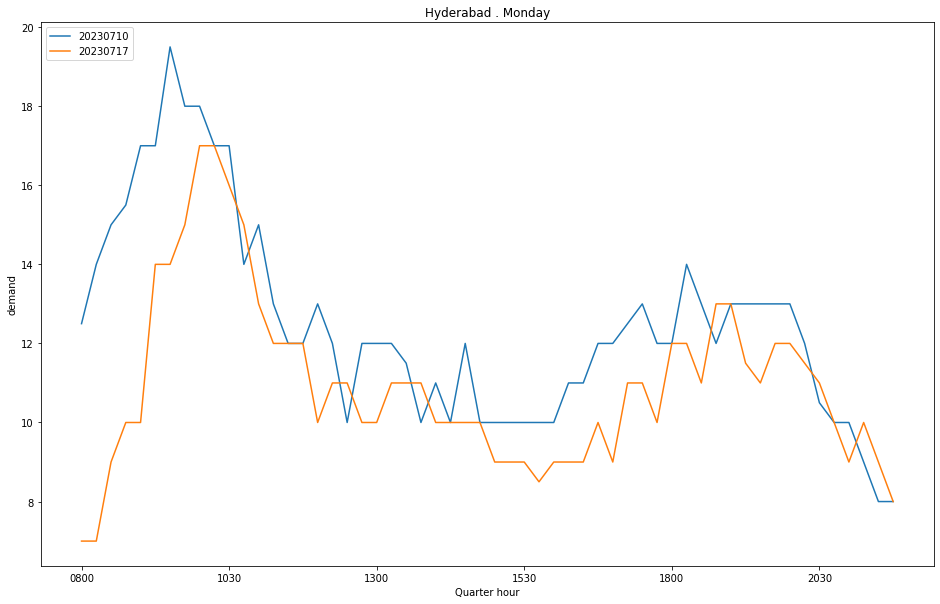

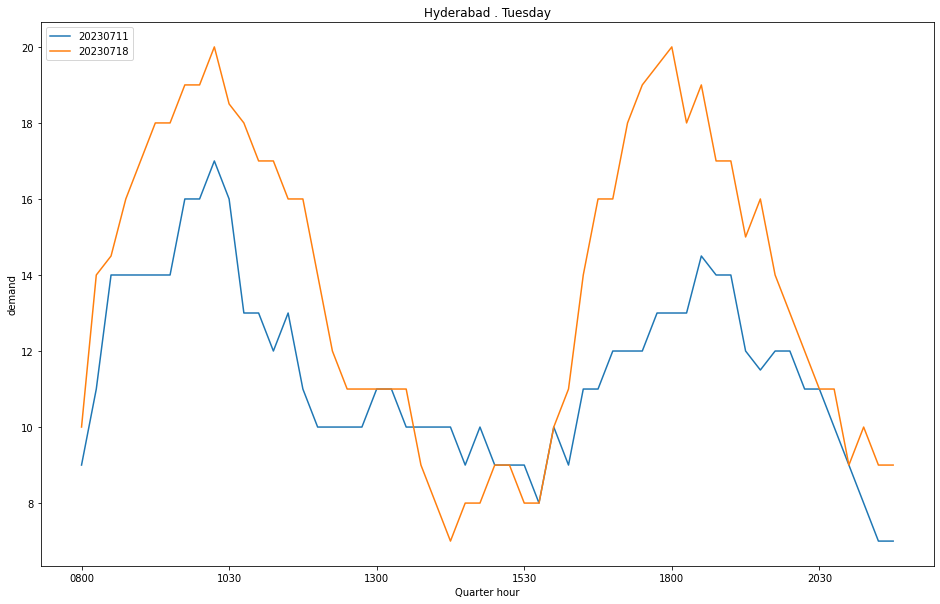

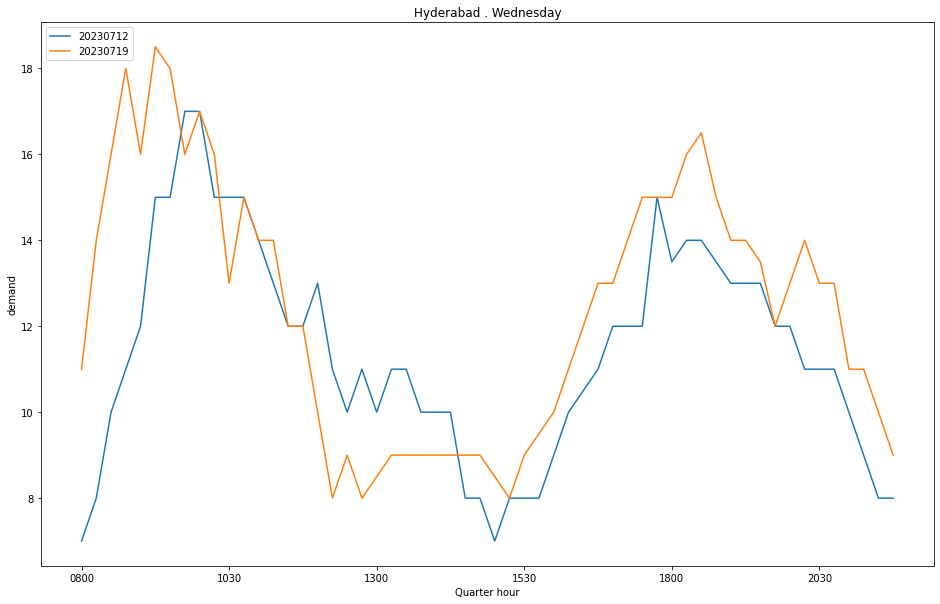

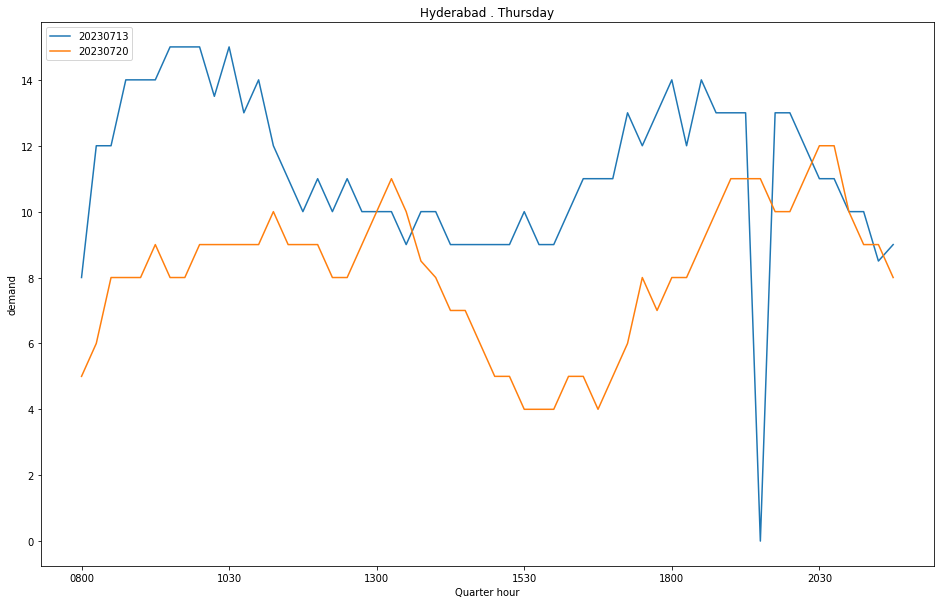

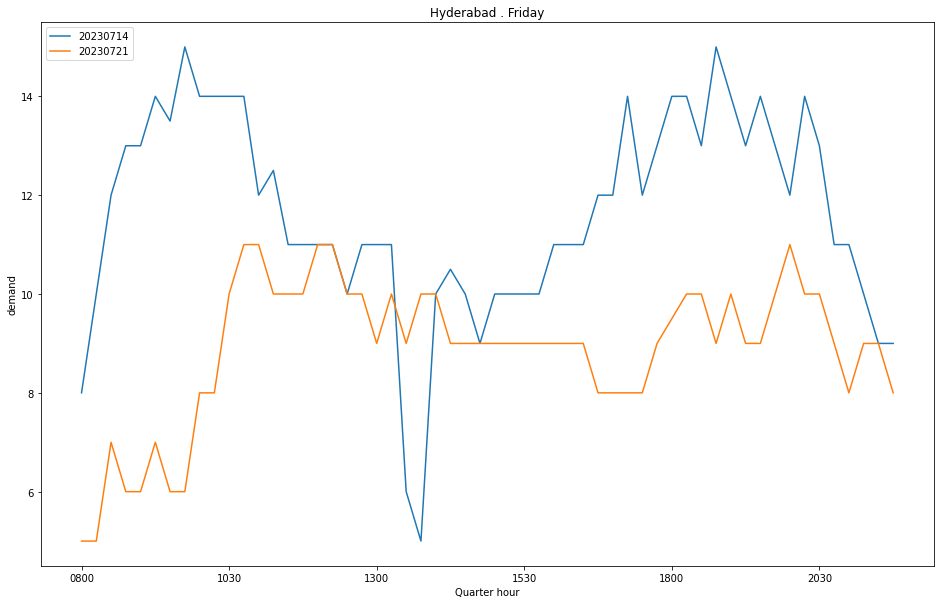

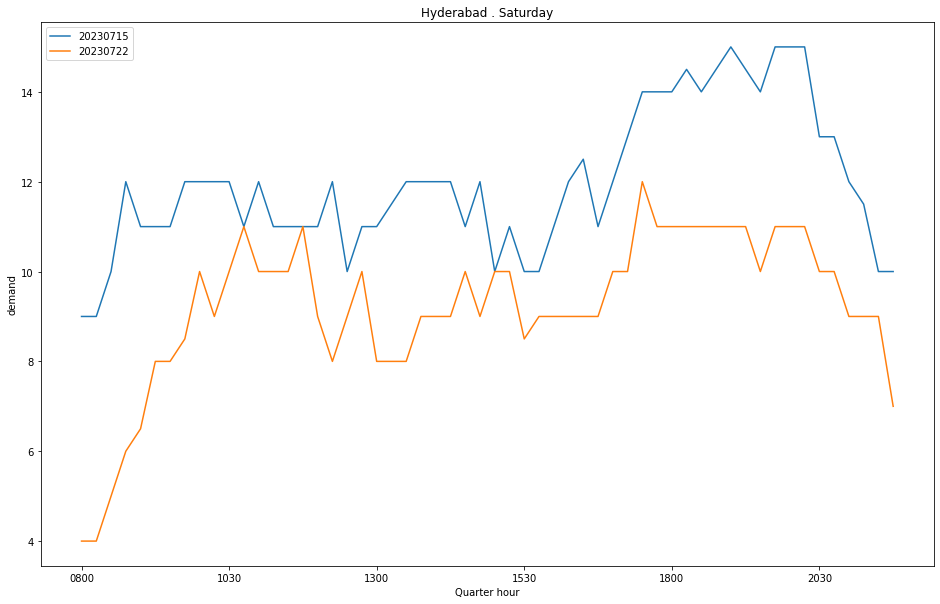

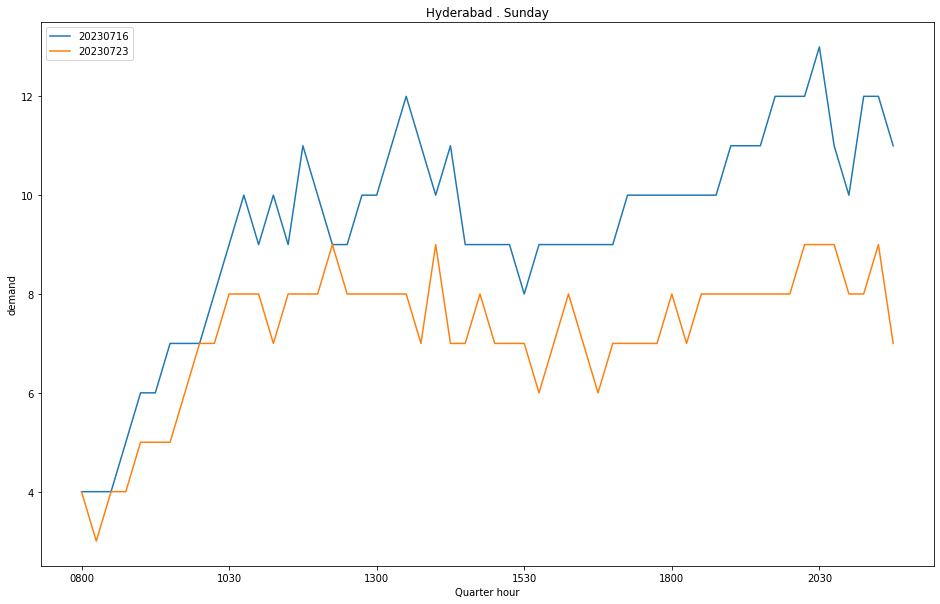

In [83]:
for each_week_period in demand_counts.week_period.unique().tolist():
    
    demand_each_wp = demand_counts[demand_counts['week_period'] == each_week_period]

    ax = demand_each_wp.pivot(index='quarter_hour', columns='yyyymmdd', values='demand').plot(figsize=(16, 10))
    ax.set_title('{} . {}'.format(city, each_week_period))
    ax.set_xlabel('Quarter hour')
    ax.legend(loc='upper left')
    ax.set_ylabel('demand');

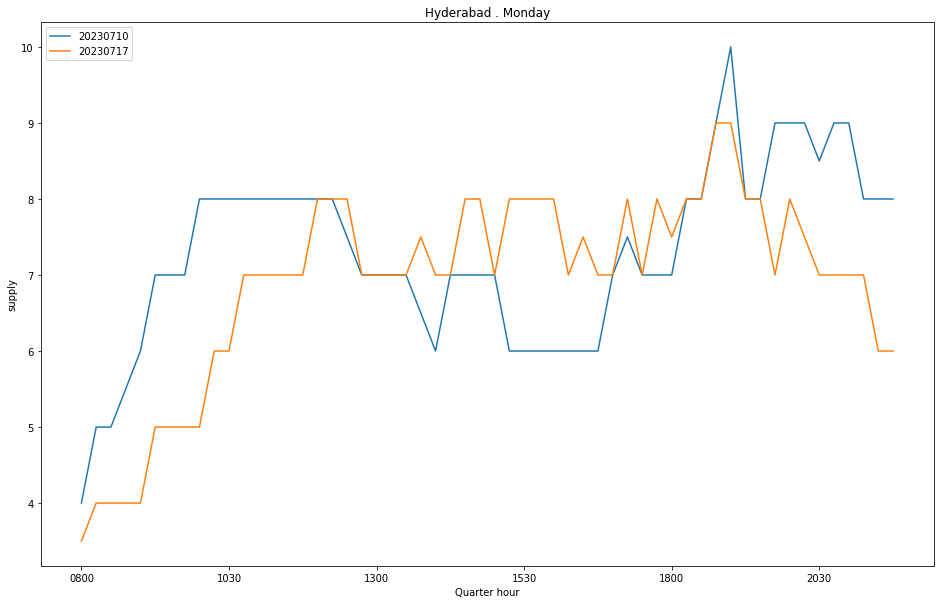

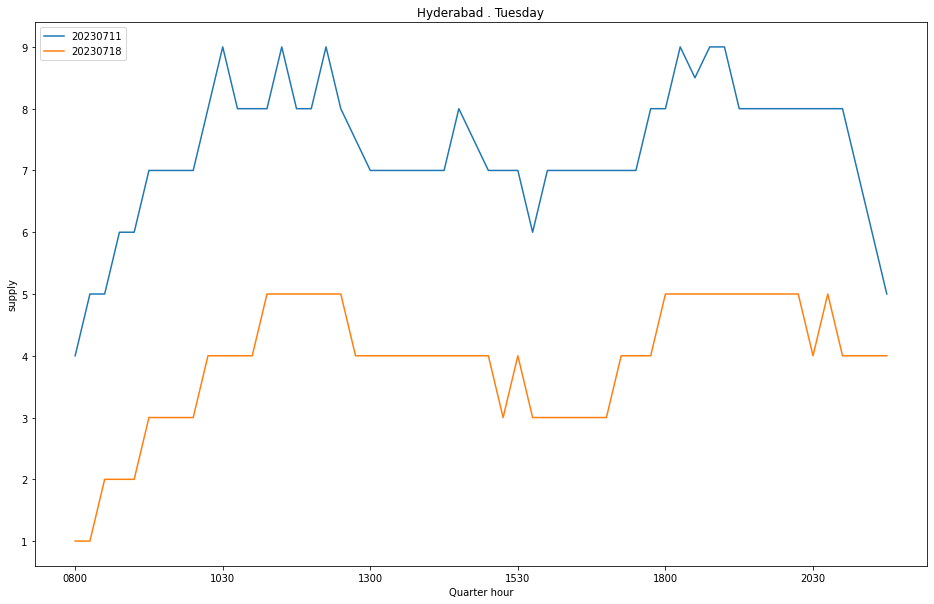

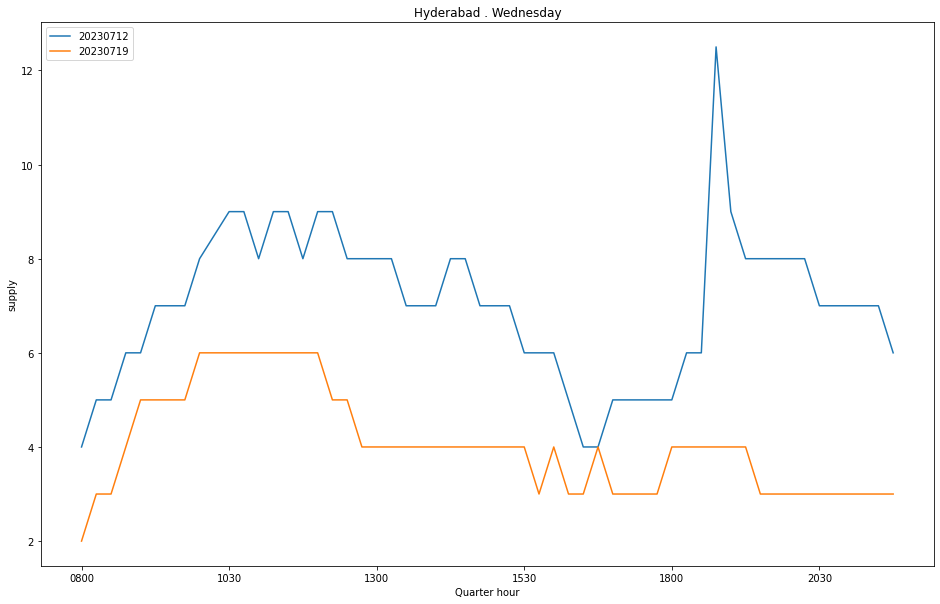

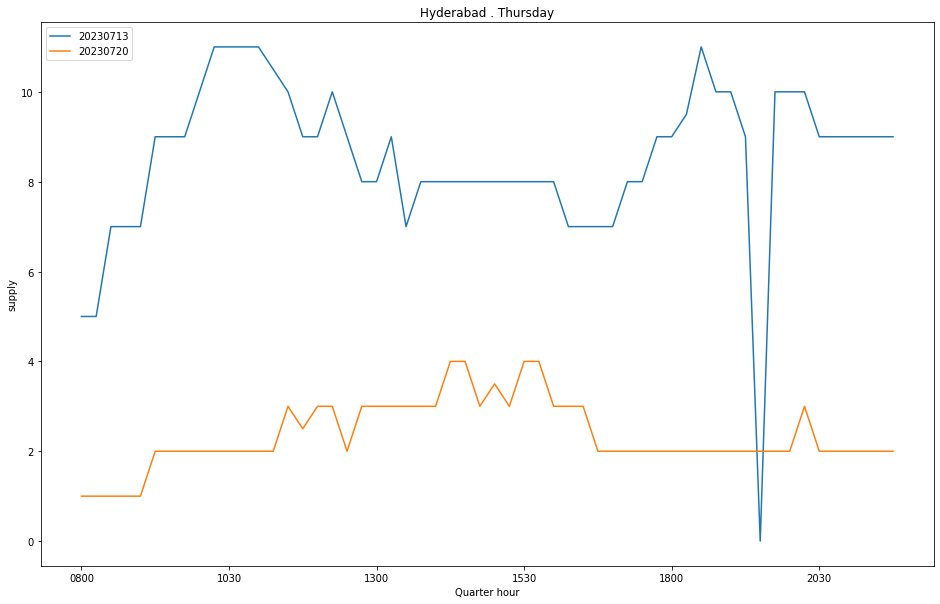

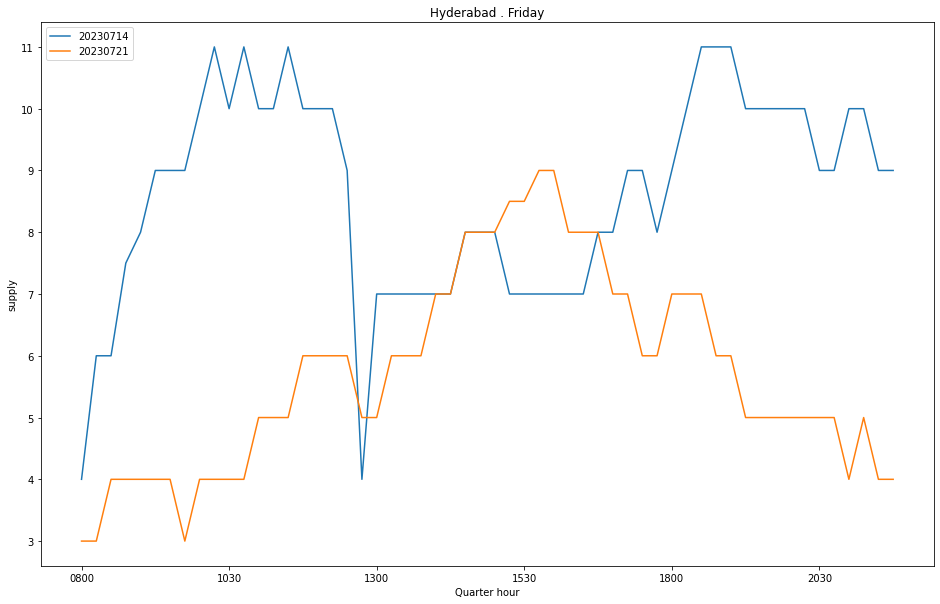

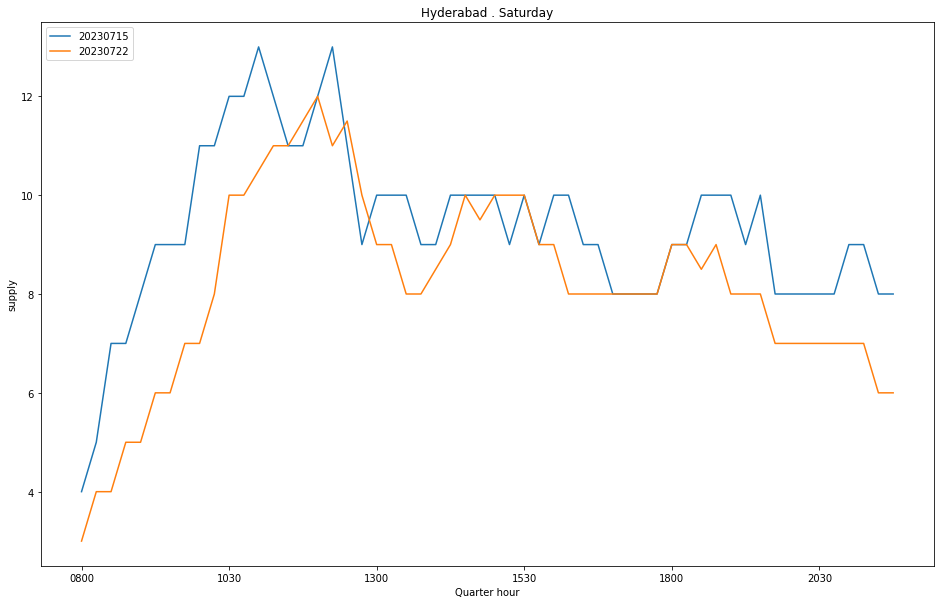

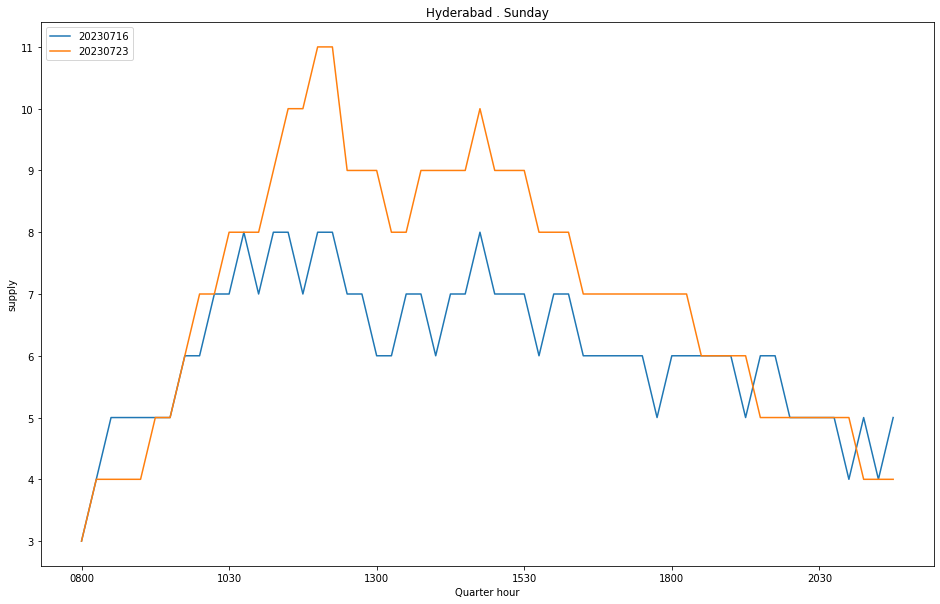

In [84]:
for each_week_period in demand_counts.week_period.unique().tolist():
    
    supply_each_wp = supply_counts[supply_counts['week_period'] == each_week_period]

    ax = supply_each_wp.pivot(index='quarter_hour', columns='yyyymmdd', values='supply').plot(figsize=(16, 10))
    ax.set_title('{} . {}'.format(city, each_week_period))
    ax.set_xlabel('Quarter hour')
    ax.legend(loc='upper left')
    ax.set_ylabel('supply');

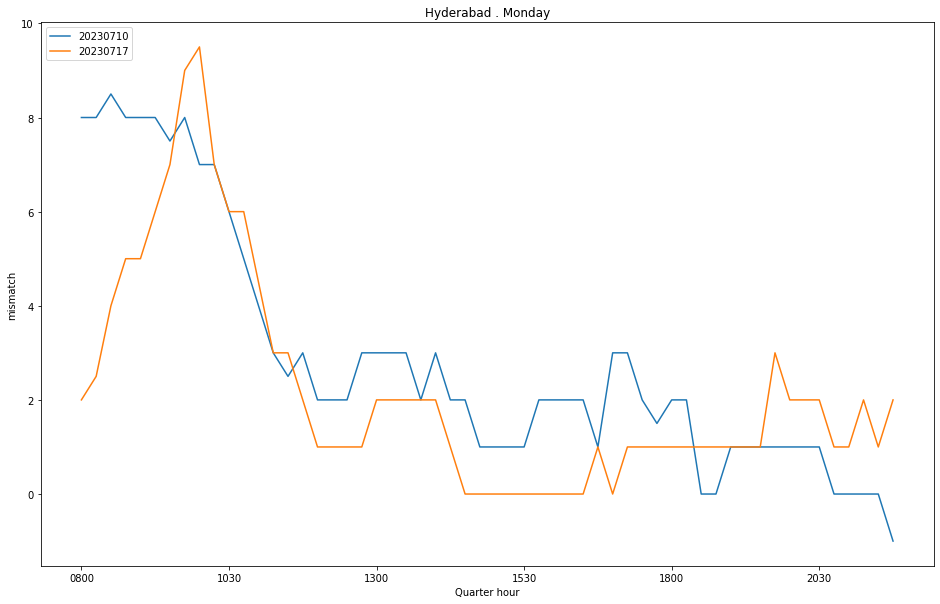

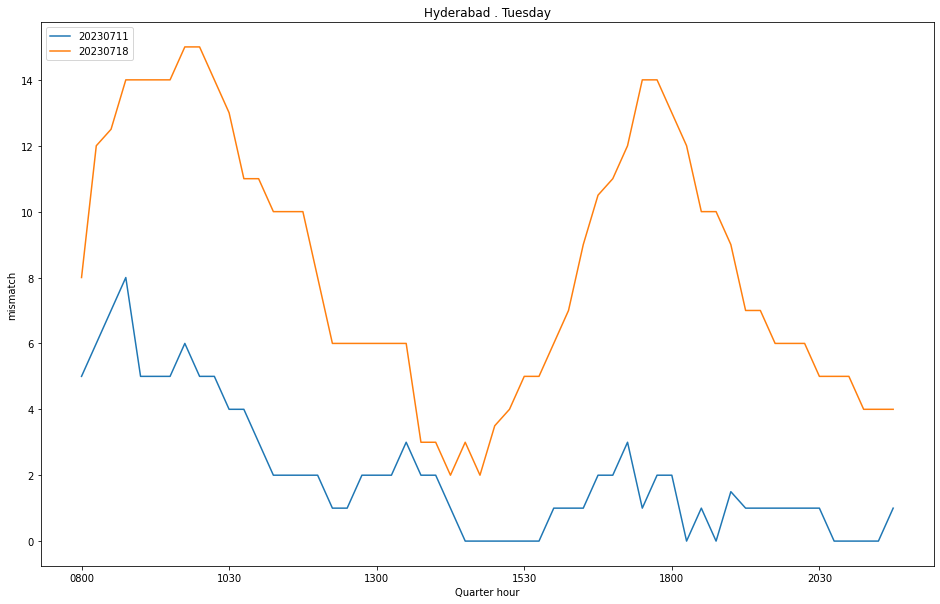

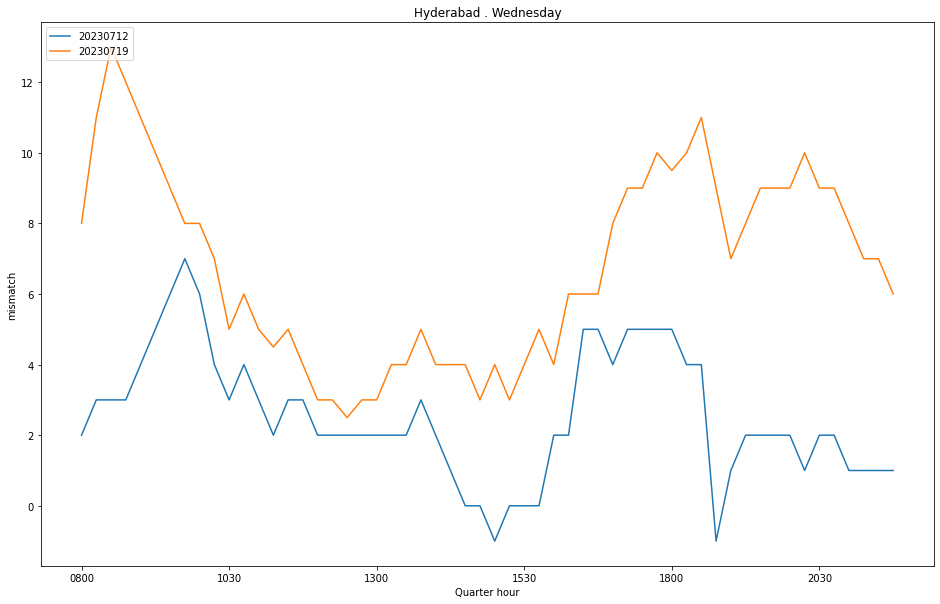

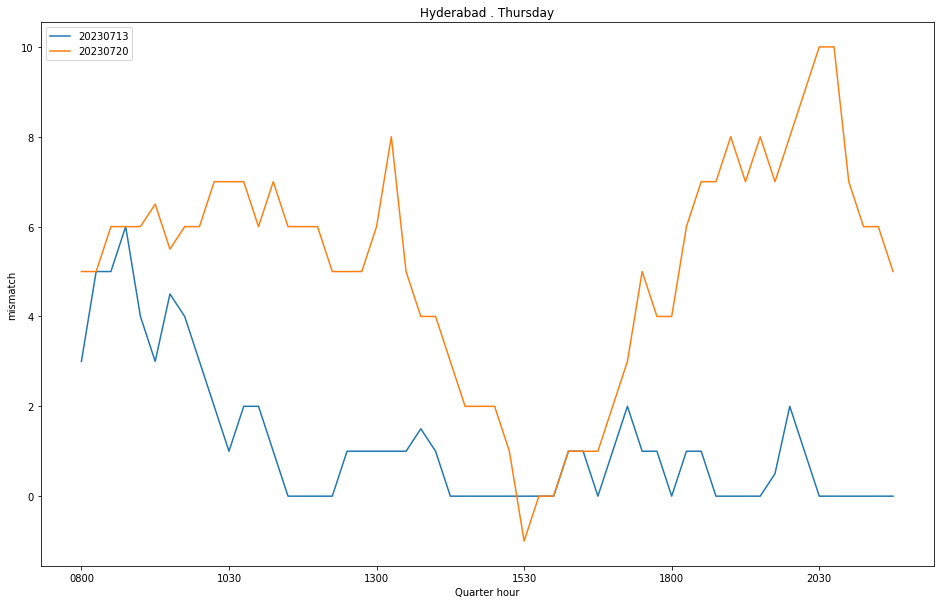

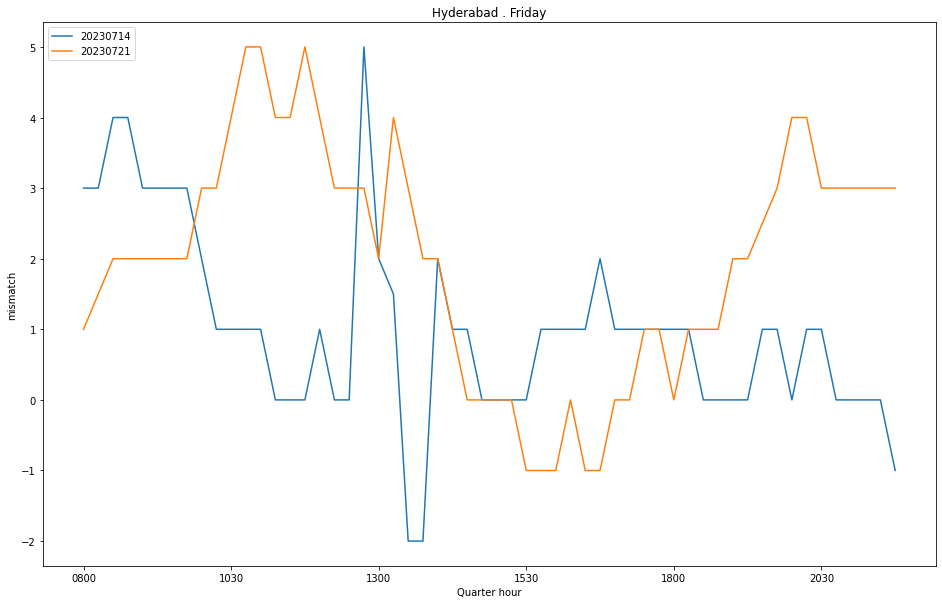

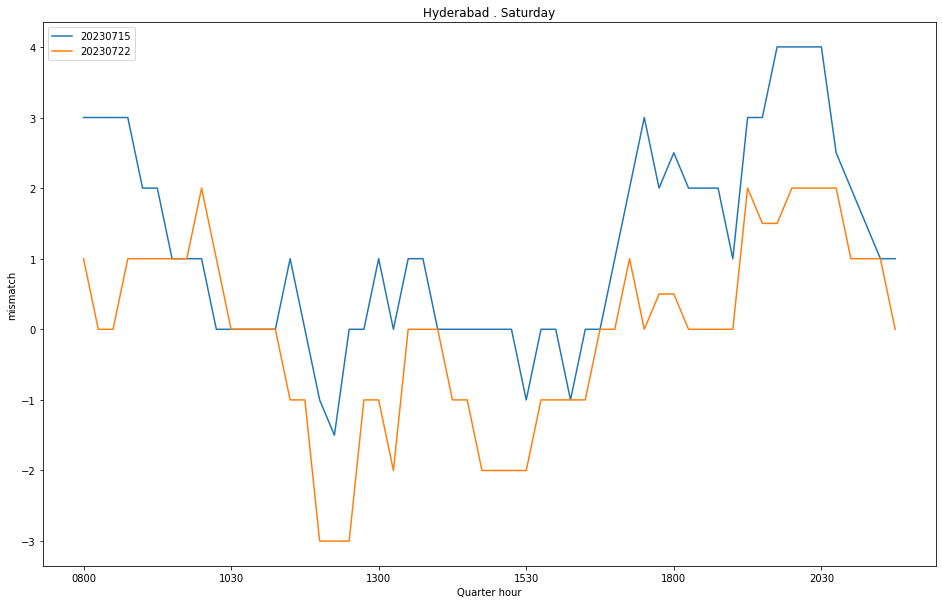

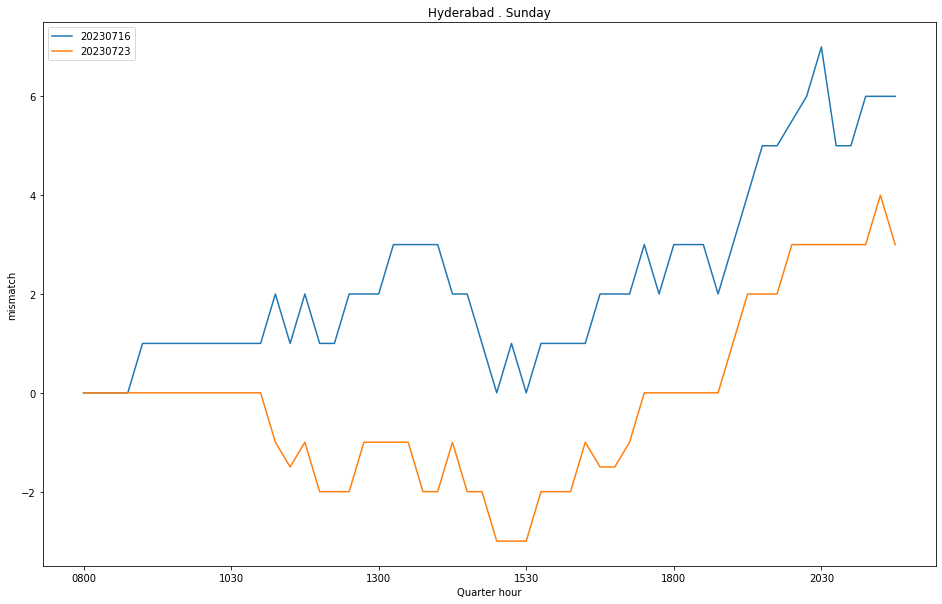

In [85]:
for each_week_period in demand_counts.week_period.unique().tolist():
    
    mismatch_each_wp = mismatch_counts[mismatch_counts['week_period'] == each_week_period]

    ax = mismatch_each_wp.pivot(index='quarter_hour', columns='yyyymmdd', values='mismatch').plot(figsize=(16, 10))
    ax.set_title('{} . {}'.format(city, each_week_period))
    ax.set_xlabel('Quarter hour')
    ax.legend(loc='upper left')
    ax.set_ylabel('mismatch');

### At city and time period level

In [86]:
# Demand view at city and time period level for Link orders.
deamnd_counts_tp = dcf_data \
    .groupby(['yyyymmdd', 'time_period', 'service_detail_id','week_period']) \
    .agg(demand=pd.NamedAgg('demand', 'median')) \
    .reset_index() \
    .pivot_table(index=['yyyymmdd', 'time_period'], columns='service_detail_id', values='demand') \
    .reset_index()

print(deamnd_counts_tp.shape)
deamnd_counts_tp.head()

(42, 3)


service_detail_id,yyyymmdd,time_period,574013f14fdf4798208bba26
0,20230710,afternoon,11.0
1,20230710,evening_peak,11.0
2,20230710,morning_peak,15.0
3,20230711,afternoon,10.0
4,20230711,evening_peak,11.0


In [87]:
# Supply view at city level and time_period for Link orders.
supply_counts_tp = dcf_data \
    .groupby(['yyyymmdd', 'time_period', 'service_detail_id','week_period']) \
    .agg(supply=pd.NamedAgg('supply', 'median')) \
    .reset_index() \
    .pivot_table(index=['yyyymmdd', 'time_period'], columns='service_detail_id', values='supply') \
    .reset_index()

print(supply_counts_tp.shape)
supply_counts_tp.head()

(42, 3)


service_detail_id,yyyymmdd,time_period,574013f14fdf4798208bba26
0,20230710,afternoon,7.0
1,20230710,evening_peak,8.0
2,20230710,morning_peak,7.0
3,20230711,afternoon,7.0
4,20230711,evening_peak,8.0


In [88]:
# Mismatch view at city and time_period level for Link orders.
mismatch_counts_tp = dcf_data \
    .groupby(['yyyymmdd', 'time_period', 'service_detail_id','week_period']) \
    .agg(mismatch=pd.NamedAgg('mismatch', 'median')) \
    .reset_index() \
    .pivot_table(index=['yyyymmdd', 'time_period'], columns='service_detail_id', values='mismatch') \
    .reset_index()

print(mismatch_counts_tp.shape)
mismatch_counts_tp.head()

(42, 3)


service_detail_id,yyyymmdd,time_period,574013f14fdf4798208bba26
0,20230710,afternoon,2.0
1,20230710,evening_peak,1.0
2,20230710,morning_peak,6.0
3,20230711,afternoon,1.0
4,20230711,evening_peak,1.0


### Check for cluster temporal combinations for which dcf_data has mismatch positive, 
* what is the supply
* what is the demand 

In [89]:
# clusters_post_idle_captain_threshold_filter = ['Gachibowli', 'Nanakramguda 2', 'Hitech City',
#        'Wipro Nanakramguda Circle', 'Wipro Gachibowli Campus',
#        'Manikonda', 'shilparamam', 'Kukatpally 3', 'Shamshabad',
#        'Banjara Hills', 'Bahadurguda', 'Quthbullapur', 'Saroor Nagar',
#        'Bodduppal', 'Hitech City 2', 'Mansoorabad', 'Miyapur 2',
#        'Hafeezpet', 'Hayath Nagar', 'Jeedimetla', 'Kukatpally',
#        'Kothaguda 2', 'BHEL']


clusters_post_idle_captain_threshold_filter = cluster_temporal_combinations_selected.pickup_cluster.unique().tolist()


dcf_data.head()

,service_detail_id,orderdate,quarter_hour,pickup_cluster,gross_orders,net_orders,mean_distance,demand,supply,time_period,...,city,yyyymmdd,fe_count,rr_count,net_count,FE2RR,G2N,FE2Net,week_period,mismatch
1,574013f14fdf4798208bba26,2023-07-10,0800,Wipro Nanakramguda Circle,10,8,5.376625,1.0,78.0,morning_peak,...,Hyderabad,20230710,22,12,8,54.5,66.7,36.4,Monday,-77.0
3,574013f14fdf4798208bba26,2023-07-10,0815,Bahadurguda,19,19,6.914500,17.0,10.0,morning_peak,...,Hyderabad,20230710,85,20,19,23.5,95.0,22.4,Monday,7.0
5,574013f14fdf4798208bba26,2023-07-10,0815,Balanagar,50,37,7.056701,66.0,12.0,morning_peak,...,Hyderabad,20230710,227,54,37,23.8,68.5,16.3,Monday,54.0
7,574013f14fdf4798208bba26,2023-07-10,0815,Telecom Nagar Gachibowli,14,11,5.594000,0.0,0.0,morning_peak,...,Hyderabad,20230710,45,14,11,31.1,78.6,24.4,Monday,0.0
9,574013f14fdf4798208bba26,2023-07-10,0830,Balanagar,55,35,5.581947,54.0,16.0,morning_peak,...,Hyderabad,20230710,252,69,35,27.4,50.7,13.9,Monday,38.0


In [90]:
dcf_data_filtered_on_supply = dcf_data[dcf_data['pickup_cluster'].isin(clusters_post_idle_captain_threshold_filter)]

dcf_data_filtered_on_supply.head()

,service_detail_id,orderdate,quarter_hour,pickup_cluster,gross_orders,net_orders,mean_distance,demand,supply,time_period,...,city,yyyymmdd,fe_count,rr_count,net_count,FE2RR,G2N,FE2Net,week_period,mismatch
1,574013f14fdf4798208bba26,2023-07-10,0800,Wipro Nanakramguda Circle,10,8,5.376625,1.0,78.0,morning_peak,...,Hyderabad,20230710,22,12,8,54.5,66.7,36.4,Monday,-77.0
3,574013f14fdf4798208bba26,2023-07-10,0815,Bahadurguda,19,19,6.914500,17.0,10.0,morning_peak,...,Hyderabad,20230710,85,20,19,23.5,95.0,22.4,Monday,7.0
25,574013f14fdf4798208bba26,2023-07-10,1000,shilparamam,38,34,4.744024,41.0,37.0,morning_peak,...,Hyderabad,20230710,157,41,34,26.1,82.9,21.7,Monday,4.0
31,574013f14fdf4798208bba26,2023-07-10,1015,Hitech City,388,301,3.882611,364.0,210.0,morning_peak,...,Hyderabad,20230710,1596,436,301,27.3,69.0,18.9,Monday,154.0
38,574013f14fdf4798208bba26,2023-07-10,1045,Bahadurguda,20,19,5.505569,25.0,31.0,morning_peak,...,Hyderabad,20230710,89,20,19,22.5,95.0,21.3,Monday,-6.0


In [91]:
dcf_data_filtered_on_supply.quarter_hour.unique()

array(['0800', '0815', '1000', '1015', '1045', '1115', '1145', '1230',
       '1245', '1330', '1445', '1500', '1515', '1600', '1630', '1645',
       '1730', '1815', '1830', '1845', '1900', '1915', '1930', '1945',
       '2000', '2015', '2030', '2045', '2115', '0830', '0930', '0945',
       '1100', '1130', '1200', '1215', '1530', '1745', '1800', '0915',
       '1030', '1315', '1415', '1615', '1715', '0845', '1400', '1430',
       '1345', '1700', '1300', '1545', '2100', '2130', '2145', '0900'],
      dtype=object)

In [92]:
## morning peak vs evening peak vs afternoon peak of dcf_data post supply filter

cluster_name = clusters_post_idle_captain_threshold_filter[0]

dcf_data_filtered_on_supply_one_cluster = dcf_data_filtered_on_supply[
    dcf_data_filtered_on_supply['pickup_cluster'] == cluster_name]

dcf_data_filtered_on_supply_one_cluster.head()

,service_detail_id,orderdate,quarter_hour,pickup_cluster,gross_orders,net_orders,mean_distance,demand,supply,time_period,...,city,yyyymmdd,fe_count,rr_count,net_count,FE2RR,G2N,FE2Net,week_period,mismatch
255,574013f14fdf4798208bba26,2023-07-11,1530,Nanakramguda 2,11,8,3.952300,8.0,15.0,afternoon,...,Hyderabad,20230711,46,11,8,23.9,72.7,17.4,Tuesday,-7.0
408,574013f14fdf4798208bba26,2023-07-12,1600,Nanakramguda 2,9,5,9.712938,5.0,17.0,afternoon,...,Hyderabad,20230712,115,9,5,7.8,55.6,4.3,Wednesday,-12.0
1673,574013f14fdf4798208bba26,2023-07-21,1530,Nanakramguda 2,21,17,6.247264,6.0,15.0,afternoon,...,Hyderabad,20230721,64,21,17,32.8,81.0,26.6,Friday,-9.0
1679,574013f14fdf4798208bba26,2023-07-21,1545,Nanakramguda 2,10,8,5.960111,18.0,25.0,afternoon,...,Hyderabad,20230721,75,10,8,13.3,80.0,10.7,Friday,-7.0
1693,574013f14fdf4798208bba26,2023-07-21,1645,Nanakramguda 2,8,5,4.535767,16.0,25.0,afternoon,...,Hyderabad,20230721,75,9,5,12.0,55.6,6.7,Friday,-9.0


In [93]:
dcf_data_filtered_on_supply_one_cluster['quarter_hour'] = dcf_data_filtered_on_supply_one_cluster[
    'quarter_hour'].astype('int')

dcf_data_filtered_on_supply_one_cluster = dcf_data_filtered_on_supply_one_cluster[
    (dcf_data_filtered_on_supply_one_cluster['quarter_hour'] >= 1100) & (
        dcf_data_filtered_on_supply_one_cluster['quarter_hour'] <= 2100)]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [94]:
dcf_data_stats =  pd.pivot_table( dcf_data_filtered_on_supply_one_cluster, 
values= ['supply'] , 
index=['pickup_cluster','week_period'],
columns=['quarter_hour'])

dcf_data_stats

supply                                          \
quarter_hour                  1100   1115    1130   1145  1200  1215  1230   
pickup_cluster week_period                                                   
Nanakramguda 2 Friday        667.0  533.0   695.0  716.0  41.0  46.5  49.5   
               Monday       1311.5  993.5  1128.0  926.0  23.0  25.5  18.0   
               Saturday      528.0  471.0   470.5  569.0  23.0  23.5  21.0   
               Sunday        206.5  203.5   259.0  300.5  32.5  29.0  13.5   
               Thursday      724.0  596.0   773.0  633.0  13.0  15.5  15.0   
               Tuesday       795.5  591.5   776.5  662.5  26.5  30.0  24.0   
               Wednesday     762.5  812.5   903.0  745.0  60.0  52.5  43.0   

                                              ...                           \
quarter_hour                1245  1300  1315  ... 1845 1900 1915 1930 1945   
pickup_cluster week_period                    ...                            
Nanakramguda 2 Friday       27.5  39.0  34.0  ...  5.5  6.5  5.0  7.5  7.0   
               Monday       19.5  17.5  17.0  ...  7.0  7.5  8.0  9.0  8.0   
               Saturday     21.5  16.5  13.0  ...  6.5  7.0  6.5  7.5  6.0   
               Sunday       19.5  20.5  16.0  ...  4.5  5.0  4.5  4.0  4.0   
               Thursday     15.5  13.0  11.5  ...  4.0  3.5  5.0  0.5  4.0   
               Tuesday      25.0  28.0  19.5  ...  5.5  4.5  6.5  7.0  5.0   
               Wednesday    31.5  34.0  25.5  ...  7.5  6.0  6.5  5.5  6.5   

                                                       
quarter_hour                2000 2015 2030 2045  2100  
pickup_cluster week_period                             
Nanakramguda 2 Friday        7.0  6.5  6.5  5.0   8.0  
               Monday       10.5  8.0  7.5  7.5  10.5  
               Saturday      6.0  7.0  8.0  7.0   9.5  
               Sunday        3.5  4.0  4.0  3.5   4.5  
               Thursday      5.5  6.0  4.0  3.0   4.5  
               Tuesday       7.5  7.0  5.0  4.5   5.0  
               Wednesday     7.0  6.0  5.0  5.0   5.0  

[7 rows x 41 columns]

In [95]:
dcf_data_filtered_on_supply['quarter_hour'] = dcf_data_filtered_on_supply[
    'quarter_hour'].astype('int')

dcf_data_filtered_on_supply = dcf_data_filtered_on_supply[
    (dcf_data_filtered_on_supply['quarter_hour'] >= 1100) & (
        dcf_data_filtered_on_supply['quarter_hour'] <= 2100)]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [96]:
dcf_data_stats =  pd.pivot_table( dcf_data_filtered_on_supply, 
values= ['supply'] , 
index=['pickup_cluster','week_period'],
columns=['quarter_hour'])

dcf_data_stats

supply                                            \
quarter_hour                 1100  1115  1130  1145  1200  1215  1230  1245   
pickup_cluster week_period                                                    
BHEL           Friday         9.5   9.0  11.5  12.0  18.0  35.0  30.0  20.0   
               Monday         9.0  12.5  14.0  13.0  17.5  22.0  12.5  18.0   
               Saturday      20.0  22.5  20.5  22.0  28.5  37.0  31.0  24.0   
               Sunday        13.5  15.5  20.5  24.0  35.0  31.5  39.0  25.5   
               Thursday       7.5   8.5  10.0  10.5  12.5  16.5   9.5  12.0   
...                           ...   ...   ...   ...   ...   ...   ...   ...   
shilparamam    Saturday      55.5  63.0  67.5  50.0  59.5  64.0  47.0  41.5   
               Sunday        47.5  46.0  48.5  43.0  56.0  48.5  49.5  42.5   
               Thursday      32.0  29.0  38.5  33.5  31.5  25.5  22.0  30.5   
               Tuesday       36.5  41.0  42.0  29.5  35.0  37.5  30.5  31.5   
               Wednesday     41.0  40.0  44.0  42.5  36.0  38.0  32.0  33.0   

                                        ...                                \
quarter_hour                1300  1315  ...  1845  1900  1915  1930  1945   
pickup_cluster week_period              ...                                 
BHEL           Friday       19.0  33.5  ...  31.0  33.5  29.0  30.0  20.0   
               Monday       16.5  22.0  ...  39.0  35.5  36.5  31.5  28.0   
               Saturday     31.0  34.5  ...  45.0  37.5  31.0  30.0  28.5   
               Sunday       26.0  29.0  ...  25.0  20.0  18.0  17.5  16.0   
               Thursday     13.5  16.5  ...  28.0  24.0  20.0   2.5  17.5   
...                          ...   ...  ...   ...   ...   ...   ...   ...   
shilparamam    Saturday     42.5  35.0  ...  43.0  42.5  40.0  42.0  43.0   
               Sunday       44.5  36.0  ...  27.5  32.0  31.5  26.0  26.0   
               Thursday     21.0  24.5  ...  29.0  32.5  25.0   6.0  26.5   
               Tuesday      23.5  26.0  ...  33.0  33.5  35.5  37.0  34.0   
               Wednesday    29.0  24.5  ...  36.0  35.0  33.5  33.0  32.5   

                                                          
quarter_hour                2000  2015  2030  2045  2100  
pickup_cluster week_period                                
BHEL           Friday       23.5  23.0  25.5  24.0  27.0  
               Monday       24.5  26.0  27.5  28.5  30.0  
               Saturday     25.0  25.0  28.5  27.5  27.0  
               Sunday       16.5  14.5  14.0  16.5  12.5  
               Thursday     14.0  15.0  22.0  15.0  16.5  
...                          ...   ...   ...   ...   ...  
shilparamam    Saturday     36.5  35.5  22.0  28.5  29.5  
               Sunday       19.0  18.5  14.0  18.5  17.5  
               Thursday     24.0  27.5  24.0  20.0  19.5  
               Tuesday      33.5  35.5  30.0  27.0  31.5  
               Wednesday    24.5  30.5  28.0  21.0  21.0  

[161 rows x 41 columns]

In [97]:
dcf_data.head()

,service_detail_id,orderdate,quarter_hour,pickup_cluster,gross_orders,net_orders,mean_distance,demand,supply,time_period,...,city,yyyymmdd,fe_count,rr_count,net_count,FE2RR,G2N,FE2Net,week_period,mismatch
1,574013f14fdf4798208bba26,2023-07-10,0800,Wipro Nanakramguda Circle,10,8,5.376625,1.0,78.0,morning_peak,...,Hyderabad,20230710,22,12,8,54.5,66.7,36.4,Monday,-77.0
3,574013f14fdf4798208bba26,2023-07-10,0815,Bahadurguda,19,19,6.914500,17.0,10.0,morning_peak,...,Hyderabad,20230710,85,20,19,23.5,95.0,22.4,Monday,7.0
5,574013f14fdf4798208bba26,2023-07-10,0815,Balanagar,50,37,7.056701,66.0,12.0,morning_peak,...,Hyderabad,20230710,227,54,37,23.8,68.5,16.3,Monday,54.0
7,574013f14fdf4798208bba26,2023-07-10,0815,Telecom Nagar Gachibowli,14,11,5.594000,0.0,0.0,morning_peak,...,Hyderabad,20230710,45,14,11,31.1,78.6,24.4,Monday,0.0
9,574013f14fdf4798208bba26,2023-07-10,0830,Balanagar,55,35,5.581947,54.0,16.0,morning_peak,...,Hyderabad,20230710,252,69,35,27.4,50.7,13.9,Monday,38.0


In [98]:
dcf_data.demand.median()

10.0

In [99]:
dcf_data['hour'] = dcf_data['quarter_hour'].apply(lambda x: str(x[0:2]))
dcf_data['mismatch'] = dcf_data['demand'] - dcf_data['supply']

dcf_data_stats_hour_level = dcf_data.groupby([
    'city','pickup_cluster','service_detail_id','week_period','time_period','hour']).agg(
    demand = pd.NamedAgg('demand','sum'), 
    supply = pd.NamedAgg('supply','sum'),
    mismatch = pd.NamedAgg('mismatch','median'), 
    fe_count = pd.NamedAgg('fe_count','sum'), 
    rr_count = pd.NamedAgg('rr_count','sum'), 
    net_count = pd.NamedAgg('net_count','sum')
).reset_index().sort_values(['city','pickup_cluster','service_detail_id','week_period','hour','time_period'])

dcf_data_stats_hour_level['mismtach_pred'] = dcf_data_stats_hour_level['demand'] - dcf_data_stats_hour_level['supply']

dcf_data_stats_hour_level.head(20)

,city,pickup_cluster,service_detail_id,week_period,time_period,hour,demand,supply,mismatch,fe_count,rr_count,net_count,mismtach_pred
10,Hyderabad,AOC Centre,574013f14fdf4798208bba26,Friday,morning_peak,08,200.0,66.0,15.0,995,225,145,134.0
11,Hyderabad,AOC Centre,574013f14fdf4798208bba26,Friday,morning_peak,09,192.0,135.0,7.0,2578,198,113,57.0
12,Hyderabad,AOC Centre,574013f14fdf4798208bba26,Friday,morning_peak,10,214.0,146.0,8.5,1667,221,136,68.0
13,Hyderabad,AOC Centre,574013f14fdf4798208bba26,Friday,morning_peak,11,179.0,141.0,6.5,1023,201,127,38.0
0,Hyderabad,AOC Centre,574013f14fdf4798208bba26,Friday,afternoon,12,192.0,153.0,6.0,996,198,132,39.0
1,Hyderabad,AOC Centre,574013f14fdf4798208bba26,Friday,afternoon,13,137.0,152.0,-1.0,959,163,112,-15.0
2,Hyderabad,AOC Centre,574013f14fdf4798208bba26,Friday,afternoon,14,159.0,174.0,-2.0,791,159,118,-15.0
3,Hyderabad,AOC Centre,574013f14fdf4798208bba26,Friday,afternoon,15,118.0,169.0,-6.5,801,123,95,-51.0
4,Hyderabad,AOC Centre,574013f14fdf4798208bba26,Friday,afternoon,16,121.0,179.0,-8.5,893,136,102,-58.0
5,Hyderabad,AOC Centre,574013f14fdf4798208bba26,Friday,evening_peak,17,133.0,190.0,-8.0,1139,126,87,-57.0


In [100]:
dcf_data_stats_hour_level['excess_supply_ratio'] = dcf_data_stats_hour_level[
    'supply']/dcf_data_stats_hour_level['demand']

dcf_data_stats_hour_level.loc[(dcf_data_stats_hour_level['excess_supply_ratio'] > 1.0) , 'is_excess_supply'] = 'yes'
dcf_data_stats_hour_level.loc[(dcf_data_stats_hour_level['excess_supply_ratio'] <= 1.0) , 'is_excess_supply'] = 'no'
dcf_data_stats_hour_level.head()

,city,pickup_cluster,service_detail_id,week_period,time_period,hour,demand,supply,mismatch,fe_count,rr_count,net_count,mismtach_pred,excess_supply_ratio,is_excess_supply
10,Hyderabad,AOC Centre,574013f14fdf4798208bba26,Friday,morning_peak,08,200.0,66.0,15.0,995,225,145,134.0,0.330000,no
11,Hyderabad,AOC Centre,574013f14fdf4798208bba26,Friday,morning_peak,09,192.0,135.0,7.0,2578,198,113,57.0,0.703125,no
12,Hyderabad,AOC Centre,574013f14fdf4798208bba26,Friday,morning_peak,10,214.0,146.0,8.5,1667,221,136,68.0,0.682243,no
13,Hyderabad,AOC Centre,574013f14fdf4798208bba26,Friday,morning_peak,11,179.0,141.0,6.5,1023,201,127,38.0,0.787709,no
0,Hyderabad,AOC Centre,574013f14fdf4798208bba26,Friday,afternoon,12,192.0,153.0,6.0,996,198,132,39.0,0.796875,no


In [101]:
## Validate and confirm that afternoon has excess, idle supply which needs fulfillment
dcf_data_stats_hour_level_pivot =  pd.pivot_table( dcf_data_stats_hour_level, 
                                           values= ['demand', 'supply', 'fe_count', 'rr_count','net_count'] , 
                                           index=['pickup_cluster','week_period'],
                                           columns=['time_period','hour']
                                          )
dcf_data_stats_hour_level_pivot

demand                                           \
time_period                afternoon                             evening_peak   
hour                              12     13     14     15     16           17   
pickup_cluster week_period                                                      
AOC Centre     Friday          192.0  137.0  159.0  118.0  121.0        133.0   
               Monday          196.0  181.0  153.0  132.0  175.0        183.0   
               Saturday        162.0  164.0  132.0  136.0  157.0        191.0   
               Sunday          148.0  189.0  175.0  155.0  154.0        180.0   
               Thursday        179.0  169.0  124.0   96.0   95.0        118.0   
...                              ...    ...    ...    ...    ...          ...   
shilparamam    Saturday        161.0  171.0  143.0  124.0  170.0        192.0   
               Sunday          156.0  156.0  151.0  135.0  141.0        136.0   
               Thursday        130.0  164.0  134.0  104.0   87.0        135.0   
               Tuesday         150.0  170.0  107.0  124.0  160.0        207.0   
               Wednesday       159.0  157.0  119.0  120.0  159.0        169.0   

                                                        ...    supply  \
time_period                                             ... afternoon   
hour                           18     19     20     21  ...        16   
pickup_cluster week_period                              ...             
AOC Centre     Friday       127.0  136.0  172.0  111.0  ...     179.0   
               Monday       196.0  190.0  163.0  157.0  ...     176.0   
               Saturday     179.0  192.0  170.0  153.0  ...     305.0   
               Sunday       182.0  235.0  193.0  188.0  ...     145.0   
               Thursday     127.0  114.0  137.0   82.0  ...     130.0   
...                           ...    ...    ...    ...  ...       ...   
shilparamam    Saturday     185.0  202.0  169.0  121.0  ...     310.0   
               Sunday       152.0  149.0  138.0  147.0  ...     305.0   
               Thursday     152.0  133.0  141.0  128.0  ...     194.0   
               Tuesday      209.0  176.0  148.0  103.0  ...     200.0   
               Wednesday    175.0  162.0  137.0  127.0  ...     174.0   

                                                                     \
time_period                evening_peak                               
hour                                 17     18     19     20     21   
pickup_cluster week_period                                            
AOC Centre     Friday             190.0  226.0  174.0  158.0  127.0   
               Monday             189.0  219.0  216.0  172.0  151.0   
               Saturday           229.0  251.0  217.0  185.0  162.0   
               Sunday             171.0  146.0  135.0  126.0   93.0   
               Thursday           161.0  198.0  140.0  138.0  116.0   
...                                 ...    ...    ...    ...    ...   
shilparamam    Saturday           315.0  398.0  335.0  245.0  226.0   
               Sunday             239.0  249.0  231.0  140.0  155.0   
               Thursday           177.0  250.0  180.0  191.0  150.0   
               Tuesday            215.0  297.0  280.0  252.0  204.0   
               Wednesday          169.0  237.0  268.0  208.0  155.0   

                                                              
time_period                morning_peak                       
hour                                 08     09     10     11  
pickup_cluster week_period                                    
AOC Centre     Friday              66.0  135.0  146.0  141.0  
               Monday              51.0  100.0  116.0  137.0  
               Saturday            75.0  118.0  168.0  200.0  
               Sunday              73.0   88.0  140.0  191.0  
               Thursday            50.0   93.0  118.0  136.0  
...                                 ...    ...    ...    ...  
shilparamam    Saturda

In [102]:
dcf_data_stats_hour_level.groupby(
    ['pickup_cluster','week_period','time_period','hour']).is_excess_supply.value_counts()

pickup_cluster  week_period  time_period   hour  is_excess_supply
AOC Centre      Friday       afternoon     12    no                  1
                                           13    yes                 1
                                           14    yes                 1
                                           15    yes                 1
                                           16    yes                 1
                                                                    ..
shilparamam     Wednesday    evening_peak  21    yes                 1
                             morning_peak  08    no                  1
                                           09    no                  1
                                           10    yes                 1
                                           11    yes                 1
Name: is_excess_supply, Length: 19886, dtype: int64

In [103]:
check_for_excess_idle_captains = dcf_data_stats_hour_level[dcf_data_stats_hour_level['pickup_cluster'].isin(
    clusters_post_idle_captain_threshold_filter)]

In [104]:
check_for_excess_idle_captains = check_for_excess_idle_captains.dropna()

In [105]:
check_for_excess_idle_captains.head()

,city,pickup_cluster,service_detail_id,week_period,time_period,hour,demand,supply,mismatch,fe_count,rr_count,net_count,mismtach_pred,excess_supply_ratio,is_excess_supply
1186,Hyderabad,BHEL,574013f14fdf4798208bba26,Friday,morning_peak,08,168.0,77.0,8.5,901,168,99,91.0,0.458333,no
1187,Hyderabad,BHEL,574013f14fdf4798208bba26,Friday,morning_peak,09,151.0,77.0,7.5,1639,194,93,74.0,0.509934,no
1188,Hyderabad,BHEL,574013f14fdf4798208bba26,Friday,morning_peak,10,183.0,61.0,11.0,1531,197,102,122.0,0.333333,no
1189,Hyderabad,BHEL,574013f14fdf4798208bba26,Friday,morning_peak,11,175.0,84.0,10.5,1062,206,107,91.0,0.480000,no
1176,Hyderabad,BHEL,574013f14fdf4798208bba26,Friday,afternoon,12,163.0,206.0,-1.5,984,165,97,-43.0,1.263804,yes


In [106]:
dcf_data_stats_tp_level = dcf_data_stats_hour_level.groupby([
    'city','pickup_cluster','service_detail_id','week_period','time_period']).agg(
    demand = pd.NamedAgg('demand','median'), 
    supply = pd.NamedAgg('supply','median'),
    mismatch_qr_level = pd.NamedAgg('mismatch','median'), 
    fe_count = pd.NamedAgg('fe_count','sum'), 
    rr_count = pd.NamedAgg('rr_count','sum'), 
    net_count = pd.NamedAgg('net_count','sum'),
    fe_count_med = pd.NamedAgg('fe_count','median'), 
    rr_count_med = pd.NamedAgg('rr_count','median'), 
    net_count_med = pd.NamedAgg('net_count','median')
).reset_index().sort_values(['city','pickup_cluster','service_detail_id','week_period','time_period'])

dcf_data_stats_tp_level['mismtach_pred_tp'] = dcf_data_stats_tp_level['demand'] - dcf_data_stats_tp_level['supply']

dcf_data_stats_tp_level.head(20)

,city,pickup_cluster,service_detail_id,week_period,time_period,demand,supply,mismatch_qr_level,fe_count,rr_count,net_count,fe_count_med,rr_count_med,net_count_med,mismtach_pred_tp
0,Hyderabad,AOC Centre,574013f14fdf4798208bba26,Friday,afternoon,137.0,169.0,-2.00,4440,779,559,893.0,159.0,112.0,-32.0
1,Hyderabad,AOC Centre,574013f14fdf4798208bba26,Friday,evening_peak,133.0,174.0,-4.50,4076,675,478,828.0,129.0,97.0,-41.0
2,Hyderabad,AOC Centre,574013f14fdf4798208bba26,Friday,morning_peak,196.0,138.0,7.75,6263,845,521,1345.0,211.0,131.5,58.0
3,Hyderabad,AOC Centre,574013f14fdf4798208bba26,Monday,afternoon,175.0,171.0,0.50,5174,873,661,1050.0,185.0,142.0,4.0
4,Hyderabad,AOC Centre,574013f14fdf4798208bba26,Monday,evening_peak,183.0,189.0,-2.00,4864,918,671,1069.0,186.0,139.0,-6.0
5,Hyderabad,AOC Centre,574013f14fdf4798208bba26,Monday,morning_peak,279.5,108.0,22.50,6699,1280,692,1571.0,325.5,174.5,171.5
6,Hyderabad,AOC Centre,574013f14fdf4798208bba26,Saturday,afternoon,157.0,305.0,-20.50,5446,774,577,1081.0,157.0,118.0,-148.0
7,Hyderabad,AOC Centre,574013f14fdf4798208bba26,Saturday,evening_peak,179.0,217.0,-2.50,4821,877,625,1028.0,182.0,136.0,-38.0
8,Hyderabad,AOC Centre,574013f14fdf4798208bba26,Saturday,morning_peak,200.5,143.0,5.75,3690,811,593,952.0,203.0,147.0,57.5
9,Hyderabad,AOC Centre,574013f14fdf4798208bba26,Sunday,afternoon,155.0,186.0,-0.50,6671,871,588,1419.0,169.0,116.0,-31.0


In [107]:
dcf_data_stats_tp_level['excess_supply_ratio'] = dcf_data_stats_tp_level[
    'supply']/dcf_data_stats_tp_level['demand']

dcf_data_stats_tp_level.loc[(dcf_data_stats_tp_level['excess_supply_ratio'] > 1.0) , 'is_excess_supply'] = 'yes'
dcf_data_stats_tp_level.loc[(dcf_data_stats_tp_level['excess_supply_ratio'] <= 1.0) , 'is_excess_supply'] = 'no'

dcf_data_stats_tp_level = dcf_data_stats_tp_level.dropna()
dcf_data_stats_tp_level.head()

,city,pickup_cluster,service_detail_id,week_period,time_period,demand,supply,mismatch_qr_level,fe_count,rr_count,net_count,fe_count_med,rr_count_med,net_count_med,mismtach_pred_tp,excess_supply_ratio,is_excess_supply
0,Hyderabad,AOC Centre,574013f14fdf4798208bba26,Friday,afternoon,137.0,169.0,-2.00,4440,779,559,893.0,159.0,112.0,-32.0,1.233577,yes
1,Hyderabad,AOC Centre,574013f14fdf4798208bba26,Friday,evening_peak,133.0,174.0,-4.50,4076,675,478,828.0,129.0,97.0,-41.0,1.308271,yes
2,Hyderabad,AOC Centre,574013f14fdf4798208bba26,Friday,morning_peak,196.0,138.0,7.75,6263,845,521,1345.0,211.0,131.5,58.0,0.704082,no
3,Hyderabad,AOC Centre,574013f14fdf4798208bba26,Monday,afternoon,175.0,171.0,0.50,5174,873,661,1050.0,185.0,142.0,4.0,0.977143,no
4,Hyderabad,AOC Centre,574013f14fdf4798208bba26,Monday,evening_peak,183.0,189.0,-2.00,4864,918,671,1069.0,186.0,139.0,-6.0,1.032787,yes


In [108]:
dcf_data_stats_tp_level.groupby(
    ['pickup_cluster','week_period','time_period']).is_excess_supply.value_counts()

pickup_cluster  week_period  time_period   is_excess_supply
AOC Centre      Friday       afternoon     yes                 1
                             evening_peak  yes                 1
                             morning_peak  no                  1
                Monday       afternoon     no                  1
                             evening_peak  yes                 1
                                                              ..
shilparamam     Tuesday      evening_peak  yes                 1
                             morning_peak  no                  1
                Wednesday    afternoon     yes                 1
                             evening_peak  yes                 1
                             morning_peak  yes                 1
Name: is_excess_supply, Length: 4281, dtype: int64

In [109]:
dcf_data_stats_tp_level.groupby(
    ['pickup_cluster','time_period']).is_excess_supply.value_counts()

pickup_cluster  time_period   is_excess_supply
AOC Centre      afternoon     yes                 4
                              no                  3
                evening_peak  yes                 5
                              no                  2
                morning_peak  no                  7
                                                 ..
sainikpuri      morning_peak  yes                 3
shilparamam     afternoon     yes                 7
                evening_peak  yes                 7
                morning_peak  yes                 6
                              no                  1
Name: is_excess_supply, Length: 854, dtype: int64

In [110]:
## Validate and confirm that afternoon has excess, idle supply which needs fulfillment
dcf_data_stats_tp_level_pivot =  pd.pivot_table( dcf_data_stats_hour_level, 
                                           values= ['demand', 'supply'] , 
                                           index=['pickup_cluster','week_period'],
                                           columns=['time_period']
                                          )
dcf_data_stats_tp_level_pivot

demand                              supply  \
time_period                afternoon evening_peak morning_peak afternoon   
pickup_cluster week_period                                                 
AOC Centre     Friday          145.4        135.8       196.25     165.4   
               Monday          167.4        177.8       284.00     163.0   
               Saturday        150.2        177.0       191.50     316.6   
               Sunday          164.2        195.6       130.25     183.0   
               Thursday        132.6        115.6       215.00     184.8   
...                              ...          ...          ...       ...   
shilparamam    Saturday        153.8        173.8       179.50     327.0   
               Sunday          147.8        144.4       132.00     339.2   
               Thursday        123.8        137.8       217.25     199.8   
               Tuesday         142.2        168.6       284.75     206.4   
               Wednesday       142.8        154.0       252.75     203.6   

                                                      
time_period                evening_peak morning_peak  
pickup_cluster week_period                            
AOC Centre     Friday             175.0       122.00  
               Monday             189.4       101.00  
               Saturday           208.8       140.25  
               Sunday             134.2       123.00  
               Thursday           150.6        99.25  
...                                 ...          ...  
shilparamam    Saturday           303.8       380.00  
               Sunday             202.8       271.25  
               Thursday           189.6       234.00  
               Tuesday            249.6       270.50  
               Wednesday          207.4       293.00  

[1455 rows x 6 columns]

In [111]:
dcf_data_stats_tp_level_flattened = dcf_data_stats_tp_level_pivot.reset_index()

dcf_data_stats_tp_level_flattened.head()

pickup_cluster week_period    demand                            \
time_period                            afternoon evening_peak morning_peak   
0               AOC Centre      Friday     145.4        135.8       196.25   
1               AOC Centre      Monday     167.4        177.8       284.00   
2               AOC Centre    Saturday     150.2        177.0       191.50   
3               AOC Centre      Sunday     164.2        195.6       130.25   
4               AOC Centre    Thursday     132.6        115.6       215.00   

               supply                            
time_period afternoon evening_peak morning_peak  
0               165.4        175.0       122.00  
1               163.0        189.4       101.00  
2               316.6        208.8       140.25  
3               183.0        134.2       123.00  
4               184.8        150.6        99.25

In [112]:
dcf_data_stats_tp_level_flattened.columns

MultiIndex([('pickup_cluster',             ''),
            (   'week_period',             ''),
            (        'demand',    'afternoon'),
            (        'demand', 'evening_peak'),
            (        'demand', 'morning_peak'),
            (        'supply',    'afternoon'),
            (        'supply', 'evening_peak'),
            (        'supply', 'morning_peak')],
           names=[None, 'time_period'])

In [113]:
## flatten the column names

dcf_data_stats_tp_level_flattened.columns = ['_'.join(col) for col in dcf_data_stats_tp_level_flattened.columns.values]

In [114]:
dcf_data_stats_tp_level_flattened.head()

,pickup_cluster_,week_period_,demand_afternoon,demand_evening_peak,demand_morning_peak,supply_afternoon,supply_evening_peak,supply_morning_peak
0,AOC Centre,Friday,145.4,135.8,196.25,165.4,175.0,122.00
1,AOC Centre,Monday,167.4,177.8,284.00,163.0,189.4,101.00
2,AOC Centre,Saturday,150.2,177.0,191.50,316.6,208.8,140.25
3,AOC Centre,Sunday,164.2,195.6,130.25,183.0,134.2,123.00
4,AOC Centre,Thursday,132.6,115.6,215.00,184.8,150.6,99.25


In [115]:
dcf_data_stats_tp_level_flattened = dcf_data_stats_tp_level_flattened.dropna()

In [116]:
dcf_data_stats_tp_level_flattened['excess_supply_ratio_afternoon'] = dcf_data_stats_tp_level_flattened[
    'supply_afternoon']/dcf_data_stats_tp_level_flattened['demand_afternoon']
dcf_data_stats_tp_level_flattened['excess_supply_ratio_ep'] = dcf_data_stats_tp_level_flattened[
    'supply_evening_peak']/dcf_data_stats_tp_level_flattened['demand_evening_peak']
dcf_data_stats_tp_level_flattened['excess_supply_ratio_mp'] = dcf_data_stats_tp_level_flattened[
    'supply_morning_peak']/dcf_data_stats_tp_level_flattened['demand_morning_peak']

dcf_data_stats_tp_level_flattened.loc[
    (dcf_data_stats_tp_level_flattened['excess_supply_ratio_afternoon'] > 1.0) , 'is_excess_supply_after'] = 'yes'
dcf_data_stats_tp_level_flattened.loc[
    (dcf_data_stats_tp_level_flattened['excess_supply_ratio_afternoon'] <= 1.0) , 'is_excess_supply_after'] = 'no'


dcf_data_stats_tp_level_flattened.loc[
    (dcf_data_stats_tp_level_flattened['excess_supply_ratio_ep'] > 1.0) , 'is_excess_supply_ep'] = 'yes'
dcf_data_stats_tp_level_flattened.loc[
    (dcf_data_stats_tp_level_flattened['excess_supply_ratio_ep'] <= 1.0) , 'is_excess_supply_ep'] = 'no'

In [117]:
dcf_data_stats_tp_level_flattened.head()

,pickup_cluster_,week_period_,demand_afternoon,demand_evening_peak,demand_morning_peak,supply_afternoon,supply_evening_peak,supply_morning_peak,excess_supply_ratio_afternoon,excess_supply_ratio_ep,excess_supply_ratio_mp,is_excess_supply_after,is_excess_supply_ep
0,AOC Centre,Friday,145.4,135.8,196.25,165.4,175.0,122.00,1.137552,1.288660,0.621656,yes,yes
1,AOC Centre,Monday,167.4,177.8,284.00,163.0,189.4,101.00,0.973716,1.065242,0.355634,no,yes
2,AOC Centre,Saturday,150.2,177.0,191.50,316.6,208.8,140.25,2.107856,1.179661,0.732376,yes,yes
3,AOC Centre,Sunday,164.2,195.6,130.25,183.0,134.2,123.00,1.114495,0.686094,0.944338,yes,no
4,AOC Centre,Thursday,132.6,115.6,215.00,184.8,150.6,99.25,1.393665,1.302768,0.461628,yes,yes


In [118]:
dcf_data_stats_tp_level_flattened['is_excess_supply_after'].value_counts()

no     899
yes    534
Name: is_excess_supply_after, dtype: int64

In [119]:
dcf_data_stats_tp_level_flattened['is_excess_supply_ep'].value_counts()

no     1044
yes     393
Name: is_excess_supply_ep, dtype: int64

In [120]:
## How many clusters have excess supply afternoon and not in evening peak?

total_cluster_wp_combinations = dcf_data_stats_tp_level_flattened[
    (dcf_data_stats_tp_level_flattened['excess_supply_ratio_afternoon'] > 1.0) & (dcf_data_stats_tp_level_flattened[
        'excess_supply_ratio_ep'] < 1.0)].nunique()

total_uniq_cluster_wp_combinations = dcf_data_stats_tp_level_flattened[
    (dcf_data_stats_tp_level_flattened['excess_supply_ratio_afternoon'] > 1.0) & (dcf_data_stats_tp_level_flattened[
        'excess_supply_ratio_ep'] < 1.0)].pickup_cluster_.unique()

excess_supply_afternoon_dat = dcf_data_stats_tp_level_flattened[
    (dcf_data_stats_tp_level_flattened['excess_supply_ratio_afternoon'] > 1.0) & (dcf_data_stats_tp_level_flattened[
        'excess_supply_ratio_ep'] < 1.0)]


print("Total cluster week period Combinations", str(dcf_data_stats_tp_level_flattened.shape[0]))
print("Total cluster week period Combinations", str(dcf_data_stats_tp_level_flattened.pickup_cluster_.nunique()))

print("--------------------------------------------------------------------")

print("Clusters having excess supply in afternoon but not evening peak")

print("--------------------------------------------------------------------")

print("Total cluster week period Combinations")
print("-------------------------------------------")
print(total_cluster_wp_combinations)
print("")
print("Total unique clusters Combinations",len(total_uniq_cluster_wp_combinations))
print("")
print("List of unique clusters week period combinations")
print("")
print(total_uniq_cluster_wp_combinations)


Total cluster week period Combinations 1442
Total cluster week period Combinations 207
--------------------------------------------------------------------
Clusters having excess supply in afternoon but not evening peak
--------------------------------------------------------------------
Total cluster week period Combinations
-------------------------------------------
pickup_cluster_                   93
week_period_                       7
demand_afternoon                 190
demand_evening_peak              203
demand_morning_peak              197
supply_afternoon                 202
supply_evening_peak              184
supply_morning_peak              200
excess_supply_ratio_afternoon    214
excess_supply_ratio_ep           215
excess_supply_ratio_mp           214
is_excess_supply_after             1
is_excess_supply_ep                1
dtype: int64

Total unique clusters Combinations 93

List of unique clusters week period combinations

['AOC Centre' 'Alwal' 'Alwal 2' 'Ambar Chreu

In [121]:

dcf_data_stats_tp_level_flattened[dcf_data_stats_tp_level_flattened['pickup_cluster_'] == total_uniq_cluster_wp_combinations[0]]

,pickup_cluster_,week_period_,demand_afternoon,demand_evening_peak,demand_morning_peak,supply_afternoon,supply_evening_peak,supply_morning_peak,excess_supply_ratio_afternoon,excess_supply_ratio_ep,excess_supply_ratio_mp,is_excess_supply_after,is_excess_supply_ep
0,AOC Centre,Friday,145.4,135.8,196.25,165.4,175.0,122.00,1.137552,1.288660,0.621656,yes,yes
1,AOC Centre,Monday,167.4,177.8,284.00,163.0,189.4,101.00,0.973716,1.065242,0.355634,no,yes
2,AOC Centre,Saturday,150.2,177.0,191.50,316.6,208.8,140.25,2.107856,1.179661,0.732376,yes,yes
3,AOC Centre,Sunday,164.2,195.6,130.25,183.0,134.2,123.00,1.114495,0.686094,0.944338,yes,no
4,AOC Centre,Thursday,132.6,115.6,215.00,184.8,150.6,99.25,1.393665,1.302768,0.461628,yes,yes
5,AOC Centre,Tuesday,159.8,158.6,280.25,131.6,162.8,91.00,0.823529,1.026482,0.324710,no,yes
6,AOC Centre,Wednesday,148.8,154.6,303.25,119.0,135.2,113.50,0.799731,0.874515,0.374279,no,no


In [122]:
dcf_data_stats_tp_level.head()

,city,pickup_cluster,service_detail_id,week_period,time_period,demand,supply,mismatch_qr_level,fe_count,rr_count,net_count,fe_count_med,rr_count_med,net_count_med,mismtach_pred_tp,excess_supply_ratio,is_excess_supply
0,Hyderabad,AOC Centre,574013f14fdf4798208bba26,Friday,afternoon,137.0,169.0,-2.00,4440,779,559,893.0,159.0,112.0,-32.0,1.233577,yes
1,Hyderabad,AOC Centre,574013f14fdf4798208bba26,Friday,evening_peak,133.0,174.0,-4.50,4076,675,478,828.0,129.0,97.0,-41.0,1.308271,yes
2,Hyderabad,AOC Centre,574013f14fdf4798208bba26,Friday,morning_peak,196.0,138.0,7.75,6263,845,521,1345.0,211.0,131.5,58.0,0.704082,no
3,Hyderabad,AOC Centre,574013f14fdf4798208bba26,Monday,afternoon,175.0,171.0,0.50,5174,873,661,1050.0,185.0,142.0,4.0,0.977143,no
4,Hyderabad,AOC Centre,574013f14fdf4798208bba26,Monday,evening_peak,183.0,189.0,-2.00,4864,918,671,1069.0,186.0,139.0,-6.0,1.032787,yes


In [123]:
dcf_data_stats_tp_level.to_csv(
    '~/Downloads/dcf_data_stats_tp_level_{city}_{service}_{start_date}_{end_date}.csv'.format(
    city = city, 
    service=service, 
    start_date=start_date, 
    end_date = end_date))

In [124]:
dcf_data_stats_tp_level = pd.read_csv(
    '~/Downloads/dcf_data_stats_tp_level_{city}_{service}_{start_date}_{end_date}.csv'.format(
    city = city, 
    service=service, 
    start_date=start_date, 
    end_date = end_date))

In [125]:
dcf_data_stats_tp_level['unique_name'] = dcf_data_stats_tp_level[
    'pickup_cluster'] + '_' + dcf_data_stats_tp_level['week_period']

excess_supply_afternoon_dat['unique_name'] = excess_supply_afternoon_dat[
    'pickup_cluster_'] + '_' + excess_supply_afternoon_dat['week_period_']

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [126]:
funnel_coverage_calc_data = dcf_data_stats_tp_level[dcf_data_stats_tp_level['unique_name'].isin(
    excess_supply_afternoon_dat['unique_name'].unique().tolist())]

funnel_coverage_calc_data.head()


,Unnamed: 0,city,pickup_cluster,service_detail_id,week_period,time_period,demand,supply,mismatch_qr_level,fe_count,rr_count,net_count,fe_count_med,rr_count_med,net_count_med,mismtach_pred_tp,excess_supply_ratio,is_excess_supply,unique_name
9,9,Hyderabad,AOC Centre,574013f14fdf4798208bba26,Sunday,afternoon,155.0,186.0,-0.5,6671,871,588,1419.0,169.0,116.0,-31.0,1.200000,yes,AOC Centre_Sunday
10,10,Hyderabad,AOC Centre,574013f14fdf4798208bba26,Sunday,evening_peak,188.0,135.0,7.5,8049,1019,523,1744.0,191.0,105.0,53.0,0.718085,no,AOC Centre_Sunday
11,11,Hyderabad,AOC Centre,574013f14fdf4798208bba26,Sunday,morning_peak,134.5,114.0,2.5,3982,566,418,969.5,139.0,104.0,20.5,0.847584,no,AOC Centre_Sunday
48,48,Hyderabad,Alwal,574013f14fdf4798208bba26,Saturday,afternoon,166.0,167.0,-2.0,7161,878,620,1400.0,171.0,120.0,-1.0,1.006024,yes,Alwal_Saturday
49,49,Hyderabad,Alwal,574013f14fdf4798208bba26,Saturday,evening_peak,206.0,168.0,8.5,5546,1067,702,1173.0,223.0,153.0,38.0,0.815534,no,Alwal_Saturday


In [127]:
funnel_coverage_calc_data['fe2rr'] = 100*funnel_coverage_calc_data['rr_count']/funnel_coverage_calc_data['fe_count']
funnel_coverage_calc_data['g2n'] = 100*funnel_coverage_calc_data['net_count']/funnel_coverage_calc_data['rr_count']
funnel_coverage_calc_data['fe2rr_med'] = 100*funnel_coverage_calc_data['rr_count_med']/funnel_coverage_calc_data[
    'fe_count_med']
funnel_coverage_calc_data['g2n_med'] = 100*funnel_coverage_calc_data['net_count_med']/funnel_coverage_calc_data[
    'rr_count_med']

## equating net count = supply (idealistic scenario)
funnel_coverage_calc_data['full_utiliz_g2n_med'] = 100*funnel_coverage_calc_data[
    'supply']/funnel_coverage_calc_data[
    'rr_count_med']

funnel_coverage_calc_data.loc[funnel_coverage_calc_data['full_utiliz_g2n_med'] > 100.0, 'full_utiliz_g2n_med'] = 100.0


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [128]:
funnel_coverage_calc_data.head()

,Unnamed: 0,city,pickup_cluster,service_detail_id,week_period,time_period,demand,supply,mismatch_qr_level,fe_count,...,net_count_med,mismtach_pred_tp,excess_supply_ratio,is_excess_supply,unique_name,fe2rr,g2n,fe2rr_med,g2n_med,full_utiliz_g2n_med
9,9,Hyderabad,AOC Centre,574013f14fdf4798208bba26,Sunday,afternoon,155.0,186.0,-0.5,6671,...,116.0,-31.0,1.200000,yes,AOC Centre_Sunday,13.056513,67.508611,11.909796,68.639053,100.000000
10,10,Hyderabad,AOC Centre,574013f14fdf4798208bba26,Sunday,evening_peak,188.0,135.0,7.5,8049,...,105.0,53.0,0.718085,no,AOC Centre_Sunday,12.659958,51.324828,10.951835,54.973822,70.680628
11,11,Hyderabad,AOC Centre,574013f14fdf4798208bba26,Sunday,morning_peak,134.5,114.0,2.5,3982,...,104.0,20.5,0.847584,no,AOC Centre_Sunday,14.213963,73.851590,14.337287,74.820144,82.014388
48,48,Hyderabad,Alwal,574013f14fdf4798208bba26,Saturday,afternoon,166.0,167.0,-2.0,7161,...,120.0,-1.0,1.006024,yes,Alwal_Saturday,12.260857,70.615034,12.214286,70.175439,97.660819
49,49,Hyderabad,Alwal,574013f14fdf4798208bba26,Saturday,evening_peak,206.0,168.0,8.5,5546,...,153.0,38.0,0.815534,no,Alwal_Saturday,19.239091,65.791940,19.011083,68.609865,75.336323


In [129]:
funnel_coverage_calc_data.is_excess_supply.value_counts()

no     342
yes    303
Name: is_excess_supply, dtype: int64

In [130]:
excess_supply_all_sessions = funnel_coverage_calc_data[funnel_coverage_calc_data['is_excess_supply'] == 'yes']

fe_countribution = 100*excess_supply_all_sessions['fe_count'].sum()/dcf_data_stats_tp_level[
    'fe_count'].sum()
rr_countribution = 100*excess_supply_all_sessions['rr_count'].sum()/dcf_data_stats_tp_level[
    'rr_count'].sum()
net_countribution = 100*excess_supply_all_sessions['net_count'].sum()/dcf_data_stats_tp_level[
    'net_count'].sum()

print("Total combinations cluster, week period and time period having excess supply", excess_supply_all_sessions.shape[0])
print("")

print("% contribution by these clusters for all sessions")
print("-------------------------------------------------")

print("FE Contribution %",fe_countribution)
print("RR Contribution %",rr_countribution)
print("Net Contribution %",net_countribution)


Total combinations cluster, week period and time period having excess supply 303

% contribution by these clusters for all sessions
-------------------------------------------------
FE Contribution % 6.68887648002101
RR Contribution % 6.653276901531362
Net Contribution % 8.028944061701113


## Actual session wise fe contribution

In [131]:
excess_supply_all_sessions = dcf_data_stats_tp_level[(dcf_data_stats_tp_level['is_excess_supply'] == 'yes')]

excess_supply_all_sessions.shape[0]

1280

### All sessions

In [132]:
funnel_coverage_calc_data_all_sessions = excess_supply_all_sessions[
    excess_supply_all_sessions['time_period'] != 'rest']

fe_countribution = 100*funnel_coverage_calc_data_all_sessions['fe_count'].sum()/dcf_data_stats_tp_level[
    'fe_count'].sum()
rr_countribution = 100*funnel_coverage_calc_data_all_sessions['rr_count'].sum()/dcf_data_stats_tp_level[
    'rr_count'].sum()
net_countribution = 100*funnel_coverage_calc_data_all_sessions['net_count'].sum()/dcf_data_stats_tp_level[
    'net_count'].sum()

print("Total combinations cluster, week period and time period having excess supply during all sessions", 
      funnel_coverage_calc_data_all_sessions.shape[0])
print("")

print("% contribution by these clusters during evening peak")
print("-------------------------------------------------")
print("FE Contribution %",fe_countribution)
print("RR Contribution %",rr_countribution)
print("Net Contribution %",net_countribution)


Total combinations cluster, week period and time period having excess supply during all sessions 1280

% contribution by these clusters during evening peak
-------------------------------------------------
FE Contribution % 25.13919020326513
RR Contribution % 24.426271943727336
Net Contribution % 28.811184771148376


### Evening peak

In [133]:
excess_supply_ep = dcf_data_stats_tp_level[(dcf_data_stats_tp_level['time_period'] == 'evening_peak') & (
    dcf_data_stats_tp_level['is_excess_supply'] == 'yes')]

excess_supply_ep.shape[0]

384

In [134]:
funnel_coverage_calc_data_ep = excess_supply_ep[excess_supply_ep['time_period'] == 'evening_peak']

fe_countribution = 100*funnel_coverage_calc_data_ep['fe_count'].sum()/dcf_data_stats_tp_level[
    'fe_count'].sum()
rr_countribution = 100*funnel_coverage_calc_data_ep['rr_count'].sum()/dcf_data_stats_tp_level[
    'rr_count'].sum()
net_countribution = 100*funnel_coverage_calc_data_ep['net_count'].sum()/dcf_data_stats_tp_level[
    'net_count'].sum()

print("Total combinations cluster, week period and time period having excess supply during evening peak", 
      funnel_coverage_calc_data_ep.shape[0])
print("")

print("% contribution by these clusters during evening peak")
print("-------------------------------------------------")
print("FE Contribution %",fe_countribution)
print("RR Contribution %",rr_countribution)
print("Net Contribution %",net_countribution)


Total combinations cluster, week period and time period having excess supply during evening peak 384

% contribution by these clusters during evening peak
-------------------------------------------------
FE Contribution % 7.595674890088601
RR Contribution % 7.283135793609029
Net Contribution % 8.033001897554088


### Afternoon

In [135]:
excess_supply_after = dcf_data_stats_tp_level[(dcf_data_stats_tp_level['time_period'] == 'afternoon') & (
    dcf_data_stats_tp_level['is_excess_supply'] == 'yes')]

excess_supply_after.shape[0]

545

In [136]:
funnel_coverage_calc_data_after = excess_supply_after[excess_supply_after['time_period'] == 'afternoon']

fe_countribution = 100*funnel_coverage_calc_data_after['fe_count'].sum()/dcf_data_stats_tp_level[
    'fe_count'].sum()
rr_countribution = 100*funnel_coverage_calc_data_after['rr_count'].sum()/dcf_data_stats_tp_level[
    'rr_count'].sum()
net_countribution = 100*funnel_coverage_calc_data_after['net_count'].sum()/dcf_data_stats_tp_level[
    'net_count'].sum()


print("Total combinations cluster, week period and time period having excess supply during afternoon", 
      funnel_coverage_calc_data_after.shape[0])
print("")

print("% contribution by these clusters during afternoon")
print("-------------------------------------------------")
print("FE Contribution %",fe_countribution)
print("RR Contribution %",rr_countribution)
print("Net Contribution %",net_countribution)


Total combinations cluster, week period and time period having excess supply during afternoon 545

% contribution by these clusters during afternoon
-------------------------------------------------
FE Contribution % 12.357776192592176
RR Contribution % 11.214154348366916
Net Contribution % 13.717754820055614


In [137]:
excess_supply_after.pickup_cluster.unique()

array(['AOC Centre', 'Alwal', 'Alwal 2', 'Ambar Chreuvu', 'Amberpet',
       'Ameenpur', 'BHEL', 'BJR Nagar', 'BJR Nagar 2', 'Bachupally',
       'Bahadurguda', 'Balaji Nagar', 'Balanagar', 'Balanagar 2',
       'Bandlaguda Jagir', 'Bio Diversity Park Gachibowli', 'Bodduppal',
       'Botanical Garden Gachibowli', 'Bowrampet',
       'Dayanand Nagar Railway Station', 'Dilsukhnagar',
       'Doctors Colony Madhapur', 'Durgam Cheruvu', 'ECIL',
       'ESI Hospital Metro', 'Erragadda', 'Erragadda Sunday Market',
       'Fox Sagar Lake', 'Gachibowli', 'Gajularamaram', 'Gandi Maisamma',
       'Gowlidoddy', 'Habsiguda', 'Hafeezpet', 'Hayath Nagar',
       'Hitech City', 'Hitech City 2', 'Hussian Sagar',
       'ISB Nanakramguda', 'Jeedimetla', 'Jeedimetla Industrial Estate',
       'Jubilee Hills', 'Jubilee Hills KBR National Park',
       'Kakatiya Hills', 'Kavuri Hills', 'Kondapur', 'Kothaguda',
       'Kothaguda 2', 'Kothaguda X Road', 'Kowkoor', 'Kukatpally',
       'Kukatpally 3', 'Kuk

In [138]:
excess_supply_all_sessions[excess_supply_all_sessions['pickup_cluster'] == total_uniq_cluster_wp_combinations[0]]

,Unnamed: 0,city,pickup_cluster,service_detail_id,week_period,time_period,demand,supply,mismatch_qr_level,fe_count,rr_count,net_count,fe_count_med,rr_count_med,net_count_med,mismtach_pred_tp,excess_supply_ratio,is_excess_supply,unique_name
0,0,Hyderabad,AOC Centre,574013f14fdf4798208bba26,Friday,afternoon,137.0,169.0,-2.0,4440,779,559,893.0,159.0,112.0,-32.0,1.233577,yes,AOC Centre_Friday
1,1,Hyderabad,AOC Centre,574013f14fdf4798208bba26,Friday,evening_peak,133.0,174.0,-4.5,4076,675,478,828.0,129.0,97.0,-41.0,1.308271,yes,AOC Centre_Friday
4,4,Hyderabad,AOC Centre,574013f14fdf4798208bba26,Monday,evening_peak,183.0,189.0,-2.0,4864,918,671,1069.0,186.0,139.0,-6.0,1.032787,yes,AOC Centre_Monday
6,6,Hyderabad,AOC Centre,574013f14fdf4798208bba26,Saturday,afternoon,157.0,305.0,-20.5,5446,774,577,1081.0,157.0,118.0,-148.0,1.942675,yes,AOC Centre_Saturday
7,7,Hyderabad,AOC Centre,574013f14fdf4798208bba26,Saturday,evening_peak,179.0,217.0,-2.5,4821,877,625,1028.0,182.0,136.0,-38.0,1.212291,yes,AOC Centre_Saturday
9,9,Hyderabad,AOC Centre,574013f14fdf4798208bba26,Sunday,afternoon,155.0,186.0,-0.5,6671,871,588,1419.0,169.0,116.0,-31.0,1.200000,yes,AOC Centre_Sunday
12,12,Hyderabad,AOC Centre,574013f14fdf4798208bba26,Thursday,afternoon,124.0,180.0,-3.5,5848,682,399,1185.0,123.0,77.0,-56.0,1.451613,yes,AOC Centre_Thursday
13,13,Hyderabad,AOC Centre,574013f14fdf4798208bba26,Thursday,evening_peak,118.0,140.0,-2.0,4743,629,374,1144.0,124.0,81.0,-22.0,1.186441,yes,AOC Centre_Thursday
16,16,Hyderabad,AOC Centre,574013f14fdf4798208bba26,Tuesday,evening_peak,169.0,177.0,0.5,4489,845,450,970.0,187.0,100.0,-8.0,1.047337,yes,AOC Centre_Tuesday


### Morning peak

In [139]:
excess_supply_mp = dcf_data_stats_tp_level[(dcf_data_stats_tp_level['time_period'] == 'morning_peak') & (
    dcf_data_stats_tp_level['is_excess_supply'] == 'yes')]

excess_supply_mp.shape[0]

351

In [140]:
funnel_coverage_calc_data_mp = excess_supply_mp[excess_supply_mp['time_period'] == 'morning_peak']

fe_countribution = 100*funnel_coverage_calc_data_mp['fe_count'].sum()/dcf_data_stats_tp_level[
    'fe_count'].sum()
rr_countribution = 100*funnel_coverage_calc_data_mp['rr_count'].sum()/dcf_data_stats_tp_level[
    'rr_count'].sum()
net_countribution = 100*funnel_coverage_calc_data_mp['net_count'].sum()/dcf_data_stats_tp_level[
    'net_count'].sum()


print("Total combinations cluster, week period and time period having excess supply during morning peak", 
      funnel_coverage_calc_data_mp.shape[0])
print("")

print("% contribution by these clusters during morning peak")
print("-------------------------------------------------")
print("FE Contribution %",fe_countribution)
print("RR Contribution %",rr_countribution)
print("Net Contribution %",net_countribution)


Total combinations cluster, week period and time period having excess supply during morning peak 351

% contribution by these clusters during morning peak
-------------------------------------------------
FE Contribution % 5.185739120584352
RR Contribution % 5.928981801751391
Net Contribution % 7.060428053538674


In [141]:
364+569+396

1329

In [142]:
PATH_TO_ROOT_DIR = '/Users/pallavichandra/commit_repo/latest_demand_repo/dse-demand-analysis/experiments/price_sensitivity/data'

In [143]:
excess_supply_all_sessions.to_csv(
    PATH_TO_ROOT_DIR + '''/non_peak_demand_hours/{city}/{service}/excess_supply_categories/excess_supply_all_sessions_{city}_{service}_{start_date}_{end_date}.csv'''.format(
        city = city, 
        service=service, 
        start_date = start_date, 
        end_date = end_date), index = False)





----

## Final segments where we need to perform the experiment

In [144]:
cluster_temporal_stats_with_idle_captain_threshold.head()

,time_period,pickup_cluster,week_period,total_fe_count,total_rr_count,total_net_orders,fe_rr_ratio,g2n_ratio,lower_g2n_threshold_0.1,higher_g2n_threshold_0.9,...,conversion_category_0.15_0.85,fulfil_category_0.15_0.85,cf_category_0.15_0.85,conversion_category_0.12_0.87,fulfil_category_0.12_0.87,cf_category_0.12_0.87,conversion_category_0.1_0.9,fulfil_category_0.1_0.9,cf_category_0.1_0.9,idle_captain_threshold
0,afternoon,AOC Centre,Friday,4440,779,559,17.541094,71.666667,55.3272,74.9227,...,high,medium,high-medium,high,medium,high-medium,high,medium,high-medium,389.498965
1,afternoon,AOC Centre,Saturday,5446,774,577,14.209657,74.451613,55.3272,74.9227,...,medium,medium,medium-medium,medium,medium,medium-medium,medium,medium,medium-medium,389.498965
2,afternoon,AOC Centre,Sunday,6671,871,588,13.054556,67.431193,55.3272,74.9227,...,medium,medium,medium-medium,medium,medium,medium-medium,medium,medium,medium-medium,389.498965
3,afternoon,AOC Centre,Thursday,5848,682,399,11.660113,58.418741,55.3272,74.9227,...,medium,medium,medium-medium,medium,medium,medium-medium,medium,medium,medium-medium,389.498965
4,afternoon,AOC Centre,Tuesday,5768,851,487,14.751257,57.159624,55.3272,74.9227,...,medium,medium,medium-medium,medium,medium,medium-medium,medium,medium,medium-medium,389.498965


In [145]:
cluster_temporal_stats_lh = cluster_temporal_stats_with_idle_captain_threshold[
    cluster_temporal_stats_with_idle_captain_threshold['cf_category_0.25_0.75'] == 'low-high']

cluster_temporal_stats_lh.head()

,time_period,pickup_cluster,week_period,total_fe_count,total_rr_count,total_net_orders,fe_rr_ratio,g2n_ratio,lower_g2n_threshold_0.1,higher_g2n_threshold_0.9,...,conversion_category_0.15_0.85,fulfil_category_0.15_0.85,cf_category_0.15_0.85,conversion_category_0.12_0.87,fulfil_category_0.12_0.87,cf_category_0.12_0.87,conversion_category_0.1_0.9,fulfil_category_0.1_0.9,cf_category_0.1_0.9,idle_captain_threshold
73,afternoon,Ashok Nagar 2,Sunday,1317,215,163,16.312595,75.462963,39.4616,72.4671,...,medium,high,medium-high,medium,high,medium-high,medium,high,medium-high,389.498965
79,afternoon,Attapur,Saturday,636,68,44,10.675039,63.768116,45.7323,63.9752,...,medium,medium,medium-medium,medium,medium,medium-medium,medium,medium,medium-medium,389.498965
80,afternoon,Attapur,Sunday,807,69,45,8.539604,64.285714,45.7323,63.9752,...,low,high,low-high,low,high,low-high,low,high,low-high,389.498965
114,afternoon,Bachupally,Saturday,1052,88,47,8.357075,52.808989,37.6224,52.962,...,medium,medium,medium-medium,medium,medium,medium-medium,medium,medium,medium-medium,389.498965
129,afternoon,Balaji Nagar,Sunday,2413,228,147,9.444905,64.192140,45.0162,63.8378,...,low,high,low-high,low,high,low-high,low,high,low-high,389.498965


In [146]:
cluster_temporal_stats_lh_filtered = cluster_temporal_stats_lh[['pickup_cluster','week_period','time_period',
                           'cf_category_0.25_0.75','idle_captain_threshold','total_fe_count',
                           'total_rr_count','total_net_orders','fe_rr_ratio','g2n_ratio']]

cluster_temporal_stats_lh_filtered.head()

,pickup_cluster,week_period,time_period,cf_category_0.25_0.75,idle_captain_threshold,total_fe_count,total_rr_count,total_net_orders,fe_rr_ratio,g2n_ratio
73,Ashok Nagar 2,Sunday,afternoon,low-high,389.498965,1317,215,163,16.312595,75.462963
79,Attapur,Saturday,afternoon,low-high,389.498965,636,68,44,10.675039,63.768116
80,Attapur,Sunday,afternoon,low-high,389.498965,807,69,45,8.539604,64.285714
114,Bachupally,Saturday,afternoon,low-high,389.498965,1052,88,47,8.357075,52.808989
129,Balaji Nagar,Sunday,afternoon,low-high,389.498965,2413,228,147,9.444905,64.192140


In [147]:
dcf_data_stats_tp_level.head()

,Unnamed: 0,city,pickup_cluster,service_detail_id,week_period,time_period,demand,supply,mismatch_qr_level,fe_count,rr_count,net_count,fe_count_med,rr_count_med,net_count_med,mismtach_pred_tp,excess_supply_ratio,is_excess_supply,unique_name
0,0,Hyderabad,AOC Centre,574013f14fdf4798208bba26,Friday,afternoon,137.0,169.0,-2.00,4440,779,559,893.0,159.0,112.0,-32.0,1.233577,yes,AOC Centre_Friday
1,1,Hyderabad,AOC Centre,574013f14fdf4798208bba26,Friday,evening_peak,133.0,174.0,-4.50,4076,675,478,828.0,129.0,97.0,-41.0,1.308271,yes,AOC Centre_Friday
2,2,Hyderabad,AOC Centre,574013f14fdf4798208bba26,Friday,morning_peak,196.0,138.0,7.75,6263,845,521,1345.0,211.0,131.5,58.0,0.704082,no,AOC Centre_Friday
3,3,Hyderabad,AOC Centre,574013f14fdf4798208bba26,Monday,afternoon,175.0,171.0,0.50,5174,873,661,1050.0,185.0,142.0,4.0,0.977143,no,AOC Centre_Monday
4,4,Hyderabad,AOC Centre,574013f14fdf4798208bba26,Monday,evening_peak,183.0,189.0,-2.00,4864,918,671,1069.0,186.0,139.0,-6.0,1.032787,yes,AOC Centre_Monday


In [148]:
dcf_data_stats_tp_level[dcf_data_stats_tp_level['pickup_cluster'] == total_uniq_cluster_wp_combinations[0]]

,Unnamed: 0,city,pickup_cluster,service_detail_id,week_period,time_period,demand,supply,mismatch_qr_level,fe_count,rr_count,net_count,fe_count_med,rr_count_med,net_count_med,mismtach_pred_tp,excess_supply_ratio,is_excess_supply,unique_name
0,0,Hyderabad,AOC Centre,574013f14fdf4798208bba26,Friday,afternoon,137.0,169.0,-2.00,4440,779,559,893.0,159.0,112.0,-32.0,1.233577,yes,AOC Centre_Friday
1,1,Hyderabad,AOC Centre,574013f14fdf4798208bba26,Friday,evening_peak,133.0,174.0,-4.50,4076,675,478,828.0,129.0,97.0,-41.0,1.308271,yes,AOC Centre_Friday
2,2,Hyderabad,AOC Centre,574013f14fdf4798208bba26,Friday,morning_peak,196.0,138.0,7.75,6263,845,521,1345.0,211.0,131.5,58.0,0.704082,no,AOC Centre_Friday
3,3,Hyderabad,AOC Centre,574013f14fdf4798208bba26,Monday,afternoon,175.0,171.0,0.50,5174,873,661,1050.0,185.0,142.0,4.0,0.977143,no,AOC Centre_Monday
4,4,Hyderabad,AOC Centre,574013f14fdf4798208bba26,Monday,evening_peak,183.0,189.0,-2.00,4864,918,671,1069.0,186.0,139.0,-6.0,1.032787,yes,AOC Centre_Monday
5,5,Hyderabad,AOC Centre,574013f14fdf4798208bba26,Monday,morning_peak,279.5,108.0,22.50,6699,1280,692,1571.0,325.5,174.5,171.5,0.386404,no,AOC Centre_Monday
6,6,Hyderabad,AOC Centre,574013f14fdf4798208bba26,Saturday,afternoon,157.0,305.0,-20.50,5446,774,577,1081.0,157.0,118.0,-148.0,1.942675,yes,AOC Centre_Saturday
7,7,Hyderabad,AOC Centre,574013f14fdf4798208bba26,Saturday,evening_peak,179.0,217.0,-2.50,4821,877,625,1028.0,182.0,136.0,-38.0,1.212291,yes,AOC Centre_Saturday
8,8,Hyderabad,AOC Centre,574013f14fdf4798208bba26,Saturday,morning_peak,200.5,143.0,5.75,3690,811,593,952.0,203.0,147.0,57.5,0.713217,no,AOC Centre_Saturday
9,9,Hyderabad,AOC Centre,574013f14fdf4798208bba26,Sunday,afternoon,155.0,186.0,-0.50,6671,871,588,1419.0,169.0,116.0,-31.0,1.200000,yes,AOC Centre_Sunday


In [149]:
dcf_data_stats_tp_level_excess_supply_filter = dcf_data_stats_tp_level[
    dcf_data_stats_tp_level['is_excess_supply'] == 'yes']

lh_cluster_temporal_with_excess_supply = pd.merge(
    cluster_temporal_stats_lh_filtered, dcf_data_stats_tp_level_excess_supply_filter, on = [
    'pickup_cluster','week_period','time_period'], how = 'inner').drop(
    columns = ['fe_count','rr_count','net_count'])



lh_cluster_temporal_with_excess_supply.head()

,pickup_cluster,week_period,time_period,cf_category_0.25_0.75,idle_captain_threshold,total_fe_count,total_rr_count,total_net_orders,fe_rr_ratio,g2n_ratio,...,demand,supply,mismatch_qr_level,fe_count_med,rr_count_med,net_count_med,mismtach_pred_tp,excess_supply_ratio,is_excess_supply,unique_name
0,Bachupally,Saturday,afternoon,low-high,389.498965,1052,88,47,8.357075,52.808989,...,11.0,44.0,-4.0,179.0,17.0,10.0,-33.0,4.000000,yes,Bachupally_Saturday
1,Balaji Nagar,Sunday,afternoon,low-high,389.498965,2413,228,147,9.444905,64.192140,...,41.0,136.0,-11.5,441.0,42.0,26.0,-95.0,3.317073,yes,Balaji Nagar_Sunday
2,NGRI,Sunday,afternoon,low-high,389.498965,1061,130,109,12.241055,83.206107,...,24.0,135.0,-13.5,213.0,25.0,21.0,-111.0,5.625000,yes,NGRI_Sunday
3,Nandana Vanam,Saturday,afternoon,low-high,389.498965,804,104,75,12.919255,71.428571,...,20.0,50.0,-3.5,153.0,20.0,15.0,-30.0,2.500000,yes,Nandana Vanam_Saturday
4,Pocharam,Thursday,afternoon,low-high,389.498965,2085,174,88,8.341323,50.285714,...,22.0,71.0,-6.0,419.0,36.0,19.0,-49.0,3.227273,yes,Pocharam_Thursday


In [150]:
lh_cluster_temporal_with_excess_supply.shape[0], lh_cluster_temporal_with_excess_supply.pickup_cluster.nunique()

(56, 51)

In [151]:
PATH_TO_ROOT_DIR = '/Users/pallavichandra/commit_repo/latest_demand_repo/dse-demand-analysis/experiments/price_sensitivity/'

In [152]:
lh_cluster_temporal_with_excess_supply.to_csv(
    PATH_TO_ROOT_DIR + '''data/non_peak_demand_hours/{city}/{service}/lh_segments_with_excess_supply/recommended_lh_segments_with_excess_supply_{city}_{service}_20230710_20230723.csv'''.format(
        city = city, 
        service = service , 
        start_date = start_date, 
        end_date = end_date))




## Question arises:
### Why we should focus on afternoon on creating demand
#### <font color = 'green'> > Need to validate if afternoon has more stability in terms of excess supply than evening peak, we should first focus on afternoon then evening peak. </font>

## Coefficient of Variation
* Why it is needed? -> to get to know the relative dispersion and which time period (sample mean to chose) using G2N as the estimate

In [153]:
lh_cluster_temporal_after = lh_cluster_temporal_with_excess_supply[
    lh_cluster_temporal_with_excess_supply['time_period'] == 'afternoon']

lh_cluster_temporal_ep = lh_cluster_temporal_with_excess_supply[
    lh_cluster_temporal_with_excess_supply['time_period'] == 'evening_peak']

std_error_fe2rr_after = lh_cluster_temporal_after['fe_rr_ratio'].std()/np.sqrt(lh_cluster_temporal_after.shape[0])
std_error_g2n_after = lh_cluster_temporal_after['g2n_ratio'].std()/np.sqrt(lh_cluster_temporal_after.shape[0])

cv_fe2rr_after = 100*std_error_fe2rr_after/lh_cluster_temporal_after['fe_rr_ratio'].mean()
cv_g2n_after = 100*std_error_g2n_after/lh_cluster_temporal_after['g2n_ratio'].mean()

std_error_fe2rr_ep = lh_cluster_temporal_ep['fe_rr_ratio'].std()/np.sqrt(lh_cluster_temporal_ep.shape[0])
std_error_g2n_ep = lh_cluster_temporal_ep['g2n_ratio'].std()/np.sqrt(lh_cluster_temporal_ep.shape[0])

cv_fe2rr_ep = 100*std_error_fe2rr_ep/lh_cluster_temporal_ep['fe_rr_ratio'].mean()
cv_g2n_ep = 100*std_error_g2n_ep/lh_cluster_temporal_ep['g2n_ratio'].mean()

print('| Descriptive Statistics of FE2RR, G2N during afternoon')
print("------------------------------------------------------")
print(lh_cluster_temporal_after[['fe_rr_ratio','g2n_ratio']].describe())
print("")
#print("FE2RR estimate CV % afternoon ",cv_fe2rr_after)
print("G2N estimate CV % afternoon ",cv_g2n_after)
print("")
print('| Descriptive Statistics of FE2RR, G2N during evening_peak')
print("---------------------------------------------------------")
print(lh_cluster_temporal_ep[['fe_rr_ratio','g2n_ratio']].describe())
print("")
#print("FE2RR estimate CV % evening peak ",cv_fe2rr_ep)
print("G2N estimate CV % evening peak ",cv_g2n_ep)

| Descriptive Statistics of FE2RR, G2N during afternoon
------------------------------------------------------
       fe_rr_ratio  g2n_ratio
count    12.000000  12.000000
mean     11.600848  65.129476
std       4.215511  12.042825
min       8.341323  48.611111
25%       9.107444  52.178170
50%       9.806107  67.620049
75%      13.044898  75.136861
max      23.376623  83.206107

G2N estimate CV % afternoon  5.337773732145282

| Descriptive Statistics of FE2RR, G2N during evening_peak
---------------------------------------------------------
       fe_rr_ratio  g2n_ratio
count     9.000000   9.000000
mean     12.413268  56.408860
std       2.085428  12.319582
min      10.000000  43.243243
25%      10.363212  45.454545
50%      11.689692  56.250000
75%      13.811189  61.006289
max      15.251175  79.669031

G2N estimate CV % evening peak  7.279933198334396


## Conclusion
> Since the fulfilment G2N CV % for afternoon is less than the G2N CV % of evening peak(more precise in terms of variability), we should focus on generating demand during the afternoon. 

## Calculating the price descrease
Question: 
    How much % of uplift should be there if we reduce the rate card amount by x %

In [157]:
price_query = '''with cluster_hex_map as (  
    select
        cluster,
        hex_id,
        executiondate
    from 
            datasets.city_cluster_hex
        where
            city = 'Chennai'
            and 
                resolution = 8
            
    ),

fe_tbl as (
    select 
        fe.city,
        fe.yyyymmdd,
        date_format(from_unixtime(epoch / 1000, 'Asia/Kolkata'), '%Y-%m-%d') AS orderdate,
        cluster as pickup_cluster,
        quarter_hour,
        count(distinct fare_estimate_id) AS fe_count
    from 
        hive.pricing.fare_estimates_enriched fe
    left join 
        datasets.city_cluster_hex cls
        on 
            fe.pickup_location_hex_8 = cls.hex_id
    where
        yyyymmdd BETWEEN '{start_date}' AND '{end_date}'
        and 
            fe.city = '{city}'
        and 
            service_name IN ('{service}')
        and 
            api_context = '/fare/estimate' 
    group by
        1,2,3,4,5
),

rr_tbl as (
    SELECT   
        city_name as city,
        ols.yyyymmdd,
        date_format(from_unixtime(epoch / 1000, 'Asia/Kolkata'), '%Y-%m-%d') AS orderdate,
        cluster AS pickup_cluster,
        quarter_hour,
        order_id,
        order_status,
        rate_card_amount,
        sub_total as subtotal,
        distance_final_distance,
        amount, 
        discount,
        surge,
        rate_card_amount_with_surge
    FROM 
        orders.order_logs_snapshot ols
    LEFT JOIN 
        datasets.city_cluster_hex cls
        ON 
            ols.pickup_location_hex_8 = cls.hex_id
    WHERE
        yyyymmdd BETWEEN '{start_date}' AND '{end_date}'
        AND service_obj_service_name IN ('{service}')
        AND city_name = '{city}'

    -- GROUP BY 1,2,3,4,5
),

fe_merged AS (
    SELECT
        fe_tbl.city,
        fe_tbl.yyyymmdd,
        fe_tbl.orderdate,
        fe_tbl.pickup_cluster,
        fe_tbl.quarter_hour,
        fe_count,
        rr_tbl.order_id,
        rr_tbl.order_status,
        rr_tbl.rate_card_amount,
        rr_tbl.subtotal,
        rr_tbl.distance_final_distance,
        rr_tbl.amount, 
        rr_tbl.discount,
        rr_tbl.surge,
        rr_tbl.rate_card_amount_with_surge
        -- COALESCE(rr_tbl.rr_count,0) AS rr_count,
        -- COALESCE(rr_tbl.net_count,0) AS net_count
    FROM
        fe_tbl
    LEFT JOIN
        rr_tbl
        ON fe_tbl.city = rr_tbl.city
        AND fe_tbl.orderdate = rr_tbl.orderdate
        AND fe_tbl.pickup_cluster = rr_tbl.pickup_cluster
        AND fe_tbl.quarter_hour = rr_tbl.quarter_hour
),
    
order_stat AS (
    SELECT
        city,
        yyyymmdd,
        orderdate,
        pickup_cluster,
        quarter_hour, 
        AVG(rate_card_amount) as mean_rate_card_amount,
        AVG(subtotal) as mean_subtotal,
        AVG(distance_final_distance) as mean_distance_final_distance,
        AVG(amount) as mean_final_amount,
        AVG(surge) as mean_surge,
        AVG(rate_card_amount_with_surge) as mean_rate_card_amount_with_surge
        -- SUM(fe_count) AS fe_count,
        -- SUM(COALESCE(COUNT(distinct order_id),0)) AS rr_count,
        -- SUM(COALESCE(COUNT(DISTINCT CASE WHEN order_status = 'dropped' THEN order_id END),0)) AS net_count,
        -- 100.0*SUM(COALESCE(COUNT(distinct order_id),0))/SUM(fe_count) AS FE2RR,
        -- 100.0*SUM(COALESCE(COUNT(DISTINCT CASE WHEN order_status = 'dropped' THEN order_id END),0))/SUM(COALESCE(COUNT(distinct order_id),0)) AS G2N,
        -- 100.0*SUM(COALESCE(COUNT(DISTINCT CASE WHEN order_status = 'dropped' THEN order_id END),0))/SUM(fe_count) AS FE2Net
        -- ROUND(SUM(CAST(rr_count AS DOUBLE))/SUM(NULLIF(fe_count,0)),4) as FE_RR_nullif,
        -- ROUND(SUM(CAST(net_count AS DOUBLE))/SUM(NULLIF(rr_count,0)),4) as G2N_nullif,
        -- ROUND(SUM(CAST(net_count AS DOUBLE))/SUM(NULLIF(fe_count,0)),4) as FE2Net_nullif
        
    FROM 
        fe_merged 
    where 
        fe_count > 0 
    GROUP BY 
        1,2,3,4,5
    HAVING COUNT(distinct order_id) > 0 
)

SELECT * FROM order_stat ORDER BY 1,2,3,4,5
 
'''.format(
    start_date = start_date,
    end_date = end_date, 
    service = service,
    city = city)

In [158]:
print(price_query)

with cluster_hex_map as (  
    select
        cluster,
        hex_id,
        executiondate
    from 
            datasets.city_cluster_hex
        where
            city = 'Chennai'
            and 
                resolution = 8
            
    ),

fe_tbl as (
    select 
        fe.city,
        fe.yyyymmdd,
        date_format(from_unixtime(epoch / 1000, 'Asia/Kolkata'), '%Y-%m-%d') AS orderdate,
        cluster as pickup_cluster,
        quarter_hour,
        count(distinct fare_estimate_id) AS fe_count
    from 
        hive.pricing.fare_estimates_enriched fe
    left join 
        datasets.city_cluster_hex cls
        on 
            fe.pickup_location_hex_8 = cls.hex_id
    where
        yyyymmdd BETWEEN '20230710' AND '20230723'
        and 
            fe.city = 'Hyderabad'
        and 
            service_name IN ('Link')
        and 
            api_context = '/fare/estimate' 
    group by
        1,2,3,4,5
),

rr_tbl as (
    SELECT   
        city_name as city,
       

In [159]:
price_data = pd.read_sql(price_query, conn)

price_data.head()

,city,yyyymmdd,orderdate,pickup_cluster,quarter_hour,mean_rate_card_amount,mean_subtotal,mean_distance_final_distance,mean_final_amount,mean_surge,mean_rate_card_amount_with_surge
0,Hyderabad,20230710,2023-07-10,,0000,76.744286,81.571429,5.787857,81.571429,0.0,76.744286
1,Hyderabad,20230710,2023-07-10,,0015,77.112857,81.857143,5.456286,81.857143,0.0,77.112857
2,Hyderabad,20230710,2023-07-10,,0030,106.566667,113.000000,8.195667,113.000000,0.0,106.566667
3,Hyderabad,20230710,2023-07-10,,0045,65.510000,70.000000,4.889000,70.000000,0.0,65.510000
4,Hyderabad,20230710,2023-07-10,,0100,47.970000,51.000000,2.570750,46.000000,0.0,47.970000


In [160]:
PATH_TO_ROOT_DIR = '/Users/pallavichandra/commit_repo/latest_demand_repo/dse-demand-analysis/experiments/price_sensitivity/'

In [161]:
price_data.to_csv(PATH_TO_ROOT_DIR +
    '''data/non_peak_demand_hours/{city}/{service}/price_decrease_using_rate_card/price_data_{city}_{service}_{start_date}_{end_date}.csv'''.format(
        city = city, 
        service=service, 
        start_date=start_date, 
        end_date=end_date))

In [163]:
price_data = pd.read_csv(PATH_TO_ROOT_DIR +
    '''data/non_peak_demand_hours/{city}/{service}/price_decrease_using_rate_card/price_data_{city}_{service}_{start_date}_{end_date}.csv'''.format(
        city = city, 
        service=service, 
        start_date=start_date, 
        end_date=end_date), index_col = 0)

In [164]:
price_decrease_query = '''with cluster_hex_map as (  
    select
        cluster,
        hex_id,
        executiondate
    from 
            datasets.city_cluster_hex
        where
            city = '{city}'
            and 
                resolution = 8
            
    ),

fe_tbl as (
    select 
        fe.city,
        fe.yyyymmdd,
        date_format(from_unixtime(epoch / 1000, 'Asia/Kolkata'), '%Y-%m-%d') AS orderdate,
        cluster as pickup_cluster,
        quarter_hour,
        count(distinct fare_estimate_id) AS fe_count
    from 
        hive.pricing.fare_estimates_enriched fe
    left join 
        datasets.city_cluster_hex cls
        on 
            fe.pickup_location_hex_8 = cls.hex_id
    where
        yyyymmdd BETWEEN '{start_date}' AND '{end_date}'
        and 
            fe.city = '{city}'
        and 
            service_name IN ('{service}')
        and 
            api_context = '/fare/estimate' 
    group by
        1,2,3,4,5
),

rr_tbl as (
    SELECT   
        city_name as city,
        ols.yyyymmdd,
        date_format(from_unixtime(epoch / 1000, 'Asia/Kolkata'), '%Y-%m-%d') AS orderdate,
        cluster AS pickup_cluster,
        quarter_hour,
        order_id,
        order_status,
        rate_card_amount,
        sub_total as subtotal,
        distance_final_distance,
        amount, 
        discount,
        surge,
        rate_card_amount_with_surge
    FROM 
        orders.order_logs_snapshot ols
    LEFT JOIN 
        datasets.city_cluster_hex cls
        ON 
            ols.pickup_location_hex_8 = cls.hex_id
    WHERE
        yyyymmdd BETWEEN '{start_date}' AND '{end_date}'
        AND service_obj_service_name IN ('{service}')
        AND city_name = '{city}'

    -- GROUP BY 1,2,3,4,5
),

fe_merged AS (
    SELECT
        fe_tbl.city,
        fe_tbl.yyyymmdd,
        fe_tbl.orderdate,
        fe_tbl.pickup_cluster,
        fe_tbl.quarter_hour,
        fe_count,
        rr_tbl.order_id,
        rr_tbl.order_status,
        rr_tbl.rate_card_amount,
        rr_tbl.subtotal,
        rr_tbl.distance_final_distance,
        rr_tbl.amount, 
        rr_tbl.discount,
        rr_tbl.surge,
        rr_tbl.rate_card_amount_with_surge
    FROM
        fe_tbl
    LEFT JOIN
        rr_tbl
        ON fe_tbl.city = rr_tbl.city
        AND fe_tbl.orderdate = rr_tbl.orderdate
        AND fe_tbl.pickup_cluster = rr_tbl.pickup_cluster
        AND fe_tbl.quarter_hour = rr_tbl.quarter_hour
),
    
order_stat AS (
    SELECT
        city,
        yyyymmdd,
        orderdate,
        pickup_cluster,
        quarter_hour, 
        AVG(rate_card_amount) as mean_rate_card_amount,
        AVG(subtotal) as mean_subtotal,
        AVG(distance_final_distance) as mean_distance_final_distance,
        AVG(amount) as mean_final_amount,
        AVG(surge) as mean_surge,
        AVG(discount) as mean_discount,
        AVG(rate_card_amount_with_surge) as mean_rate_card_amount_with_surge
        
    FROM 
        fe_merged 
    where 
        fe_count > 0 
    GROUP BY 
        1,2,3,4,5
    HAVING COUNT(distinct order_id) > 0 
)

SELECT * FROM order_stat ORDER BY 1,2,3,4,5
 
'''.format(
    city = city, 
    service=service, 
    start_date = start_date, 
    end_date = end_date)

print(price_decrease_query)

with cluster_hex_map as (  
    select
        cluster,
        hex_id,
        executiondate
    from 
            datasets.city_cluster_hex
        where
            city = 'Hyderabad'
            and 
                resolution = 8
            
    ),

fe_tbl as (
    select 
        fe.city,
        fe.yyyymmdd,
        date_format(from_unixtime(epoch / 1000, 'Asia/Kolkata'), '%Y-%m-%d') AS orderdate,
        cluster as pickup_cluster,
        quarter_hour,
        count(distinct fare_estimate_id) AS fe_count
    from 
        hive.pricing.fare_estimates_enriched fe
    left join 
        datasets.city_cluster_hex cls
        on 
            fe.pickup_location_hex_8 = cls.hex_id
    where
        yyyymmdd BETWEEN '20230710' AND '20230723'
        and 
            fe.city = 'Hyderabad'
        and 
            service_name IN ('Link')
        and 
            api_context = '/fare/estimate' 
    group by
        1,2,3,4,5
),

rr_tbl as (
    SELECT   
        city_name as city,
     

In [168]:
price_decrease_dat = pd.read_sql(price_decrease_query, conn)

price_decrease_dat.head()

KeyboardInterrupt: 

In [166]:
price_decrease_dat.to_csv(PATH_TO_ROOT_DIR +
    '''data/non_peak_demand_hours/{city}/{service}/price_decrease_using_rate_card/price_data_{city}_{service}_{start_date}_{end_date}.csv'''.format(
        city = city, 
        service=service, 
        start_date=start_date, 
        end_date=end_date))

In [169]:
price_decrease_dat = pd.read_csv(PATH_TO_ROOT_DIR +
    '''data/non_peak_demand_hours/{city}/{service}/price_decrease_using_rate_card/price_data_{city}_{service}_{start_date}_{end_date}.csv'''.format(
        city = city, 
        service=service, 
        start_date=start_date, 
        end_date=end_date), index_col = 0)

In [170]:
price_decrease_dat.head()

,city,yyyymmdd,orderdate,pickup_cluster,quarter_hour,mean_rate_card_amount,mean_subtotal,mean_distance_final_distance,mean_final_amount,mean_surge,mean_discount,mean_rate_card_amount_with_surge
0,Hyderabad,20230710,2023-07-10,NaN,0,76.744286,81.571429,5.787857,81.571429,0.0,0.0,76.744286
1,Hyderabad,20230710,2023-07-10,NaN,15,77.112857,81.857143,5.456286,81.857143,0.0,0.0,77.112857
2,Hyderabad,20230710,2023-07-10,NaN,30,106.566667,113.000000,8.195667,113.000000,0.0,0.0,106.566667
3,Hyderabad,20230710,2023-07-10,NaN,45,65.510000,70.000000,4.889000,70.000000,0.0,0.0,65.510000
4,Hyderabad,20230710,2023-07-10,NaN,100,47.970000,51.000000,2.570750,46.000000,0.0,5.0,47.970000


In [171]:
price_decrease_dat['discount_factor'] = round(100 * price_decrease_dat['mean_discount'] / price_decrease_dat['mean_subtotal'],
                                                  2)

### Query to fetch the raw fare estimates data

In [172]:
fare_estimates_raw_query = '''with cluster_hex_map as (  
    select
        cluster,
        hex_id,
        executiondate
    from 
            datasets.city_cluster_hex
        where
            city = '{city}'
            and 
                resolution = 8
            
    ),

fe_tbl as (
    select 
        fe.city,
        fe.yyyymmdd,
        date_format(from_unixtime(epoch / 1000, 'Asia/Kolkata'), '%Y-%m-%d') AS orderdate,
        pic_cls.cluster as pickup_cluster,
        drp_cls.cluster as drop_cluster,
        quarter_hour,
        fare_estimate_id,
        user_id as user_id,
        dynamic_surge,
        dynamic_fare,
        dynamic_surge_value,
        dynamic_fare_value
        -- count(distinct fare_estimate_id) AS fe_count
    from 
        hive.pricing.fare_estimates_enriched fe
    left join 
        datasets.city_cluster_hex pic_cls
        on 
            fe.pickup_location_hex_8 = pic_cls.hex_id
    left join 
            datasets.city_cluster_hex drp_cls
            ON fe.drop_location_hex_8 = drp_cls.hex_id
    where
        yyyymmdd BETWEEN '{start_date}' AND '{end_date}'
        and 
            fe.city = '{city}'
        and 
            service_name IN ('{service}')
        and 
            api_context = '/fare/estimate' 
    -- group by 1,2,3,4,5
),

rr_tbl as (
    SELECT   
        city_name as city,
        ols.yyyymmdd,
        date_format(from_unixtime(epoch / 1000, 'Asia/Kolkata'), '%Y-%m-%d') AS orderdate,
        pic_cls.cluster AS pickup_cluster,
        drp_cls.cluster AS drop_cluster,
        quarter_hour,
        order_id,
        estimate_id as fare_estimate_id,
        order_status,
        rate_card_amount,
        sub_total as subtotal,
        distance_final_distance,
        amount, 
        discount,
        surge,
        rate_card_amount_with_surge,
        1 as gross_converted
    FROM 
        orders.order_logs_snapshot ols
    LEFT JOIN 
        datasets.city_cluster_hex pic_cls
        ON 
            ols.pickup_location_hex_8 = pic_cls.hex_id
    LEFT JOIN 
        datasets.city_cluster_hex drp_cls
        ON 
            ols.drop_location_hex_8 = drp_cls.hex_id
    WHERE
        yyyymmdd BETWEEN '{start_date}' AND '{end_date}'
        AND service_obj_service_name IN ('{service}')
        AND city_name = '{city}'

    -- GROUP BY 1,2,3,4,5
),

fe_merged AS (
    SELECT
        fe_tbl.city,
        fe_tbl.yyyymmdd,
        fe_tbl.orderdate,
        fe_tbl.pickup_cluster,
        fe_tbl.drop_cluster,
        fe_tbl.quarter_hour,
        fe_tbl.fare_estimate_id,
        fe_tbl.user_id,
        fe_tbl.dynamic_surge,
        fe_tbl.dynamic_fare,
        fe_tbl.dynamic_surge_value,
        fe_tbl.dynamic_fare_value,
        rr_tbl.order_id,
        rr_tbl.order_status,
        rr_tbl.rate_card_amount,
        rr_tbl.subtotal,
        rr_tbl.distance_final_distance,
        rr_tbl.amount, 
        rr_tbl.discount,
        rr_tbl.surge,
        rr_tbl.rate_card_amount_with_surge,
        COALESCE(rr_tbl.gross_converted, 0) as gross_converted
    FROM
        fe_tbl
    LEFT JOIN
        rr_tbl
        ON fe_tbl.city = rr_tbl.city
        AND fe_tbl.orderdate = rr_tbl.orderdate
        AND fe_tbl.pickup_cluster = rr_tbl.pickup_cluster
        AND fe_tbl.quarter_hour = rr_tbl.quarter_hour
        AND fe_tbl.fare_estimate_id = rr_tbl.fare_estimate_id
)

SELECT * FROM fe_merged ORDER BY 1,2,3,4,5
 
'''.format(
    city = city, 
    service=service, 
    start_date = start_date, 
    end_date = end_date)

print(fare_estimates_raw_query)

with cluster_hex_map as (  
    select
        cluster,
        hex_id,
        executiondate
    from 
            datasets.city_cluster_hex
        where
            city = 'Hyderabad'
            and 
                resolution = 8
            
    ),

fe_tbl as (
    select 
        fe.city,
        fe.yyyymmdd,
        date_format(from_unixtime(epoch / 1000, 'Asia/Kolkata'), '%Y-%m-%d') AS orderdate,
        pic_cls.cluster as pickup_cluster,
        drp_cls.cluster as drop_cluster,
        quarter_hour,
        fare_estimate_id,
        user_id as user_id,
        dynamic_surge,
        dynamic_fare,
        dynamic_surge_value,
        dynamic_fare_value
        -- count(distinct fare_estimate_id) AS fe_count
    from 
        hive.pricing.fare_estimates_enriched fe
    left join 
        datasets.city_cluster_hex pic_cls
        on 
            fe.pickup_location_hex_8 = pic_cls.hex_id
    left join 
            datasets.city_cluster_hex drp_cls
            ON fe.drop_location_

In [173]:
fare_estimates_raw = pd.read_sql(fare_estimates_raw_query, conn)

fare_estimates_raw.head()

DatabaseError: {'message': 'Query exceeded the maximum execution time limit of 10.00m', 'errorCode': 131075, 'errorName': 'EXCEEDED_TIME_LIMIT', 'errorType': 'INSUFFICIENT_RESOURCES', 'failureInfo': {'type': 'io.trino.spi.TrinoException', 'message': 'Query exceeded the maximum execution time limit of 10.00m', 'suppressed': [], 'stack': ['io.trino.execution.QueryTracker.enforceTimeLimits(QueryTracker.java:187)', 'io.trino.execution.QueryTracker.lambda$start$0(QueryTracker.java:89)', 'java.base/java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:515)', 'java.base/java.util.concurrent.FutureTask.runAndReset(FutureTask.java:305)', 'java.base/java.util.concurrent.ScheduledThreadPoolExecutor$ScheduledFutureTask.run(ScheduledThreadPoolExecutor.java:305)', 'java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)', 'java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)', 'java.base/java.lang.Thread.run(Thread.java:829)']}}

In [174]:
fare_estimates_raw = pd.read_csv(
    '~/Downloads/fare_estimates_raw_Hyderabad_Link_20230710_20230723.csv')

fare_estimates_raw.head()

,city,yyyymmdd,orderdate,pickup_cluster,drop_cluster,quarter_hour,fare_estimate_id,user_id,dynamic_surge,dynamic_fare,...,order_id,order_status,rate_card_amount,subtotal,distance_final_distance,amount,discount,surge,rate_card_amount_with_surge,gross_converted
0,Hyderabad,20230710,2023-07-10,NaN,NaN,1115,64ab9cfca7e4eb702d23b275,5f12b015c0ae0ccd762a1a66,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,Hyderabad,20230710,2023-07-10,NaN,NaN,1545,64abdaba6715772d98338f42,62c94d31551cdb58bdc08bb2,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,Hyderabad,20230710,2023-07-10,NaN,NaN,930,64ab83a921cb2280876c4335,617360604c6ba18092dc4b62,6.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,Hyderabad,20230710,2023-07-10,NaN,NaN,745,64ab6d155740a99ce395f7af,620e78af57d2b2373eb2045b,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,Hyderabad,20230710,2023-07-10,NaN,NaN,2145,64ac3078210b5b4671def482,6155cd2e9213f5db661bd806,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [176]:
fare_estimates_raw.shape, fare_estimates_raw.pickup_cluster.nunique()

((1048575, 22), 170)

In [177]:
fare_estimates_raw['discount_factor'] = round(100 * fare_estimates_raw['discount'] / fare_estimates_raw['subtotal'],
                                                  2)

In [184]:
fare_estimates_raw.isna().sum()

city                                 0
yyyymmdd                             0
orderdate                            0
pickup_cluster                    6247
drop_cluster                      4670
quarter_hour                         0
fare_estimate_id                     0
user_id                              0
dynamic_surge                        0
dynamic_fare                         0
dynamic_surge_value            1048575
dynamic_fare_value             1048575
order_id                        932124
order_status                    932124
rate_card_amount                932124
subtotal                        932124
distance_final_distance         932124
amount                          932124
discount                        932124
surge                           932124
rate_card_amount_with_surge     932124
gross_converted                      0
discount_factor                 932124
dtype: int64

In [257]:
cleaned_fe = fare_estimates_raw.dropna(subset=['user_id'])

# cleaned_fe = cleaned_fe[cleaned_fe['dynamic_fare'].notnull()].copy()
# cleaned_fe.loc[:, 'dynamic_fare'] = cleaned_fe['dynamic_fare'].replace(-999, 0).astype(int)
# cleaned_fe = cleaned_fe[cleaned_fe['dynamic_surge'].notnull()].copy()
# cleaned_fe.loc[:, 'dynamic_surge'] = cleaned_fe['dynamic_surge'].replace(-999, 0).astype(int)


# surge_threshold_quantile = cleaned_fe['dynamic_surge_value'].quantile(0.999)
# dynamic_fare_threshold_quantile = cleaned_fe['dynamic_fare_value'].quantile(0.999)

# cleaned_fe_wo_outliers = cleaned_fe[cleaned_fe['dynamic_surge_value'] <= surge_threshold_quantile]
# cleaned_fe_wo_outliers = cleaned_fe_wo_outliers[
#     cleaned_fe_wo_outliers['dynamic_fare_value'] <= dynamic_fare_threshold_quantile]



customer_wise_stats = cleaned_fe.groupby('user_id').agg(
    ride_count=pd.NamedAgg('subtotal', 'count'),
    total_surge_amount=pd.NamedAgg('surge', 'sum')
).reset_index().sort_values('ride_count', ascending=False)

customer_ride_count_threshold = customer_wise_stats['ride_count'].quantile(0.999)


valid_customers = customer_wise_stats[customer_wise_stats['ride_count'] <= customer_ride_count_threshold]

cleaned_fe_wo_outliers_all = cleaned_fe[
    cleaned_fe['user_id'].isin(valid_customers['user_id'])].copy()

#cleaned_fe_wo_outliers_all = cleaned_fe.copy()

cleaned_fe_wo_outliers_all.to_csv(
    PATH_TO_ROOT_DIR + '''data/non_peak_demand_hours/{city}/{service}/price_decrease_using_rate_card/cleaned_fare_estimates_wo_outliers_{city}_{service}_{start_date}_{end_date}_cleaned.csv'''.format(
        city=city,
        service = service,
        start_date=start_date,
        end_date=end_date), index=False)

cleaned_fe_wo_outliers_all.head()

,city,yyyymmdd,orderdate,pickup_cluster,drop_cluster,quarter_hour,fare_estimate_id,user_id,dynamic_surge,dynamic_fare,...,order_status,rate_card_amount,subtotal,distance_final_distance,amount,discount,surge,rate_card_amount_with_surge,gross_converted,discount_factor
0,Hyderabad,20230710,2023-07-10,NaN,NaN,1115,64ab9cfca7e4eb702d23b275,5f12b015c0ae0ccd762a1a66,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
1,Hyderabad,20230710,2023-07-10,NaN,NaN,1545,64abdaba6715772d98338f42,62c94d31551cdb58bdc08bb2,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
2,Hyderabad,20230710,2023-07-10,NaN,NaN,930,64ab83a921cb2280876c4335,617360604c6ba18092dc4b62,6.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
3,Hyderabad,20230710,2023-07-10,NaN,NaN,745,64ab6d155740a99ce395f7af,620e78af57d2b2373eb2045b,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
4,Hyderabad,20230710,2023-07-10,NaN,NaN,2145,64ac3078210b5b4671def482,6155cd2e9213f5db661bd806,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN


In [258]:
fare_estimates_raw.to_csv(PATH_TO_ROOT_DIR +
    '''data/non_peak_demand_hours/{city}/{service}/price_decrease_using_rate_card/fare_estimates_raw_{city}_{service}_{start_date}_{end_date}.csv'''.format(
        city = city, 
        service=service, 
        start_date=start_date, 
        end_date=end_date))

In [259]:
fare_estimates_raw.shape, cleaned_fe_wo_outliers_all.shape

((1048575, 23), (1043925, 23))

In [260]:
# def get_cluster_hex_mapping(city):
#     print('Downloading Cluster Hex Mapping')

#     cluster_hex_query = """

#         SELECT
#             cluster,
#             hex_id,
#             executiondate
#         FROM 
#             datasets.city_cluster_hex
#         WHERE
#             city = '{city}'
#             AND resolution = 8

#         """.format(
#         city=city)

#     cluster_hex_mapping = pd.read_sql(cluster_hex_query, conn)
#     max_date = cluster_hex_mapping['executiondate'].max()
#     cluster_hex_mapping = cluster_hex_mapping[cluster_hex_mapping['executiondate'] == max_date]
#     cluster_hex_mapping = cluster_hex_mapping[['cluster', 'hex_id']]

#     return cluster_hex_mapping

### Pre-processing of data before fitting to model

In [261]:
cleaned_fe_wo_outliers_all.shape

(1043925, 23)

In [262]:
cleaned_fe_wo_outliers_all.isna().sum()

city                                 0
yyyymmdd                             0
orderdate                            0
pickup_cluster                    6247
drop_cluster                      4670
quarter_hour                         0
fare_estimate_id                     0
user_id                              0
dynamic_surge                        0
dynamic_fare                         0
dynamic_surge_value            1043925
dynamic_fare_value             1043925
order_id                        929797
order_status                    929797
rate_card_amount                929797
subtotal                        929797
distance_final_distance         929797
amount                          929797
discount                        929797
surge                           929797
rate_card_amount_with_surge     929797
gross_converted                      0
discount_factor                 929797
dtype: int64

In [263]:
cleaned_fe_wo_outliers_all.drop(columns = {'dynamic_surge_value','dynamic_fare_value'}, inplace = True)
cleaned_fe_wo_outliers_all = cleaned_fe_wo_outliers_all.dropna(subset=['pickup_cluster','drop_cluster'])

In [264]:
cleaned_fe_wo_outliers_all_wo_na = cleaned_fe_wo_outliers_all.dropna()
cleaned_fe_wo_outliers_all_wo_na.shape

(113030, 21)

In [265]:
fare_estimates_with_cluster = cleaned_fe_wo_outliers_all.copy()

In [266]:
cleaned_fe_wo_outliers_all.gross_converted.value_counts()

0    920160
1    113030
Name: gross_converted, dtype: int64

In [267]:
cleaned_fe_wo_outliers_all.isna().sum()

city                                0
yyyymmdd                            0
orderdate                           0
pickup_cluster                      0
drop_cluster                        0
quarter_hour                        0
fare_estimate_id                    0
user_id                             0
dynamic_surge                       0
dynamic_fare                        0
order_id                       920160
order_status                   920160
rate_card_amount               920160
subtotal                       920160
distance_final_distance        920160
amount                         920160
discount                       920160
surge                          920160
rate_card_amount_with_surge    920160
gross_converted                     0
discount_factor                920160
dtype: int64

In [268]:
fare_estimates_with_cluster['quarter_hour'] = fare_estimates_with_cluster['quarter_hour'].apply(str).apply(
    lambda x: x.zfill(4))

fare_estimates_with_cluster['day_name'] = fare_estimates_with_cluster['orderdate'].apply(
    lambda x: datetime.strptime(str(x), '%Y-%m-%d').strftime('%A'))

fare_estimates_with_cluster['time_period'] = fare_estimates_with_cluster['quarter_hour'].apply(
    lambda x: get_period(x[0:2]))

fare_estimates_with_cluster['week_period'] = fare_estimates_with_cluster['yyyymmdd'].map(
    lambda x: datetime.strptime(str(x), '%Y%m%d').strftime('%A'))

fare_estimates_with_cluster['route'] = (
        fare_estimates_with_cluster['pickup_cluster'] + '-' + fare_estimates_with_cluster['drop_cluster'])

fare_estimates_with_cluster = fare_estimates_with_cluster.dropna().reset_index(drop=True)

fare_estimates_with_cluster = fare_estimates_with_cluster[
    ['fare_estimate_id', 'user_id', 'yyyymmdd','orderdate',
     'quarter_hour', 'week_period', 'time_period',
     'pickup_cluster', 'drop_cluster', 'route', 'rate_card_amount','rate_card_amount_with_surge',
     'subtotal', 'amount', 'discount', 'discount_factor',
     'surge','gross_converted']]

### Filter the fe level surge and discount for the LH groups forming non-peak demand

In [269]:
lh_cluster_temporal_with_excess_supply = pd.read_csv(
    PATH_TO_ROOT_DIR + '''data/non_peak_demand_hours/{city}/{service}/lh_segments_with_excess_supply/recommended_lh_segments_with_excess_supply_{city}_{service}_{start_date}_{end_date}.csv'''.format(
        city = city, 
        service = service, 
        start_date = start_date, 
        end_date = end_date), 
    index_col = 0)

In [270]:
lh_cluster_temporal_with_excess_supply.head()

,pickup_cluster,week_period,time_period,cf_category_0.25_0.75,idle_captain_threshold,total_fe_count,total_rr_count,total_net_orders,fe_rr_ratio,g2n_ratio,...,demand,supply,mismatch_qr_level,fe_count_med,rr_count_med,net_count_med,mismtach_pred_tp,excess_supply_ratio,is_excess_supply,unique_name
0,Bachupally,Saturday,afternoon,low-high,389.498965,1052,88,47,8.357075,52.808989,...,11.0,44.0,-4.0,179.0,17.0,10.0,-33.0,4.000000,yes,Bachupally_Saturday
1,Balaji Nagar,Sunday,afternoon,low-high,389.498965,2413,228,147,9.444905,64.192140,...,41.0,136.0,-11.5,441.0,42.0,26.0,-95.0,3.317073,yes,Balaji Nagar_Sunday
2,NGRI,Sunday,afternoon,low-high,389.498965,1061,130,109,12.241055,83.206107,...,24.0,135.0,-13.5,213.0,25.0,21.0,-111.0,5.625000,yes,NGRI_Sunday
3,Nandana Vanam,Saturday,afternoon,low-high,389.498965,804,104,75,12.919255,71.428571,...,20.0,50.0,-3.5,153.0,20.0,15.0,-30.0,2.500000,yes,Nandana Vanam_Saturday
4,Pocharam,Thursday,afternoon,low-high,389.498965,2085,174,88,8.341323,50.285714,...,22.0,71.0,-6.0,419.0,36.0,19.0,-49.0,3.227273,yes,Pocharam_Thursday


In [271]:
fare_estimates_with_cluster.shape

(113030, 18)

In [272]:
lh_cluster_temporal_with_excess_supply.pickup_cluster.unique()

array(['Bachupally', 'Balaji Nagar', 'NGRI', 'Nandana Vanam', 'Pocharam',
       'Ramanthapur', 'SBI Officers Quarters', 'Shamshabad 2 - Airport',
       'Tellapur', 'Tellapur Road', 'Wipro Nanakramguda Circle',
       'kompally', 'Bandlaguda Jagir', 'Bowrampet', 'Durgam Cheruvu',
       'Medchal', 'Nizampet', 'Patel Nagar', 'mrugavani national park',
       'Abids', 'Ashok Nagar 2', 'Bahadurguda', 'Basheerbagh',
       'Bharath Nagar Metro Station', 'Bodduppal', 'City Civil Court',
       'Dabirpura', 'Dilsukhnagar', 'ECIL', 'Gandhi Bhavan',
       'Gandi Maisamma', 'Jubilee Hills', 'Jubilee Hills Apollo Hospital',
       'Jubilee Hills KBR National Park', 'Khairatabad', 'Koti',
       'L B Nagar Metro', 'Lakdikapool', 'Malakpet Metro Station',
       'Medchal 2', 'Mehedipatman 3', 'Picket Marredpally',
       'Prakash Nagar Metro Station', 'RG Cricket Stadium',
       'Saroor Nagar', 'Tarnaka', 'Timber Lake Colony Gachibowli',
       'Uppal', 'Uppal 2', 'West Marredpally', 'shilparam

In [273]:
lh_cluster_temporal_with_excess_supply['cluster_week_time'] = lh_cluster_temporal_with_excess_supply[
    'pickup_cluster'] + '-' + lh_cluster_temporal_with_excess_supply[
    'week_period'] + '-' + lh_cluster_temporal_with_excess_supply['time_period']

fare_estimates_with_cluster['cluster_week_time'] = fare_estimates_with_cluster[
    'pickup_cluster'] + '-' + fare_estimates_with_cluster['week_period'] + '-' + fare_estimates_with_cluster[
    'time_period']

fare_estimates_filtered_lh = fare_estimates_with_cluster[
    fare_estimates_with_cluster['cluster_week_time'].isin(
        lh_cluster_temporal_with_excess_supply['cluster_week_time'].unique().tolist())]

In [274]:
lh_cluster_temporal_with_excess_supply['cluster_week_time'].unique().tolist()

['Bachupally-Saturday-afternoon',
 'Balaji Nagar-Sunday-afternoon',
 'NGRI-Sunday-afternoon',
 'Nandana Vanam-Saturday-afternoon',
 'Pocharam-Thursday-afternoon',
 'Ramanthapur-Sunday-afternoon',
 'SBI Officers Quarters-Sunday-afternoon',
 'Shamshabad 2 - Airport-Sunday-afternoon',
 'Tellapur-Sunday-afternoon',
 'Tellapur Road-Saturday-afternoon',
 'Wipro Nanakramguda Circle-Thursday-afternoon',
 'kompally-Saturday-afternoon',
 'Bachupally-Saturday-evening_peak',
 'Bandlaguda Jagir-Monday-evening_peak',
 'Bowrampet-Saturday-evening_peak',
 'Durgam Cheruvu-Saturday-evening_peak',
 'Medchal-Saturday-evening_peak',
 'Nizampet-Friday-evening_peak',
 'Patel Nagar-Monday-evening_peak',
 'Pocharam-Saturday-evening_peak',
 'mrugavani national park-Friday-evening_peak',
 'Abids-Sunday-morning_peak',
 'Ashok Nagar 2-Sunday-morning_peak',
 'Bahadurguda-Sunday-morning_peak',
 'Basheerbagh-Sunday-morning_peak',
 'Bharath Nagar Metro Station-Sunday-morning_peak',
 'Bodduppal-Sunday-morning_peak',
 '

In [275]:
fare_estimates_with_cluster['cluster_week_time'].unique().tolist()

['AOC Centre-Monday-morning_peak',
 'AOC Centre-Monday-rest',
 'AOC Centre-Monday-evening_peak',
 'AOC Centre-Monday-afternoon',
 'Abids-Monday-morning_peak',
 'Abids-Monday-evening_peak',
 'Abids-Monday-afternoon',
 'Abids-Monday-rest',
 'Alwal-Monday-evening_peak',
 'Alwal-Monday-morning_peak',
 'Alwal-Monday-afternoon',
 'Alwal-Monday-rest',
 'Alwal 2-Monday-afternoon',
 'Alwal 2-Monday-evening_peak',
 'Alwal 2-Monday-rest',
 'Alwal 2-Monday-morning_peak',
 'Ambar Chreuvu-Monday-afternoon',
 'Ambar Chreuvu-Monday-morning_peak',
 'Ambar Chreuvu-Monday-rest',
 'Ambar Chreuvu-Monday-evening_peak',
 'Amberpet-Monday-rest',
 'Amberpet-Monday-morning_peak',
 'Amberpet-Monday-afternoon',
 'Amberpet-Monday-evening_peak',
 'Ameenpur-Monday-evening_peak',
 'Ameenpur-Monday-rest',
 'Ameenpur-Monday-morning_peak',
 'Ameenpur-Monday-afternoon',
 'Ameerpet-Monday-rest',
 'Ameerpet-Monday-morning_peak',
 'Ameerpet-Monday-evening_peak',
 'Ameerpet-Monday-afternoon',
 'Ameerpet Bus Stop-Monday-after

In [276]:
fare_estimates_filtered_lh.shape, fare_estimates_with_cluster.shape, lh_cluster_temporal_with_excess_supply.shape

((217, 19), (113030, 19), (56, 24))

In [277]:
lh_cluster_temporal_with_excess_supply.time_period.unique(), lh_cluster_temporal_with_excess_supply.week_period.unique()

(array(['afternoon', 'evening_peak', 'morning_peak'], dtype=object),
 array(['Saturday', 'Sunday', 'Thursday', 'Monday', 'Friday'], dtype=object))

In [278]:
fare_estimates_with_cluster.time_period.unique(), fare_estimates_with_cluster.week_period.unique()

(array(['morning_peak', 'rest', 'evening_peak', 'afternoon'], dtype=object),
 array(['Monday'], dtype=object))

In [279]:
fare_estimates_filtered_lh.time_period.unique(), fare_estimates_filtered_lh.week_period.unique()

(array(['evening_peak'], dtype=object), array(['Monday'], dtype=object))

In [280]:
fare_estimates_filtered_lh.head()

,fare_estimate_id,user_id,yyyymmdd,orderdate,quarter_hour,week_period,time_period,pickup_cluster,drop_cluster,route,rate_card_amount,rate_card_amount_with_surge,subtotal,amount,discount,discount_factor,surge,gross_converted,cluster_week_time
14291,64ac1206059b4f1a6234fcce,63c1484ddebefe786fde5ea8,20230710,2023-07-10,1930,Monday,evening_peak,Bandlaguda Jagir,Abids,Bandlaguda Jagir-Abids,110.11,110.11,116.0,108.0,8.0,6.9,0.0,1,Bandlaguda Jagir-Monday-evening_peak
14294,64ac159dc50f872273ea0ab5,61f2d557ebef820f8c271991,20230710,2023-07-10,1945,Monday,evening_peak,Bandlaguda Jagir,Ameerpet Bus Stop,Bandlaguda Jagir-Ameerpet Bus Stop,129.31,129.31,137.0,137.0,0.0,0.0,0.0,1,Bandlaguda Jagir-Monday-evening_peak
14306,64ac19ce2b38cd6116a0308e,6286472c4dfa72966bddcf35,20230710,2023-07-10,2015,Monday,evening_peak,Bandlaguda Jagir,Attapur 2,Bandlaguda Jagir-Attapur 2,89.28,89.28,94.0,94.0,0.0,0.0,0.0,1,Bandlaguda Jagir-Monday-evening_peak
14307,64ac203676627a6a19692227,5d78bc61a24c96105e46cf03,20230710,2023-07-10,2030,Monday,evening_peak,Bandlaguda Jagir,Attapur 2,Bandlaguda Jagir-Attapur 2,83.78,83.78,89.0,89.0,0.0,0.0,0.0,1,Bandlaguda Jagir-Monday-evening_peak
14308,64abf74a477225b71e825751,63406ab176a9b399d4a2cae3,20230710,2023-07-10,1745,Monday,evening_peak,Bandlaguda Jagir,Attapur 2,Bandlaguda Jagir-Attapur 2,59.30,59.30,64.0,64.0,0.0,0.0,0.0,1,Bandlaguda Jagir-Monday-evening_peak


### Calculate price variation with rate card as fixed price

In [281]:
shortlisted_routes_fare_estimates = fare_estimates_filtered_lh.copy()

## so the logic here is amount = subtotal - discount, if we wish to know how much price we are varying and 
#how much customer is willing to pay we will do (subtotal - discount) - (subtotal - surge - rate_card_amount)

## subtotal - discount - subtotal + surge + rate_card_amount = rate_card_amount_with_surge - discount = price diff customer is paying

price_diff_wrt_rate_card = shortlisted_routes_fare_estimates['amount'] - (
    shortlisted_routes_fare_estimates['subtotal'] - shortlisted_routes_fare_estimates[
        'rate_card_amount_with_surge'])

print("Price difference wr.t. rate card amount after discount from subtotal ", price_diff_wrt_rate_card)

shortlisted_routes_fare_estimates['price_variation'] = round(
    100 * price_diff_wrt_rate_card / shortlisted_routes_fare_estimates['subtotal'], 2)

shortlisted_routes_fare_estimates.head(20)

Price difference wr.t. rate card amount after discount from subtotal  14291     102.11
14294     129.31
14306      89.28
14307      83.78
14308      59.30
           ...  
107394     23.75
107400     65.67
107404     39.65
107407     31.53
107408     33.03
Length: 217, dtype: float64


,fare_estimate_id,user_id,yyyymmdd,orderdate,quarter_hour,week_period,time_period,pickup_cluster,drop_cluster,route,rate_card_amount,rate_card_amount_with_surge,subtotal,amount,discount,discount_factor,surge,gross_converted,cluster_week_time,price_variation
14291,64ac1206059b4f1a6234fcce,63c1484ddebefe786fde5ea8,20230710,2023-07-10,1930,Monday,evening_peak,Bandlaguda Jagir,Abids,Bandlaguda Jagir-Abids,110.11,110.11,116.0,108.0,8.0,6.9,0.0,1,Bandlaguda Jagir-Monday-evening_peak,88.03
14294,64ac159dc50f872273ea0ab5,61f2d557ebef820f8c271991,20230710,2023-07-10,1945,Monday,evening_peak,Bandlaguda Jagir,Ameerpet Bus Stop,Bandlaguda Jagir-Ameerpet Bus Stop,129.31,129.31,137.0,137.0,0.0,0.0,0.0,1,Bandlaguda Jagir-Monday-evening_peak,94.39
14306,64ac19ce2b38cd6116a0308e,6286472c4dfa72966bddcf35,20230710,2023-07-10,2015,Monday,evening_peak,Bandlaguda Jagir,Attapur 2,Bandlaguda Jagir-Attapur 2,89.28,89.28,94.0,94.0,0.0,0.0,0.0,1,Bandlaguda Jagir-Monday-evening_peak,94.98
14307,64ac203676627a6a19692227,5d78bc61a24c96105e46cf03,20230710,2023-07-10,2030,Monday,evening_peak,Bandlaguda Jagir,Attapur 2,Bandlaguda Jagir-Attapur 2,83.78,83.78,89.0,89.0,0.0,0.0,0.0,1,Bandlaguda Jagir-Monday-evening_peak,94.13
14308,64abf74a477225b71e825751,63406ab176a9b399d4a2cae3,20230710,2023-07-10,1745,Monday,evening_peak,Bandlaguda Jagir,Attapur 2,Bandlaguda Jagir-Attapur 2,59.30,59.30,64.0,64.0,0.0,0.0,0.0,1,Bandlaguda Jagir-Monday-evening_peak,92.66
14312,64ac1b9a671577ea48363fb9,625159f9fc8d8429a2ae4f53,20230710,2023-07-10,2015,Monday,evening_peak,Bandlaguda Jagir,Bandlaguda Jagir,Bandlaguda Jagir-Bandlaguda Jagir,30.00,30.00,32.0,32.0,0.0,0.0,0.0,1,Bandlaguda Jagir-Monday-evening_peak,93.75
14313,64ac225525f0960839b60cb0,64a1c631d1af0752a5cd7f96,20230710,2023-07-10,2045,Monday,evening_peak,Bandlaguda Jagir,Bandlaguda Jagir,Bandlaguda Jagir-Bandlaguda Jagir,30.00,30.00,32.0,24.0,8.0,25.0,0.0,1,Bandlaguda Jagir-Monday-evening_peak,68.75
14314,64ac18234f76e2450443ce85,5d78c082a24c96105e46d73e,20230710,2023-07-10,2000,Monday,evening_peak,Bandlaguda Jagir,Bandlaguda Jagir,Bandlaguda Jagir-Bandlaguda Jagir,30.00,30.00,32.0,32.0,0.0,0.0,0.0,1,Bandlaguda Jagir-Monday-evening_peak,93.75
14315,64ac0cb614eed2db93510eb8,61f23ca1ebef824e2726a008,20230710,2023-07-10,1915,Monday,evening_peak,Bandlaguda Jagir,Bandlaguda Jagir,Bandlaguda Jagir-Bandlaguda Jagir,30.00,30.00,32.0,32.0,0.0,0.0,0.0,1,Bandlaguda Jagir-Monday-evening_peak,93.75
14319,64ac2bd18d1303636b43888e,63762adab48cdd5fedfd9421,20230710,2023-07-10,2130,Monday,evening_peak,Bandlaguda Jagir,Bandlaguda Jagir,Bandlaguda Jagir-Bandlaguda Jagir,30.00,30.00,32.0,24.0,8.0,25.0,0.0,1,Bandlaguda Jagir-Monday-evening_peak,68.75


In [282]:
shortlisted_routes_fare_estimates.gross_converted.value_counts()

1    217
Name: gross_converted, dtype: int64

## Get the fe data 
for fe2rr, g2n and fe2net

In [286]:
fe_data['day_name'] = fe_data['orderdate'].apply(
    lambda x: datetime.strptime(str(x), '%Y-%m-%d').strftime('%A'))

fe_data['cluster_week_time'] = fe_data[
    'pickup_cluster'] + '-' + fe_data[
    'week_period'] + '-' + fe_data['time_period']

fe_data.head()

,city,yyyymmdd,orderdate,pickup_cluster,quarter_hour,fe_count,rr_count,net_count,FE2RR,G2N,FE2Net,time_period,week_period,hour,day_name,cluster_week_time
0,Hyderabad,20230710,2023-07-10,NaN,1515,88,14,11,15.9,78.6,12.5,afternoon,Monday,15,Monday,NaN
1,Hyderabad,20230710,2023-07-10,NaN,0630,15,3,2,20.0,66.7,13.3,rest,Monday,06,Monday,NaN
2,Hyderabad,20230710,2023-07-10,NaN,1045,48,14,10,29.2,71.4,20.8,morning_peak,Monday,10,Monday,NaN
3,Hyderabad,20230710,2023-07-10,NaN,2100,60,16,10,26.7,62.5,16.7,evening_peak,Monday,21,Monday,NaN
4,Hyderabad,20230710,2023-07-10,NaN,0900,110,21,14,19.1,66.7,12.7,morning_peak,Monday,09,Monday,NaN


In [287]:
price_data = fe_data.copy()

In [194]:
price_data.head()

,city,yyyymmdd,orderdate,pickup_cluster,quarter_hour,fe_count,rr_count,net_count,FE2RR,G2N,FE2Net,day_name,time_period,week_period,cluster_week_time
0,Chennai,20230710,2023-07-10,,1700,11,2,0,18.2,0.0,0.0,Monday,evening_peak,Monday,-Monday-evening_peak
1,Chennai,20230710,2023-07-10,,1500,8,1,0,12.5,0.0,0.0,Monday,afternoon,Monday,-Monday-afternoon
2,Chennai,20230710,2023-07-10,,1830,6,2,1,33.3,50.0,16.7,Monday,evening_peak,Monday,-Monday-evening_peak
3,Chennai,20230710,2023-07-10,,1000,3,1,0,33.3,0.0,0.0,Monday,morning_peak,Monday,-Monday-morning_peak
4,Chennai,20230710,2023-07-10,,0900,4,1,1,25.0,100.0,25.0,Monday,morning_peak,Monday,-Monday-morning_peak


In [288]:
price_data['quarter_hour'] = price_data['quarter_hour'].apply(str).apply(
    lambda x: x.zfill(4))

price_data['day_name'] = price_data['orderdate'].apply(
    lambda x: datetime.strptime(str(x), '%Y-%m-%d').strftime('%A'))

price_data['time_period'] = price_data['quarter_hour'].apply(
    lambda x: get_period(x[0:2]))

price_data['week_period'] = price_data['yyyymmdd'].map(
    lambda x: datetime.strptime(str(x), '%Y%m%d').strftime('%A'))

price_data['cluster_week_time'] = price_data[
    'pickup_cluster'] + '-' + price_data['week_period'] + '-' + price_data[
    'time_period']

fe2rr_lh = price_data[
    price_data['cluster_week_time'].isin(
        lh_cluster_temporal_with_excess_supply['cluster_week_time'].unique().tolist())]

fe2rr_lh.head()

,city,yyyymmdd,orderdate,pickup_cluster,quarter_hour,fe_count,rr_count,net_count,FE2RR,G2N,FE2Net,time_period,week_period,hour,day_name,cluster_week_time
1907,Hyderabad,20230710,2023-07-10,Bandlaguda Jagir,1945,83,10,5,12.0,50.0,6.0,evening_peak,Monday,19,Monday,Bandlaguda Jagir-Monday-evening_peak
1916,Hyderabad,20230710,2023-07-10,Bandlaguda Jagir,2130,109,14,11,12.8,78.6,10.1,evening_peak,Monday,21,Monday,Bandlaguda Jagir-Monday-evening_peak
1919,Hyderabad,20230710,2023-07-10,Bandlaguda Jagir,2100,50,6,5,12.0,83.3,10.0,evening_peak,Monday,21,Monday,Bandlaguda Jagir-Monday-evening_peak
1922,Hyderabad,20230710,2023-07-10,Bandlaguda Jagir,2045,65,13,10,20.0,76.9,15.4,evening_peak,Monday,20,Monday,Bandlaguda Jagir-Monday-evening_peak
1933,Hyderabad,20230710,2023-07-10,Bandlaguda Jagir,2000,77,9,6,11.7,66.7,7.8,evening_peak,Monday,20,Monday,Bandlaguda Jagir-Monday-evening_peak


In [289]:
price_data.head()

,city,yyyymmdd,orderdate,pickup_cluster,quarter_hour,fe_count,rr_count,net_count,FE2RR,G2N,FE2Net,time_period,week_period,hour,day_name,cluster_week_time
0,Hyderabad,20230710,2023-07-10,NaN,1515,88,14,11,15.9,78.6,12.5,afternoon,Monday,15,Monday,NaN
1,Hyderabad,20230710,2023-07-10,NaN,0630,15,3,2,20.0,66.7,13.3,rest,Monday,06,Monday,NaN
2,Hyderabad,20230710,2023-07-10,NaN,1045,48,14,10,29.2,71.4,20.8,morning_peak,Monday,10,Monday,NaN
3,Hyderabad,20230710,2023-07-10,NaN,2100,60,16,10,26.7,62.5,16.7,evening_peak,Monday,21,Monday,NaN
4,Hyderabad,20230710,2023-07-10,NaN,0900,110,21,14,19.1,66.7,12.7,morning_peak,Monday,09,Monday,NaN


In [290]:
fe2rr_lh.shape, price_data.shape, lh_cluster_temporal_with_excess_supply.shape

((1831, 16), (240049, 16), (56, 24))

In [291]:
fe_rr_avg = fe2rr_lh.groupby(['pickup_cluster', 'week_period','time_period']).agg(
    total_num_fe=pd.NamedAgg('fe_count', 'sum'),
    gross_converted=pd.NamedAgg('rr_count', 'sum')).reset_index()

fe_rr_avg['fe_rr_ratio'] = (100 * fe_rr_avg['gross_converted']) / fe_rr_avg['total_num_fe']

In [292]:
fe_rr_avg.head()

,pickup_cluster,week_period,time_period,total_num_fe,gross_converted,fe_rr_ratio
0,Abids,Sunday,morning_peak,702,151,21.509972
1,Ashok Nagar 2,Sunday,morning_peak,463,94,20.302376
2,Bachupally,Saturday,afternoon,1052,88,8.365019
3,Bachupally,Saturday,evening_peak,571,79,13.835377
4,Bahadurguda,Sunday,morning_peak,2113,422,19.971604


In [294]:
fe2rr_lh.head()

,city,yyyymmdd,orderdate,pickup_cluster,quarter_hour,fe_count,rr_count,net_count,FE2RR,G2N,FE2Net,time_period,week_period,hour,day_name,cluster_week_time
1907,Hyderabad,20230710,2023-07-10,Bandlaguda Jagir,1945,83,10,5,12.0,50.0,6.0,evening_peak,Monday,19,Monday,Bandlaguda Jagir-Monday-evening_peak
1916,Hyderabad,20230710,2023-07-10,Bandlaguda Jagir,2130,109,14,11,12.8,78.6,10.1,evening_peak,Monday,21,Monday,Bandlaguda Jagir-Monday-evening_peak
1919,Hyderabad,20230710,2023-07-10,Bandlaguda Jagir,2100,50,6,5,12.0,83.3,10.0,evening_peak,Monday,21,Monday,Bandlaguda Jagir-Monday-evening_peak
1922,Hyderabad,20230710,2023-07-10,Bandlaguda Jagir,2045,65,13,10,20.0,76.9,15.4,evening_peak,Monday,20,Monday,Bandlaguda Jagir-Monday-evening_peak
1933,Hyderabad,20230710,2023-07-10,Bandlaguda Jagir,2000,77,9,6,11.7,66.7,7.8,evening_peak,Monday,20,Monday,Bandlaguda Jagir-Monday-evening_peak


In [295]:
merged_fe2rr_rc_data = pd.merge(shortlisted_routes_fare_estimates, fe2rr_lh, on = ['yyyymmdd','orderdate','pickup_cluster',
                                                            'quarter_hour', 'time_period', 
                                                            'week_period','cluster_week_time'], how = 'left')

merged_fe2rr_rc_data.head()

,fare_estimate_id,user_id,yyyymmdd,orderdate,quarter_hour,week_period,time_period,pickup_cluster,drop_cluster,route,...,price_variation,city,fe_count,rr_count,net_count,FE2RR,G2N,FE2Net,hour,day_name
0,64ac1206059b4f1a6234fcce,63c1484ddebefe786fde5ea8,20230710,2023-07-10,1930,Monday,evening_peak,Bandlaguda Jagir,Abids,Bandlaguda Jagir-Abids,...,88.03,Hyderabad,179,13,8,7.3,61.5,4.5,19,Monday
1,64ac159dc50f872273ea0ab5,61f2d557ebef820f8c271991,20230710,2023-07-10,1945,Monday,evening_peak,Bandlaguda Jagir,Ameerpet Bus Stop,Bandlaguda Jagir-Ameerpet Bus Stop,...,94.39,Hyderabad,83,10,5,12.0,50.0,6.0,19,Monday
2,64ac19ce2b38cd6116a0308e,6286472c4dfa72966bddcf35,20230710,2023-07-10,2015,Monday,evening_peak,Bandlaguda Jagir,Attapur 2,Bandlaguda Jagir-Attapur 2,...,94.98,Hyderabad,70,14,6,20.0,42.9,8.6,20,Monday
3,64ac203676627a6a19692227,5d78bc61a24c96105e46cf03,20230710,2023-07-10,2030,Monday,evening_peak,Bandlaguda Jagir,Attapur 2,Bandlaguda Jagir-Attapur 2,...,94.13,Hyderabad,44,9,5,20.5,55.6,11.4,20,Monday
4,64abf74a477225b71e825751,63406ab176a9b399d4a2cae3,20230710,2023-07-10,1745,Monday,evening_peak,Bandlaguda Jagir,Attapur 2,Bandlaguda Jagir-Attapur 2,...,92.66,Hyderabad,112,27,17,24.1,63.0,15.2,17,Monday


In [296]:
merged_fe2rr_rc_data.shape, shortlisted_routes_fare_estimates.shape, fe2rr_lh.shape

((217, 29), (217, 20), (1831, 16))

In [297]:
#pv_data['fe_rr_ratio'].describe()

In [298]:
# pv_data = category_data.groupby(['week_period', 'time_period', 'price_variation_bucket']).agg(
#     total_num_fe=pd.NamedAgg('fare_estimate_id', 'count'),
#     gross_converted=pd.NamedAgg('gross_converted', 'count')
# ).reset_index().sort_values(['total_num_fe'])

# shortlisted_routes_fare_estimates.head()

In [308]:
pv_data.price_variation_bucket.unique()

array([40, 45, 50, 55, 60, 65, 70, 75, 80])

     pickup_cluster week_period   time_period  mean_rate_card_avg
0  Bandlaguda Jagir      Monday  evening_peak           91.346583
1       Patel Nagar      Monday  evening_peak           63.025464
             fare_estimate_id                   user_id  yyyymmdd   orderdate  \
0    64ac1206059b4f1a6234fcce  63c1484ddebefe786fde5ea8  20230710  2023-07-10   
1    64ac159dc50f872273ea0ab5  61f2d557ebef820f8c271991  20230710  2023-07-10   
2    64ac19ce2b38cd6116a0308e  6286472c4dfa72966bddcf35  20230710  2023-07-10   
3    64ac203676627a6a19692227  5d78bc61a24c96105e46cf03  20230710  2023-07-10   
4    64abf74a477225b71e825751  63406ab176a9b399d4a2cae3  20230710  2023-07-10   
..                        ...                       ...       ...         ...   
212  64abff01a7e4eb6a3626d8ee  5ad48791fb4a416df766611d  20230710  2023-07-10   
213  64ac2eff4b17c4597694b6d0  6245b373605760e1a1f93f20  20230710  2023-07-10   
214  64ac1b0c4f76e24a9743e55c  5b7189b0a9ac922026077803  20230710  2023-0

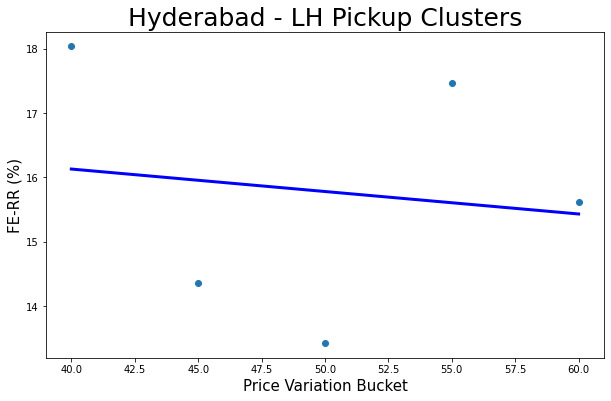

In [310]:
required_fe_rr_uplift = 4

max_price_variation = shortlisted_routes_fare_estimates['price_variation'].astype(int).max()
max_price_variation = max_price_variation + (5 - max_price_variation % 5)
min_price_variation = shortlisted_routes_fare_estimates['price_variation'].astype(int).min()
min_price_variation = min_price_variation - (5 - abs(min_price_variation) % 5)

bin_price_variation = list(range(min_price_variation, max_price_variation + 1, 5))
bin_price_variation_label = list(range(min_price_variation, max_price_variation, 5))
merged_fe2rr_rc_data['price_variation_bucket'] = pd.cut(merged_fe2rr_rc_data[
                                                                         'price_variation'],
                                                                     bins=bin_price_variation,
                                                                     include_lowest=True,
                                                                     labels=bin_price_variation_label).astype(int)

rate_card_avg = shortlisted_routes_fare_estimates.groupby(['pickup_cluster', 'week_period','time_period']).agg(
    mean_rate_card_avg=pd.NamedAgg('price_variation', 'mean')).reset_index()

print(rate_card_avg)

#avg_ferr_calc = shortlisted_routes_fare_estimates[shortlisted_routes_fare_estimates['price_variation'] == 0]


#all_categories = shortlisted_routes_fare_estimates[['week_period','time_period']].unique()


rc_price_decrease = pd.DataFrame(columns=[
    'rc_price_decrease_pct', 'fe_rr_uplift'])

category_data = merged_fe2rr_rc_data.copy()

print(category_data)

pv_data = category_data.groupby(['week_period', 'time_period', 'price_variation_bucket']).agg(
    total_num_fe=pd.NamedAgg('fe_count', 'sum'),
    gross_converted=pd.NamedAgg('rr_count', 'sum')
).reset_index().sort_values(['total_num_fe'])

pv_data['fe_rr_ratio'] = (
        (100 * pv_data['gross_converted']) / pv_data['total_num_fe']
)

pv_data = pv_data[(pv_data['fe_rr_ratio'] != 0) & (
        pv_data['fe_rr_ratio'] != 100) & (
    pv_data['price_variation_bucket'] >= 40) & (pv_data['price_variation_bucket'] <= 60)].reset_index(drop=True)

print('Input data to the model...')

print(pv_data.shape)

pv_data = pv_data.sort_values(['price_variation_bucket']).reset_index(drop=True)
rate_card_mean = rate_card_avg['mean_rate_card_avg']
fe_rr_mean = fe_rr_avg['fe_rr_ratio']

X = pv_data['price_variation_bucket'].values
Y = pv_data['fe_rr_ratio'].values
m = len(X)
X = X.reshape((m, 1))

reg = LinearRegression()
reg = reg.fit(X, Y)
Y_pred = reg.predict(X)

X1 = [[0], [-2], [-4], [-6], [-8], [-10], [-12], [-13], [-14], [-16], [-18]]
Y1_pred = reg.predict(X1)
Y1_recommend = Y1_pred - Y1_pred[0]

get_index = list(Y1_recommend <= (required_fe_rr_uplift + 1))
max_index = 0
for idx, val in enumerate(get_index):
    if val == True:
        max_index = idx

rc_price_decrease = rc_price_decrease.append({
    'discount_percent': abs(X1[max_index][0]),
    'fe_rr_uplift': round(Y1_recommend[max_index], 2)},
    ignore_index=True)

mse_model = mse(Y, Y_pred)
rmse = np.sqrt(mse_model)
r2_score = reg.score(X, Y)

print(
    '--------------------------------------------------------------------------------------------------------')
plt.rcParams['figure.figsize'] = [10, 6]
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='blue', linewidth=3)
plt.title(city + ' - LH Pickup Clusters', fontsize=25)
plt.xlabel('Price Variation Bucket', fontsize=15)
plt.ylabel('FE-RR (%)', fontsize=15)
print('RMSE: ' + str(rmse))
print('R2_Score: ' + str(r2_score))
print('')
print('Avg FE-RR (%): ' + str(fe_rr_mean))
print('')
print('Rate Card Price Decrease Discount(%): ' + str(X1))
print('')
print('FE-RR(%): ' + str(Y1_pred))
print('')
print('Delta FE-RR(%): ' + str(Y1_recommend))
print(
    '--------------------------------------------------------------------------------------------------------')

plt.show()